In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output


%matplotlib inline


In [2]:
cd /Users/austinmcdonald/Desktop/test/cut/

/Users/austinmcdonald/Desktop/test/cut


In [3]:
DataSet = os.listdir()
DataSet = [x for x in DataSet if x != '.DS_Store']
DataSet

['Ba', 'Ca', 'Na']

In [4]:
DataPath = '/Users/austinmcdonald/Desktop/test/cut'

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [6]:
eCoeff = 0.01160
eOffset= 1917
AreaFull = dict()
AreaCUT = dict()
PairsM = dict()
PairsA = dict()
AreaCUT2 = dict() 
PairsM2 = dict()
Bleached = dict()
INFO1 = dict()
INFO2 = dict()

LIFETIME= dict()
INTENSITY= dict()
AREA= dict()
AREAPRE=dict()
AREAPOST=dict()
AREASS=dict()
CHIR= dict()
MEAND= dict()
MEANI=dict()
MEANE=dict()
PPairs = []
for z in range(0,len(DataSet)):
    FoldPath = DataPath+'/'+DataSet[z]
    Folders = os.listdir(FoldPath)
    Folders = [x for x in Folders if x != '.DS_Store']
    
    AreaH=[]        # kill this ?
    AreaHH=[]       # kill this ?
    SpotAreaH = []  # kill this ?
    SpotAreaHH = [] # kill this ?
    SpotAreaHH2 = []# kill this ?
    PairsMade2 = [] # kill this ?
    Bleach = []     # kill this ?
    MASTERTau = []
    MASTERItn = []
    MASTERarea=[]
    MASTERchiRa=[]
    MASTERmeanD=[]
    MASTERareaSS=[]
    MASTERareaPre=[]
    MASTERareaPost=[]
    MASTERmeanI=[]
    MASTERmeanE=[]

    PairsMade = []
    Shape = 221
    xvs = np.arange(0,Shape)
    ##Means = []# kill this ?
    #Devs  = []# kill this ?
    neighborhood_size = 9
    Row = int(4) # define the area to take around the spots
    Col = int(4) # define the area to take around the spots
    for w in range(0,len(Folders)):
        folder = FoldPath+'/'+Folders[w]
        files = os.listdir(folder)
        files = [x for x in files if x != '.DS_Store']
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        Datatot = DataSub
        fitts = []
        AllPairs =[]
        SpotInfo2 = []

        ImageB = []
        MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
        eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
        eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
        for x in range(700,750):
            Images = np.array(Image.open(folder+'/'+files[x]))
            Images = eCoeffM*(Images - eOffsetM)
            #Mfit = np.zeros(len(xvs)) # kill this ?
            ImageFit = []
            for y in range(0,Shape):
                coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
                ffit  = poly.polyval(xvs, coefs)
                ImageFit.append(ffit)
            MeanFit+=np.array(ImageFit)
        MeanFit = MeanFit/50


        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            DataSub += Images


        data = DataSub

        threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        Pairs = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            x.append(x_center)
            y_center = (dy.start + dy.stop - 1)/2    
            y.append(y_center)
            Pairs.append((x_center,y_center))
        for item in Pairs:
            if item not in AllPairs:
                AllPairs.append(item) 


        Images = None
        ImageB = None
        #data   = None
        Slices = None
        labeled= None
        num_objects=None

        ############################################################## 
        Xc=[]
        Yc=[]
        for qw in range(0,len(AllPairs)):
            XX = AllPairs[qw][0]
            YY = AllPairs[qw][1]
            if XX>10 and XX<210 and YY>10 and YY<210:
                Xc.append(XX)
                Yc.append(YY)
        #try:
            #Xc=[]
            #Yc=[]
            #for qw in range(0,len(AllPairs)):
                #XX = AllPairs[qw][0]
                #YY = AllPairs[qw][0]
                #if XX>10 and XX<210 and YY>10 and YY<210:
                    #Xc.append(XX)
                    #Yc.append(YY)
        #except ValueError:
            #break
            #Xc=0
            #Yc=0
            #AllPairs=0

        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(AllPairs)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]*(25/56)
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
            vals =np.arange(0,len(aa))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit)

            meanI = np.mean(Sig[:Mnumb])
            sigmaI = np.std(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            sigmaE = np.std(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        #chiF = []
        #chiB = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        areaPost=[]
        ITEN=[]
        MeanI=[]
        MeanE=[]
        Offset =3
        for x in range(0,Par):
            TauH   = Tau3[x]
            Data = running_mean(Signal[x],4)
            DataLeft  = Data[:int(TauH)-Offset]
            DataRight = Data[int(TauH)+Offset:]
            sigma = np.std(Data)
            mean  = np.mean(Data)
            meanI  = np.mean(DataLeft)
            sigmaI = np.std(DataLeft)
            meanE  = np.mean(DataRight)
            sigmaE = np.std(DataRight)
            Inten  = Signal[x][:int(TauH)]
            Intensity  = np.sum(Inten)/len(Inten)#######  mean? wtf man
            chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
            chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
            val = np.arange(0,len(Data),1)
            fit=np.polyfit(val,Data,1)    
            chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
            ###dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
            #data.append([Signal[x],TauH,Intensity])
            #PairsMade.append(AllPairs[x])
            #chiF.append(chiHIGH)
            #chiB.append(chiLOW)
            #chiFIT.append(chiFit)
            ITEN.append(Intensity)
            chiRa.append((chiLOW+chiHIGH)/ chiFit)
            meanDif.append(meanI-meanE)
            ###Dtau.append(dtau)
            areaS.append(Signal[x])
            areaSS.append(Data)
            areaPre.append(DataLeft)
            areaPost.append(DataRight)
            MeanI.append(meanI)
            MeanE.append(meanE)

        MASTERTau.append(Tau3)
        MASTERItn.append(ITEN)
        MASTERarea.append(areaS)
        MASTERareaSS.append(areaSS)
        MASTERareaPre.append(areaPre)
        MASTERareaPost.append(areaPost)

        MASTERchiRa.append(chiRa)
        MASTERmeanD.append(meanDif)
        MASTERmeanI.append(MeanI)
        MASTERmeanE.append(MeanE)
        
    MEANI[z] = [item for sublist in MASTERmeanI for item in sublist] 
    MEANE[z] = [item for sublist in MASTERmeanE for item in sublist]
    LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    INTENSITY[z]= [item for sublist in MASTERItn for item in sublist]
    AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    AREAPRE[z]  = [item for sublist in MASTERareaPre for item in sublist]
    AREAPOST[z] = [item for sublist in MASTERareaPost for item in sublist]

    AREASS[z]     = [item for sublist in MASTERareaSS for item in sublist]

    CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]

    #AreaFull[z]  = [item for sublist in AreaHH for item in sublist]
    #AreaCUT[z]   = [item for sublist in SpotAreaHH for item in sublist]
    #PairsM[z]    = [item for sublist in PairsMade for item in sublist]
    #PairsA[z]    = [item for sublist in PPairs for item in sublist]
    #AreaCUT2[z]  = [item for sublist in SpotAreaHH2 for item in sublist]
    #PairsM2[z]   = [item for sublist in PairsMade2 for item in sublist]
    #Bleached[z]  = Bleach

Finding all areas in dataset 2
Finding all areas in folder 17
On file 750 of 750


In [7]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' pairs = ',len(LIFETIME[x]))

Ba  pairs =  1742
Ca  pairs =  1143
Na  pairs =  1746


In [8]:
SAVE = '/Users/austinmcdonald/Desktop/test-images/Spots-slide1and2/'

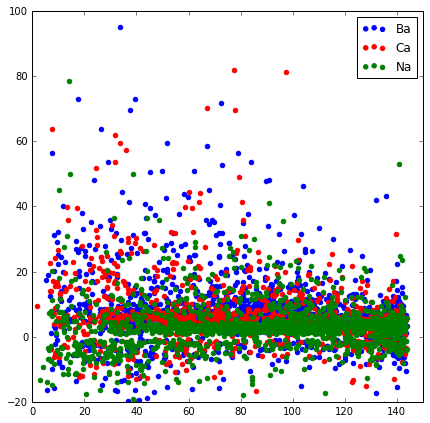

In [9]:
plt.figure(figsize=(7,7))
bright=dict()
life=dict()
for x in range(0,len(DataSet)):
    LT=[]
    IT=[]
    for z in range(0,len(LIFETIME[x])):
        if MEANE[x][z]<0:
            Correct = abs(MEANE[x][z])
        else:
            Correct = -abs(MEANE[x][z])
        LT.append(LIFETIME[x][z])
        IT.append(INTENSITY[x][z]+Correct)
    life[x]=LT# = [item for sublist in LT for item in sublist]
    bright[x]=IT# = [item for sublist in IT for item in sublist]

    
plt.scatter(life[0],bright[0],color='b',label=DataSet[0])
plt.scatter(life[1],bright[1],color='r',label=DataSet[1])
plt.scatter(life[2],bright[2],color='g',label=DataSet[2])
vars=np.arange(0,100,1)
plt.legend()
plt.xlim(0,150)
plt.ylim(-20,100)
#plt.savefig(SAVE+'RAWlifetime')

plt.show()

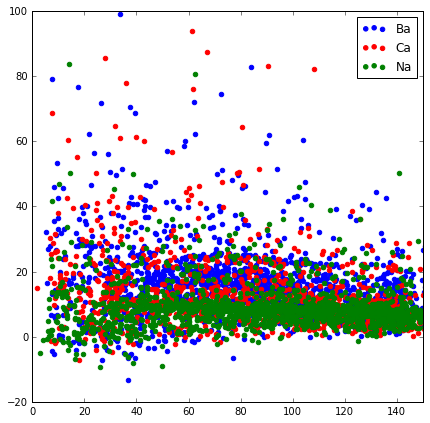

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(LIFETIME[0],INTENSITY[0],color='b',label=DataSet[0])
plt.scatter(LIFETIME[1],INTENSITY[1],color='r',label=DataSet[1])
plt.scatter(LIFETIME[2],INTENSITY[2],color='g',label=DataSet[2])
#fitba=np.polyfit(LIFETIME[0],INTENSITY[0],1)
#fitca=np.polyfit(LIFETIME[1],INTENSITY[1],1)
#fitna=np.polyfit(LIFETIME[2],INTENSITY[2],1)
vars=np.arange(0,100,1)
#plt.plot(vars,fitba[1]+vars*fitba[0],color='b')
#plt.plot(vars,fitca[1]+vars*fitca[0],color='r')
#plt.plot(vars,fitna[1]+vars*fitna[0],color='g')
#plt.plot()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,150)
plt.ylim(-20,100)
#plt.savefig(SAVE+'RAWlifetime')

plt.show()

In [35]:
itensity=dict()
lifetime=dict()
for x in range(0,len(DataSet)):
    LT=[]
    IT=[]
    for z in range(0,len(LIFETIME[x])):
        if MEAND[x][z]>28 and CHIR[x][z]<1 :#and MEANE[x][z]<20:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            LT.append(LIFETIME[x][z])
            IT.append(INTENSITY[x][z]+Correct)
    lifetime[x]=LT# = [item for sublist in LT for item in sublist]
    itensity[x]=IT# = [item for sublist in IT for item in sublist]
len(lifetime[0])

59

Ba tau =  1336.0165 ms
Ca tau =  -3484.8824 ms
Na tau =  806.2739 ms


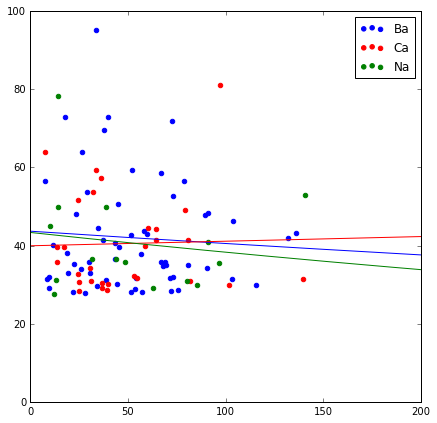

In [36]:
plt.figure(figsize=(7,7))

plt.scatter(lifetime[0],itensity[0],color='b',label=DataSet[0])
plt.scatter(lifetime[1],itensity[1],color='r',label=DataSet[1])
plt.scatter(lifetime[2],itensity[2],color='g',label=DataSet[2])
fitba,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[0],  itensity[0],  p0=(1, 0.1))
fitca,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[1],  itensity[1],  p0=(1, 0.1))
fitna,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[2],  itensity[2],  p0=(1, 0.1))
vars=np.arange(0,500,1)
plt.plot(vars,fitba[0]*np.exp(fitba[1]*vars),color='b')
plt.plot(vars,fitca[0]*np.exp(fitca[1]*vars),color='r')
plt.plot(vars,fitna[0]*np.exp(fitna[1]*vars),color='g')

#plt.plot(vars,fitba[1]+vars*fitba[0],color='b')
#plt.plot(vars,fitca[1]+vars*fitca[0],color='r')
#plt.plot(vars,fitna[1]+vars*fitna[0],color='g')
plt.plot()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,200)
plt.ylim(0,100)
print('Ba tau = ',"%.4f"%(-1/fitba[1]),"ms")
print('Ca tau = ',"%.4f"%(-1/fitca[1]),"ms")
print('Na tau = ',"%.4f"%(-1/fitna[1]),"ms")
#plt.savefig(SAVE+'CUTlifetime')

plt.show()

In [14]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' Passes Cuts = ',len(lifetime[x]))

Ba  Passes Cuts =  112
Ca  Passes Cuts =  70
Na  Passes Cuts =  43


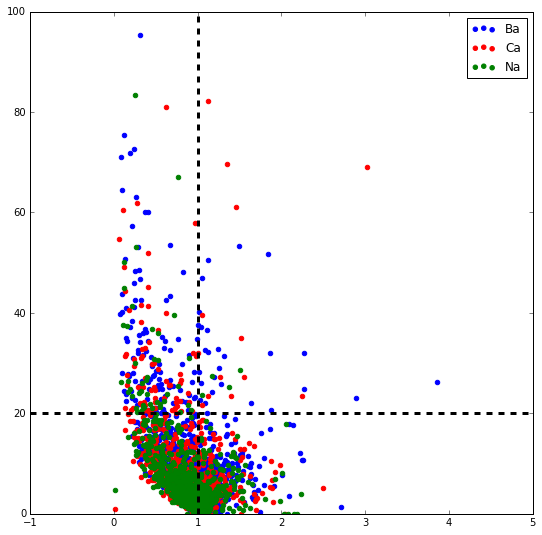

In [15]:
plt.figure(figsize=(9,9))
plt.scatter(CHIR[0],MEAND[0],color='b',label=DataSet[0])
plt.scatter(CHIR[1],MEAND[1],color='r',label=DataSet[1])
plt.scatter(CHIR[2],MEAND[2],color='g',label=DataSet[2])
plt.axhline(20,linewidth=3,linestyle='--',color='k')
plt.axvline(1,linewidth=3,linestyle='--',color='k')
plt.legend()
#plt.xlim(.3,2)
plt.ylim(0,100)
#plt.savefig(SAVE+'CUTspace')

plt.show()

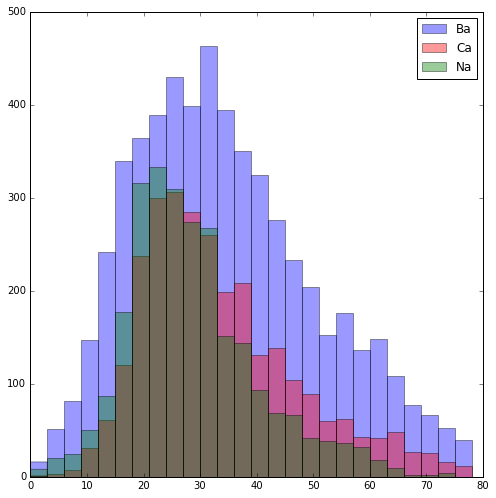

In [16]:
'''Hist of the areas before the bleach'''
AreaPass=dict()
for x in range(0,len(DataSet)):
    AP=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            AP.append(AREAPRE[x][z])
            #AP.append(INTENSITY[x][z])
    AreaPass[x] = [item for sublist in AP for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num))
plt.hist(AreaPass[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num))
plt.hist(AreaPass[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre')
plt.show()

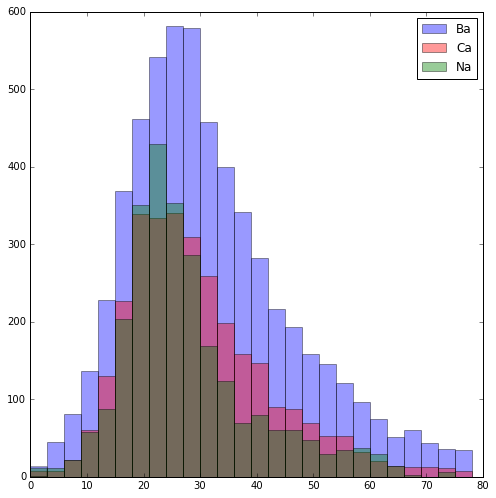

In [17]:
'''Hist of areas before bleach plus the mean of the base line'''

AreaPass1=dict()
for x in range(0,len(DataSet)):
    AP=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            ass=np.array(AREAPRE[x][z])+Correct
            AP.append(ass)
            #AP.append(AREAPRE[x][z])
            #AP.append(INTENSITY[x][z])
    AreaPass1[x] = [item for sublist in AP for item in sublist]
    
plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass1[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num))
plt.hist(AreaPass1[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num))
plt.hist(AreaPass1[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-meancor')
plt.show()
AreaPass=None 

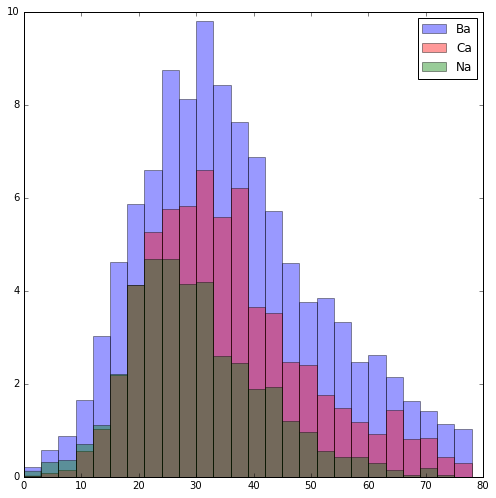

In [18]:
'''Hist of the areas before the bleach weighted by lifetime'''
AreaPass2=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            W = np.ones(len(AREAPRE[x][z]))/len(AREAPRE[x][z])
            AP.append(AREAPRE[x][z])
            WW.append(W)
            #AP.append(INTENSITY[x][z])
    AreaPass2[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass2[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass2[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass2[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-lifeWgh')
plt.show()

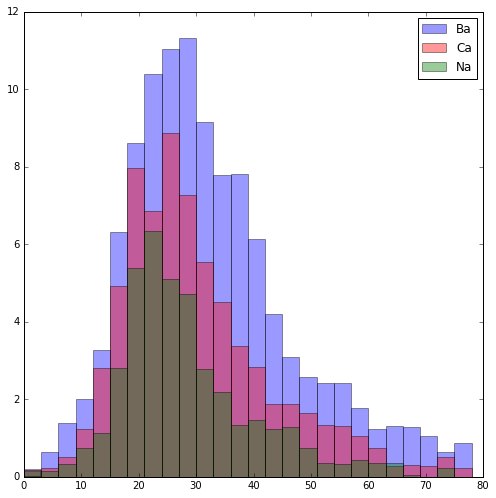

In [19]:
'''Hist of the areas before the plus the mean and weighted by lifetime'''
AreaPass3=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            W = np.ones(len(AREAPRE[x][z]))/len(AREAPRE[x][z])
            WW.append(W)
            asss=np.array(AREAPRE[x][z])+Correct
            AP.append(asss)
    AreaPass3[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass3[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass3[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass3[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-meancor-lifeWgh')
plt.show()

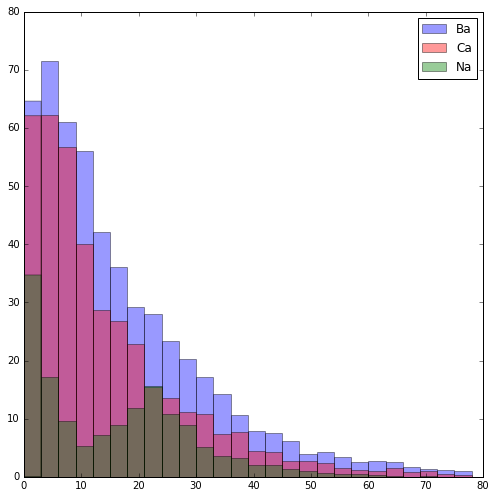

In [20]:
'''Hist of the areas  weighted by lifetime'''
AreaPass4=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            W = np.ones(len(AREASS[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREASS[x][z])
            AP.append(assss)
    AreaPass4[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass4[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass4[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass4[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapreRAW-lifeWgh')
plt.show()

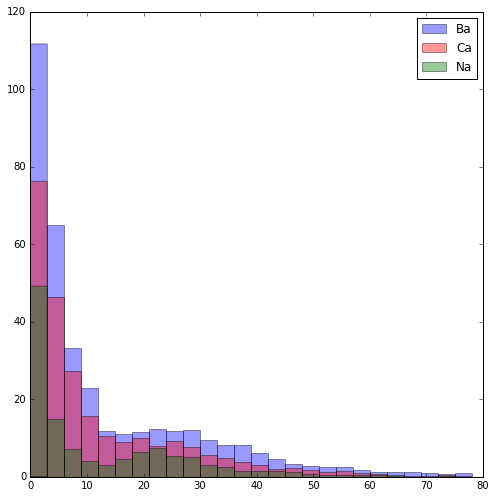

In [21]:
'''Hist of the areas  weighted by lifetime and mean corrected'''
AreaPass4=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            W = np.ones(len(AREASS[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREASS[x][z])+Correct
            AP.append(assss)
    AreaPass4[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass4[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass4[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass4[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapreRAW-meancor-lifeWgh')
plt.show()

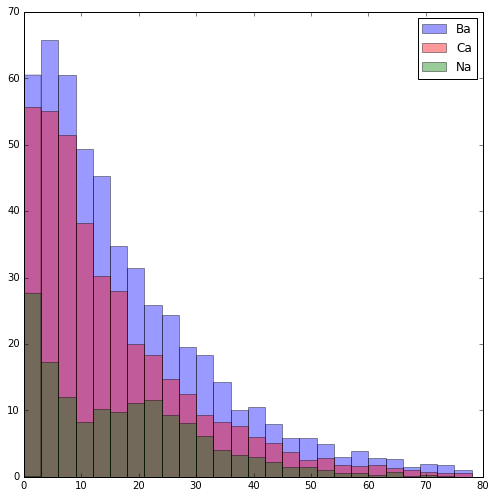

In [22]:
'''Hist of the FULLareas  weighted by lifetime'''
AreaPass7=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:

            W = np.ones(len(AREA[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREA[x][z])
            AP.append(assss)
    AreaPass7[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass7[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass7[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass7[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

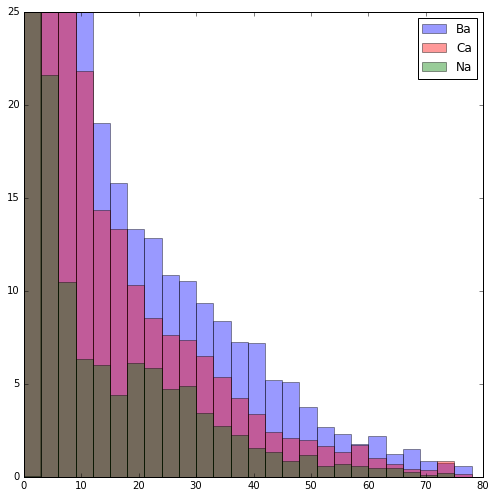

In [24]:
'''Hist of the FULLareas  weighted by lifetime and mean corrected'''
AreaPass8=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            W = np.ones(len(AREA[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREA[x][z])+Correct
            AP.append(assss)
    AreaPass8[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass8[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass8[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass8[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

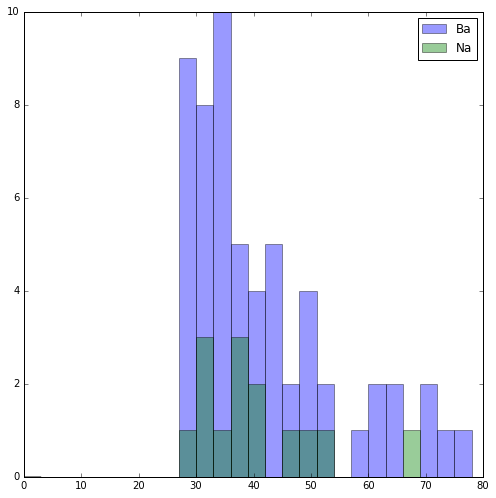

In [34]:
'''Hist of the FULLareas  weighted by lifetime and mean corrected'''
AreaPass8=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>28 and CHIR[x][z]<1:
            #if MEANE[x][z]<0:
            #    Correct = abs(MEANE[x][z])
            #else:
            #    Correct = -abs(MEANE[x][z])
            #W = np.ones(len(AREA[x][z]))/len(AREAPRE[x][z])
            AP.append(MEAND[x][z])
            #WW.append(W)
            #assss=np.array(AREA[x][z])+Correct
            #AP.append(assss)
    AreaPass8[x] = AP#[item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass8[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num))#,weights=Wei[0])
#plt.hist(AreaPass8[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num))#,weights=Wei[1])
plt.hist(AreaPass8[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num))#,weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

mean diff= 15.5399604569
sigma front = 2.55095854618
sigma end = 1.7574613896


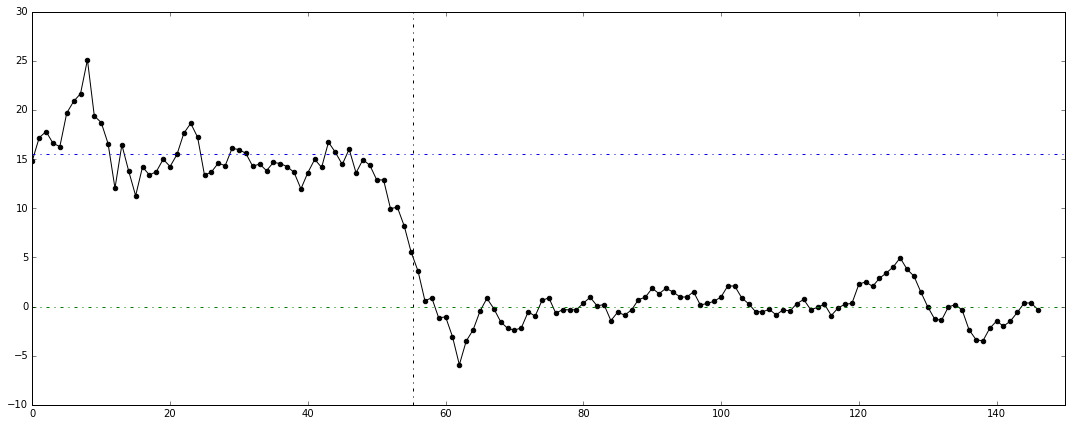

mean diff= 12.3434523115
sigma front = 3.66358074884
sigma end = 2.70153226861


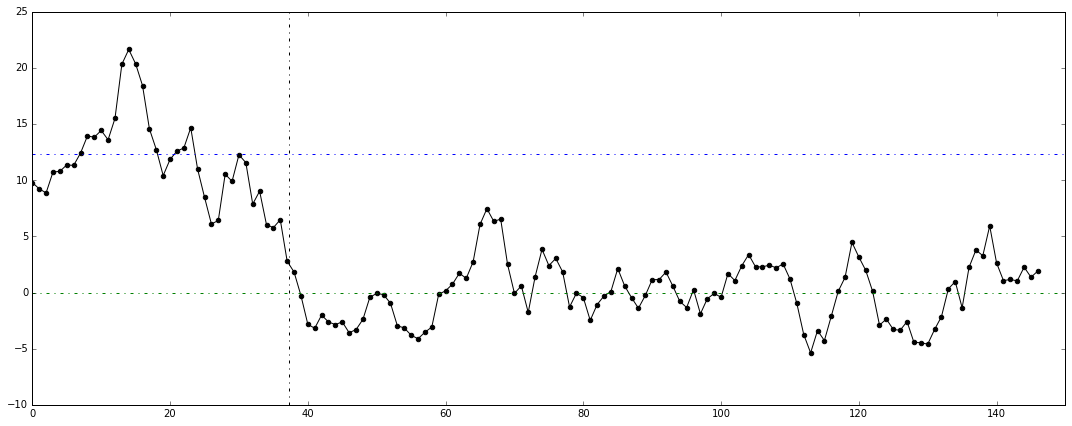

mean diff= 16.8185457343
sigma front = 4.62054680238
sigma end = 2.02605377182


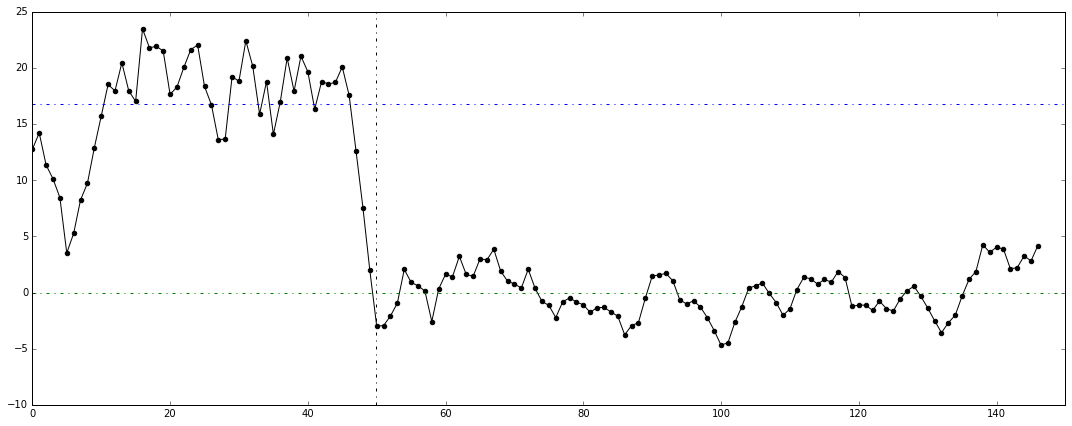

mean diff= 10.7835871413
sigma front = 8.48377285114
sigma end = 2.59679838597


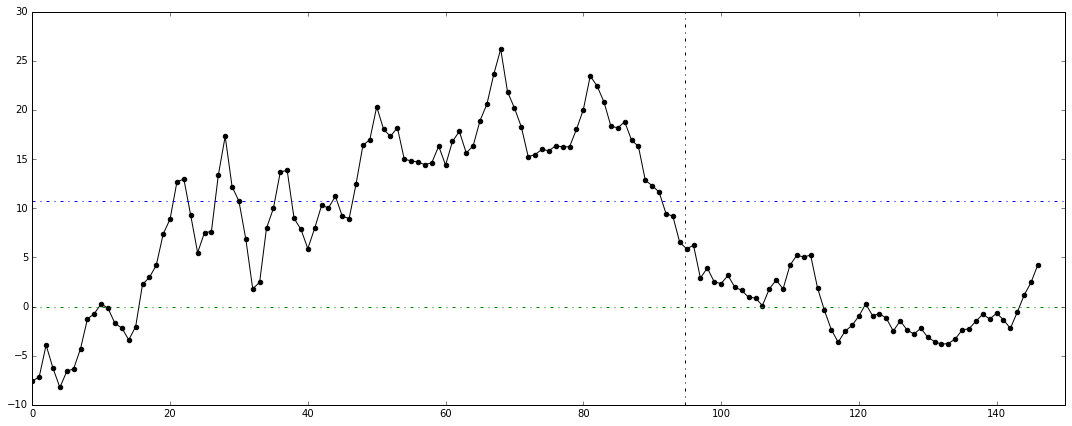

mean diff= 19.1475771066
sigma front = 14.1688435193
sigma end = 6.47987404986


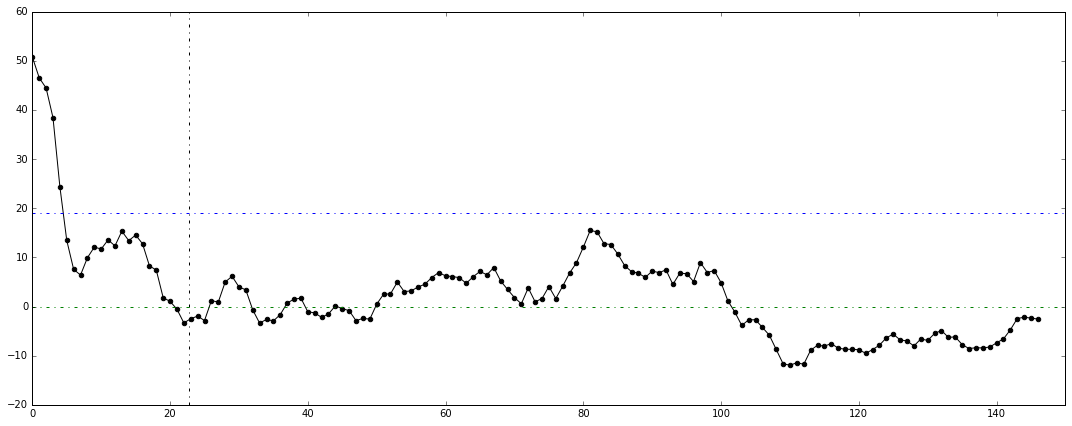

mean diff= 17.8755854473
sigma front = 7.47849762283
sigma end = 2.69001285573


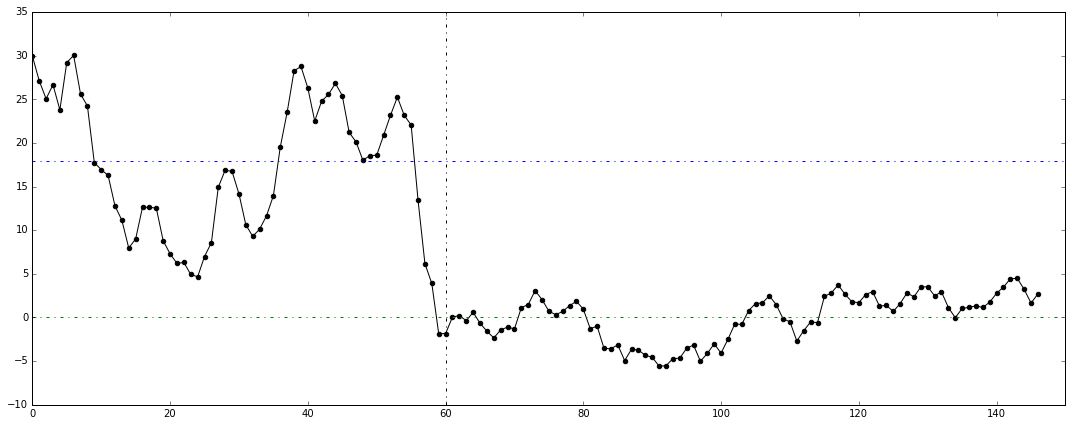

mean diff= 16.8772659155
sigma front = 5.25635346607
sigma end = 1.4274352059


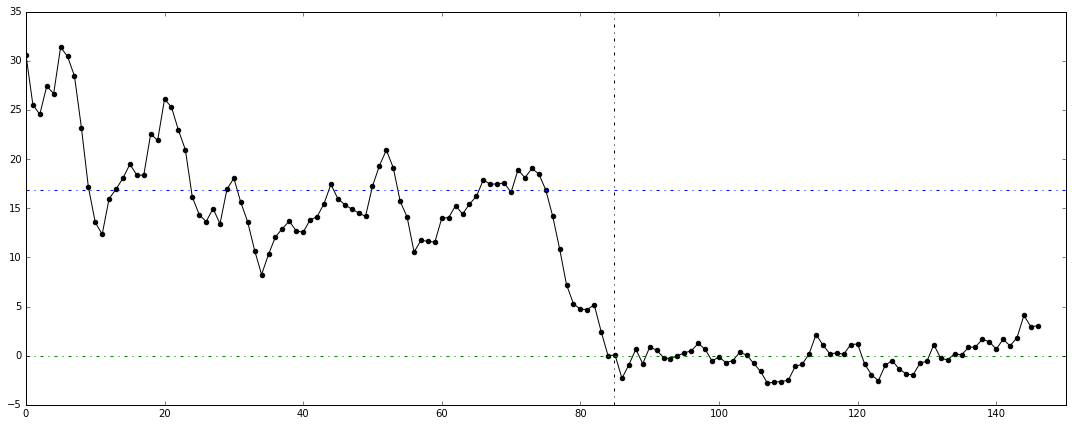

mean diff= 10.7015465583
sigma front = 5.04643039688
sigma end = 2.45426509715


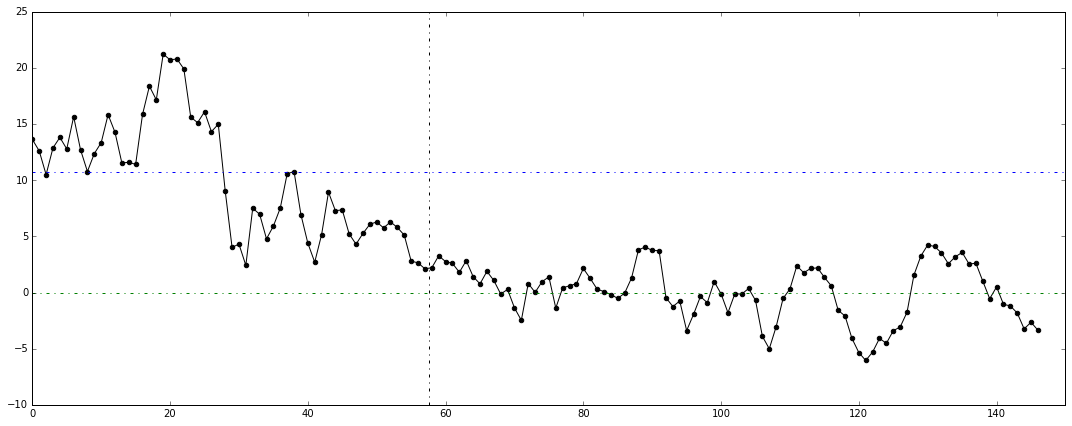

mean diff= 15.3418095841
sigma front = 7.74277756157
sigma end = 2.0239288315


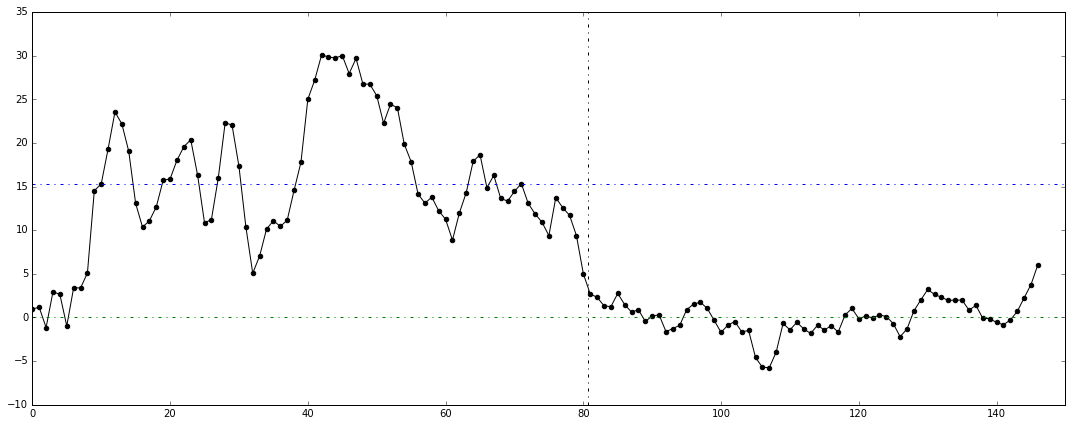

mean diff= 11.5464464822
sigma front = 3.37951697712
sigma end = 1.68086883688


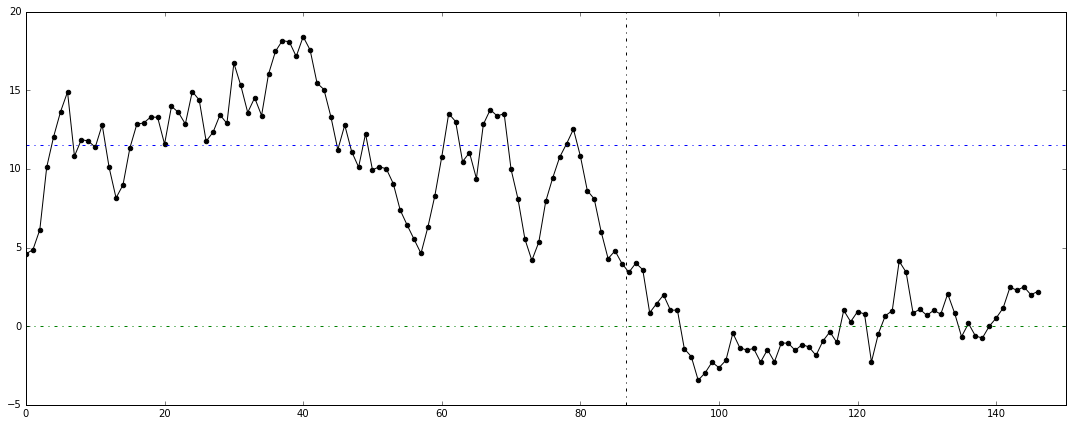

mean diff= 15.5671175548
sigma front = 5.66404210574
sigma end = 2.44974834293


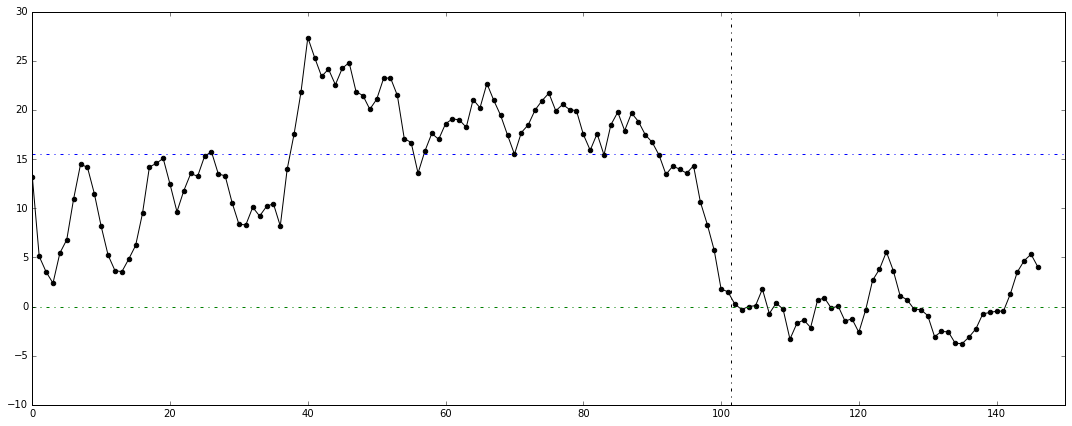

mean diff= 13.6398581458
sigma front = 2.41213368834
sigma end = 2.81567974726


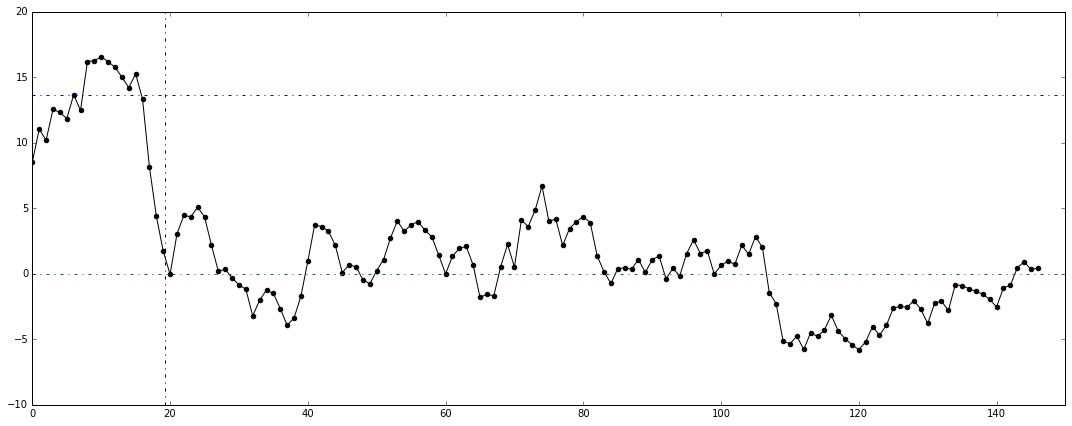

mean diff= 14.8326938221
sigma front = 3.73190459947
sigma end = 1.39618344246


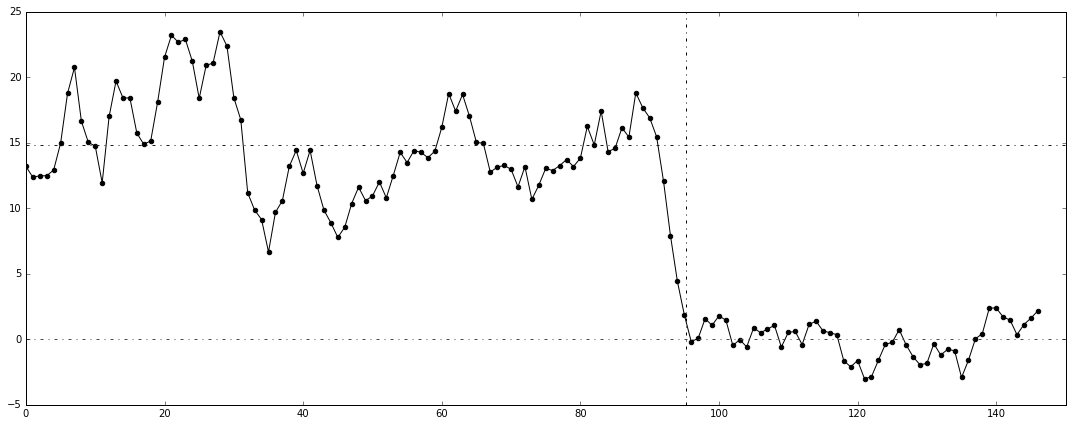

mean diff= 10.002910977
sigma front = 3.14639631423
sigma end = 2.64216363691


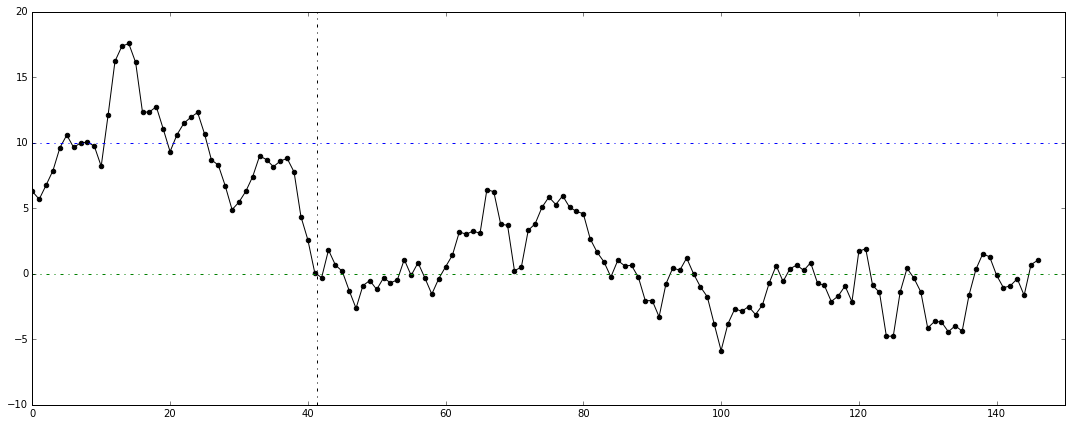

mean diff= 14.1590290438
sigma front = 9.75711391935
sigma end = 1.99248615183


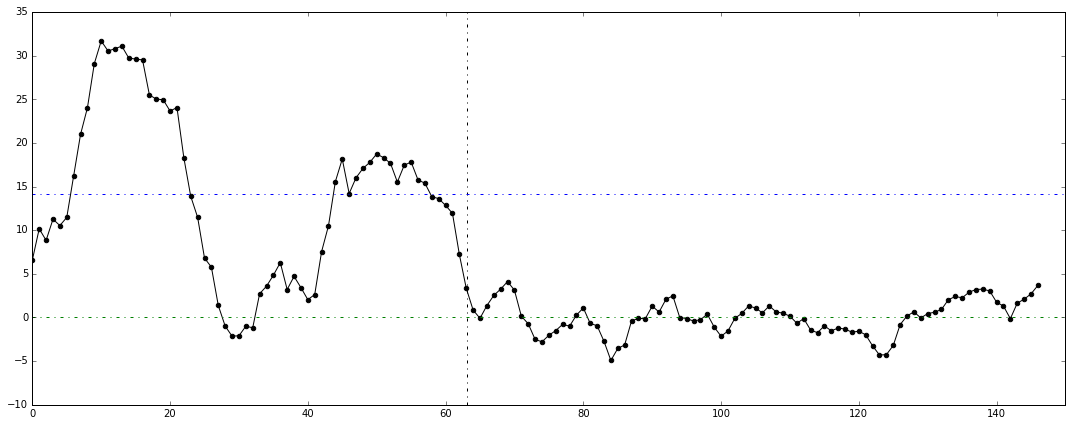

mean diff= 13.57063001
sigma front = 8.78577730283
sigma end = 2.63675973619


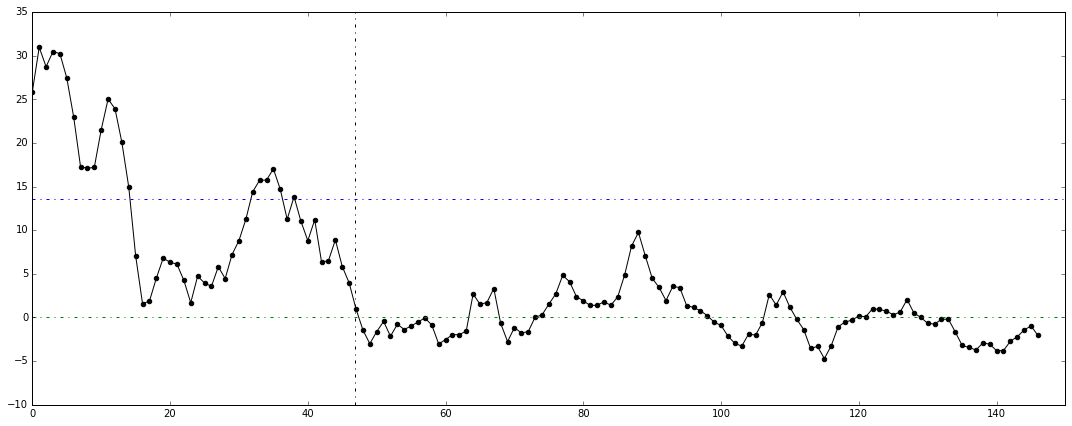

mean diff= 14.9526695438
sigma front = 6.72828131147
sigma end = 2.18936973556


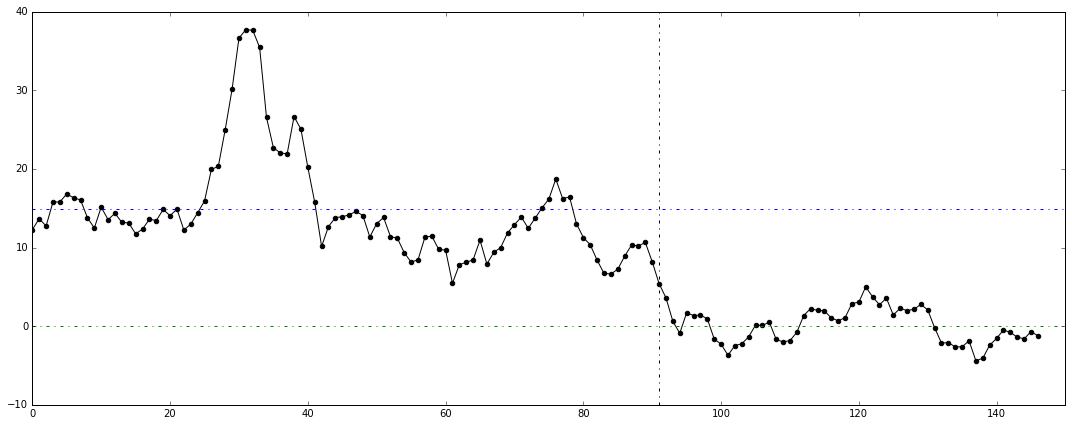

mean diff= 13.0786268799
sigma front = 9.70884378007
sigma end = 3.09254021657


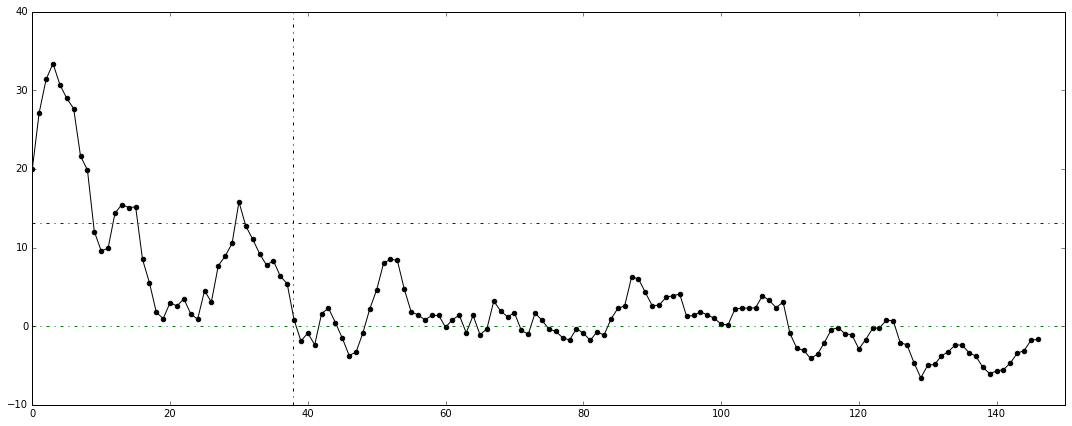

mean diff= 12.2388630648
sigma front = 4.32855838616
sigma end = 1.31162851341


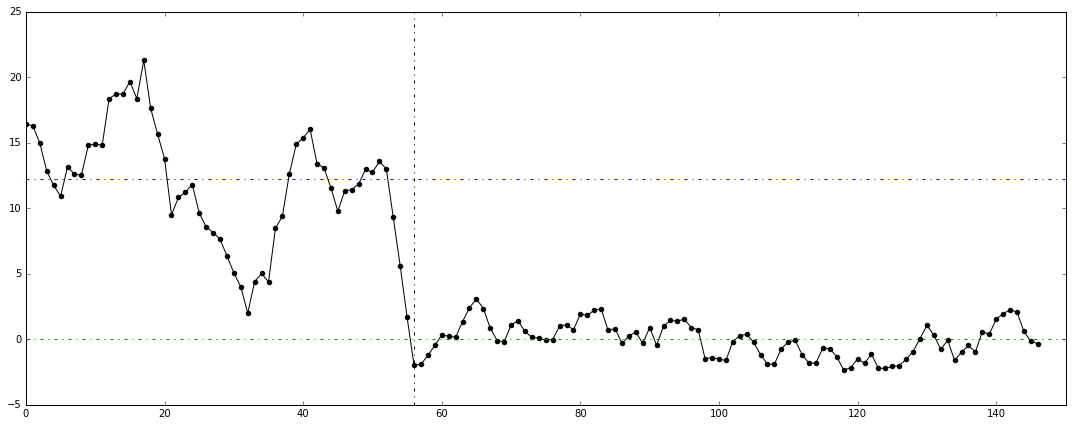

mean diff= 12.867522643
sigma front = 4.7256975616
sigma end = 2.04739141077


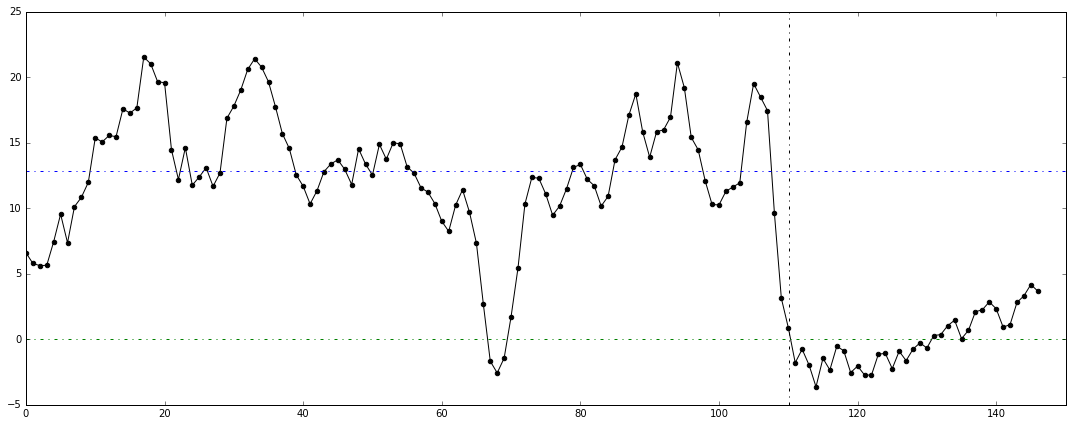

mean diff= 12.7002606387
sigma front = 3.01072712076
sigma end = 3.5251441824


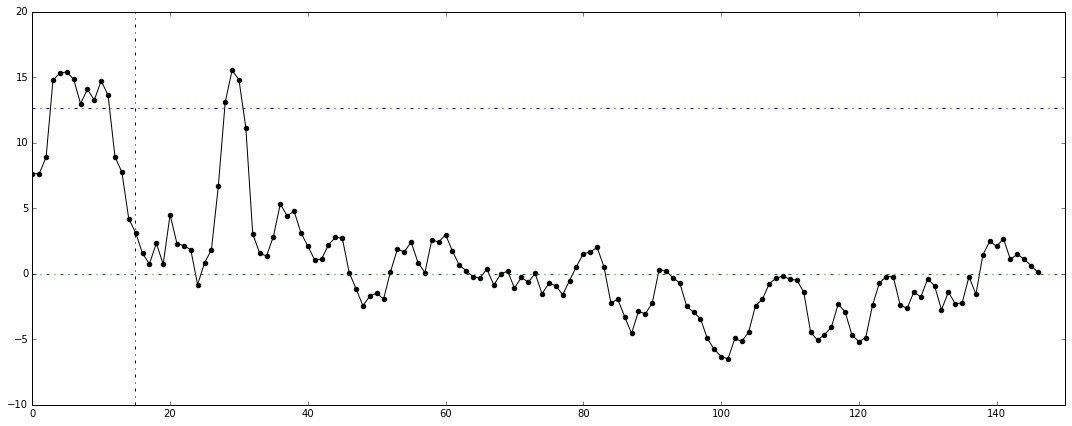

mean diff= 13.5556871459
sigma front = 2.93542999393
sigma end = 1.03992766021


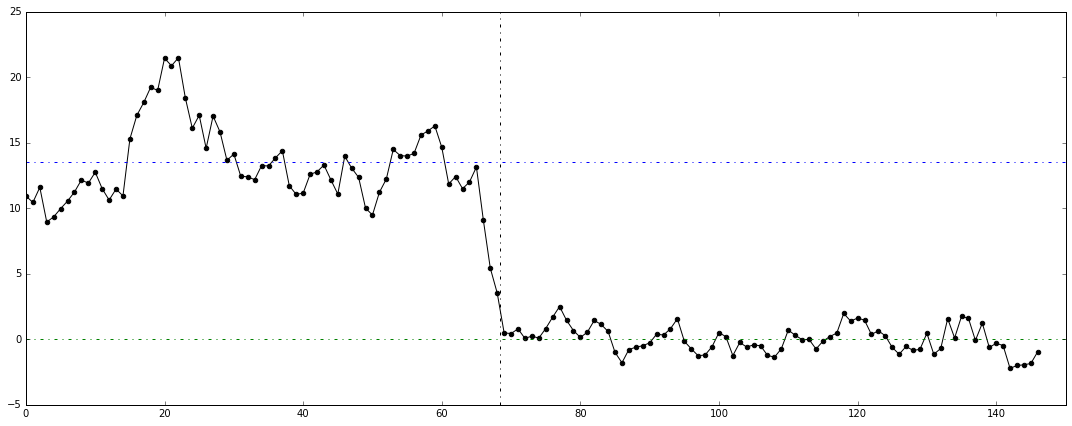

mean diff= 10.2595207128
sigma front = 1.98183097018
sigma end = 1.13480143637


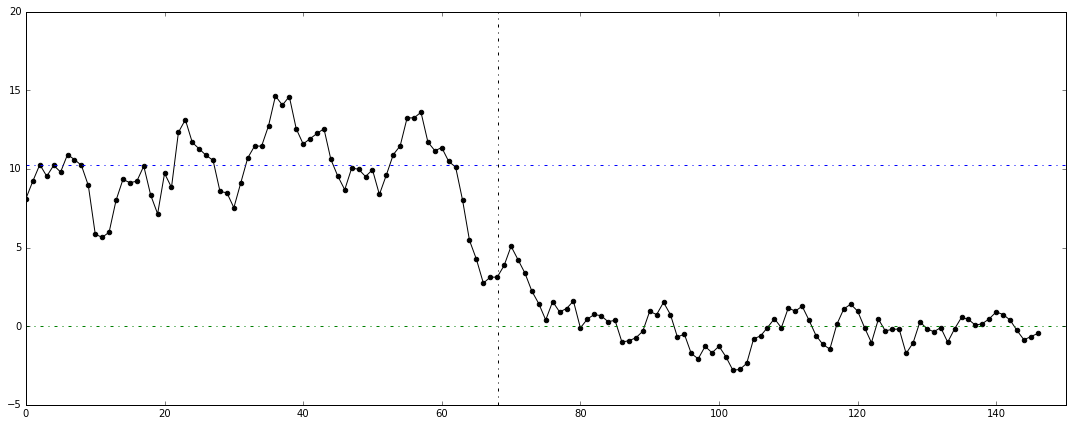

mean diff= 13.3960028951
sigma front = 3.53364225025
sigma end = 1.02039218218


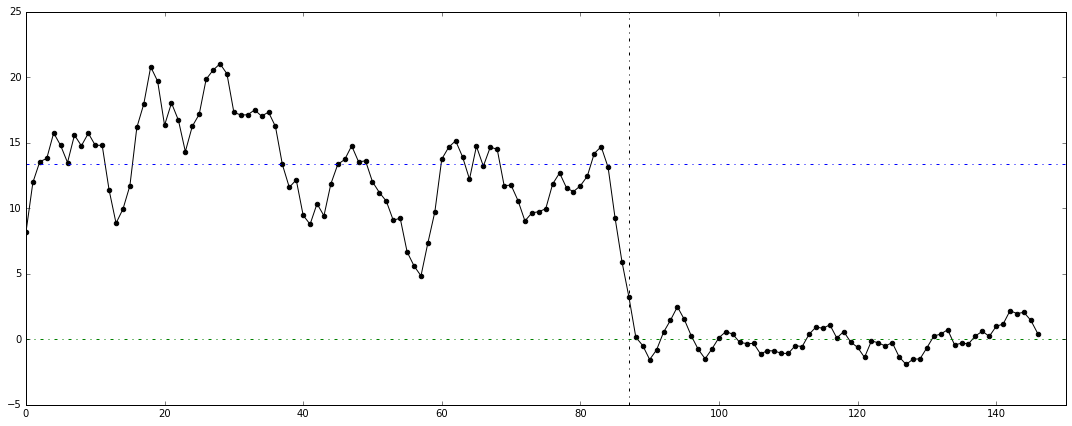

mean diff= 14.124060322
sigma front = 3.26821749474
sigma end = 1.4451970679


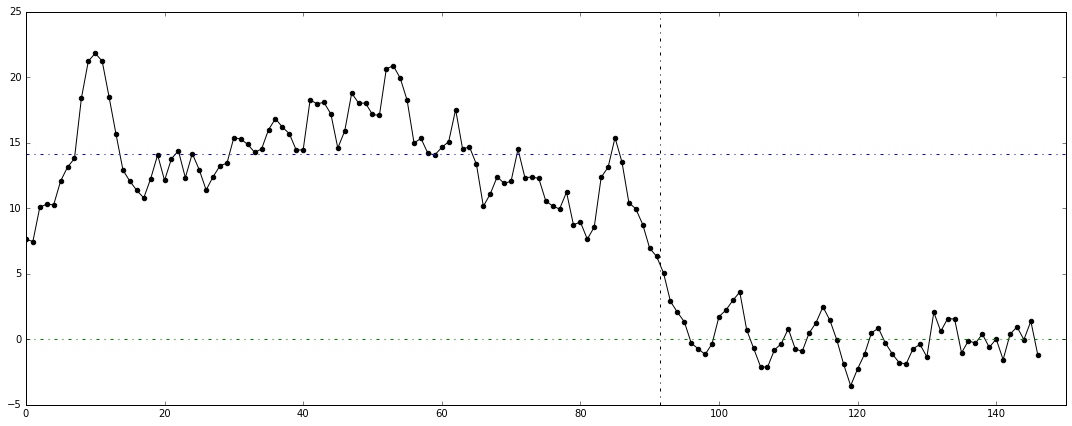

mean diff= 11.1501190542
sigma front = 5.84563521312
sigma end = 1.16014719817


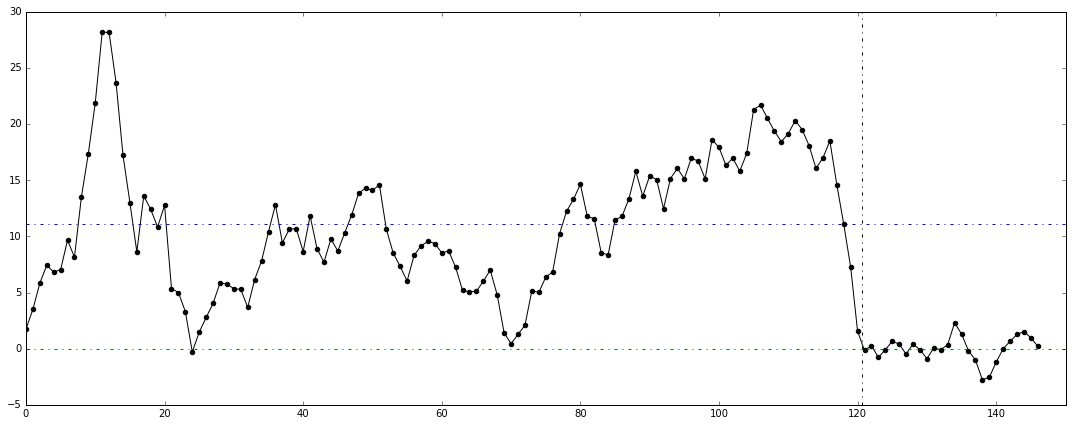

mean diff= 18.516721364
sigma front = 6.67257124523
sigma end = 2.97886440755


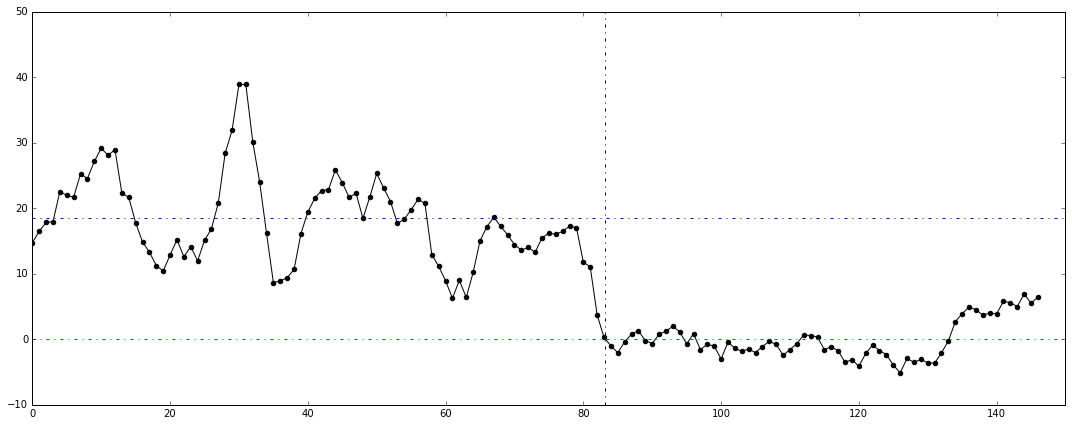

mean diff= 15.2271771606
sigma front = 4.69789048892
sigma end = 3.18863339609


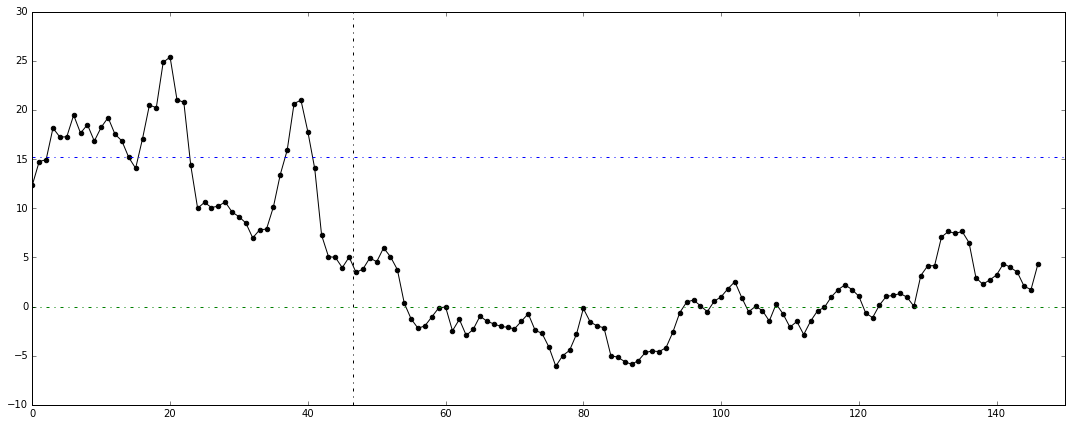

mean diff= 12.387032496
sigma front = 4.78089468228
sigma end = 0.585983675072


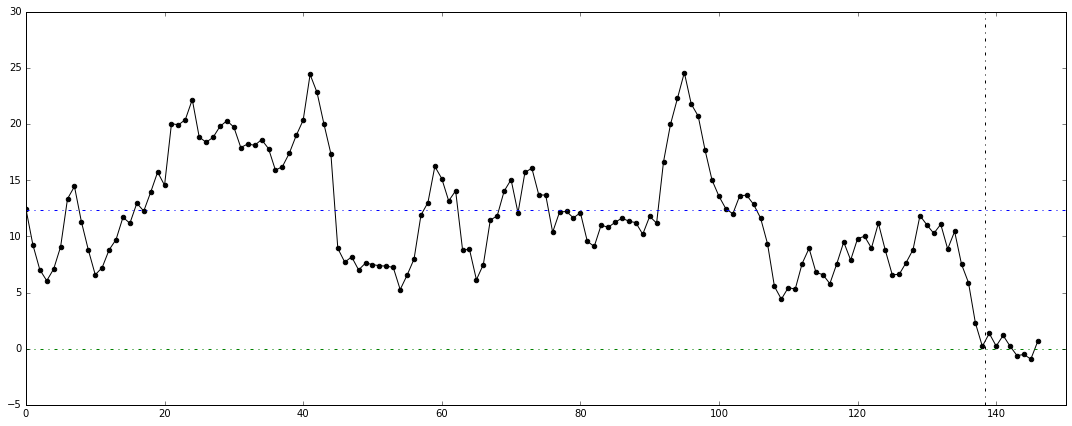

mean diff= 11.0007379277
sigma front = 14.4597431694
sigma end = 1.84377655878


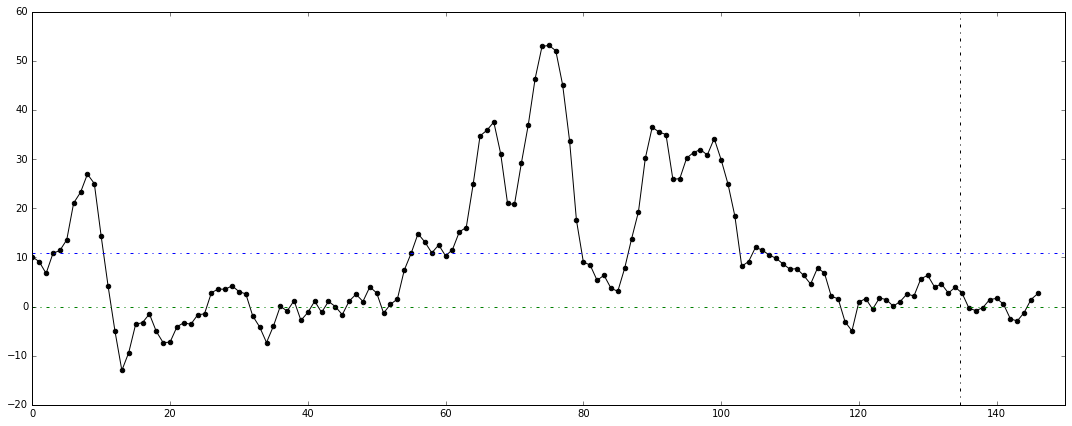

mean diff= 12.3919205348
sigma front = 4.88875611
sigma end = 1.51933115274


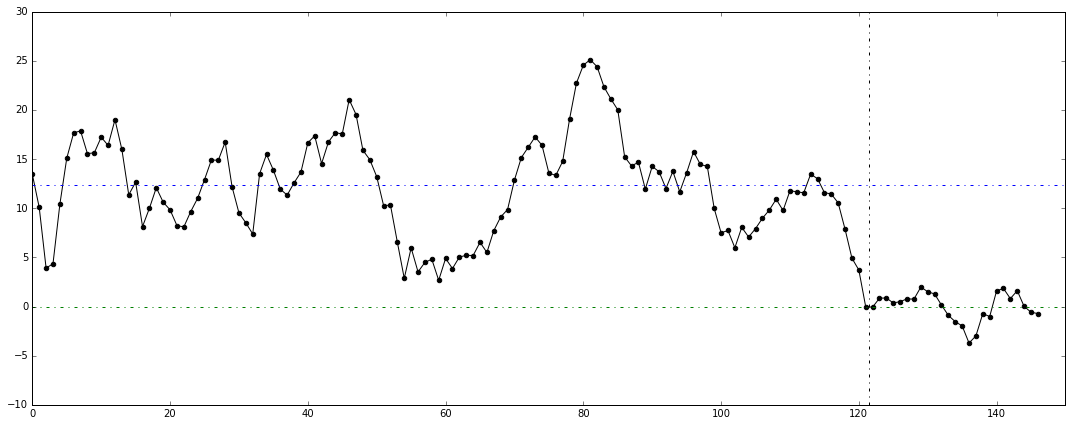

mean diff= 15.706802569
sigma front = 7.96410022043
sigma end = 2.24754842207


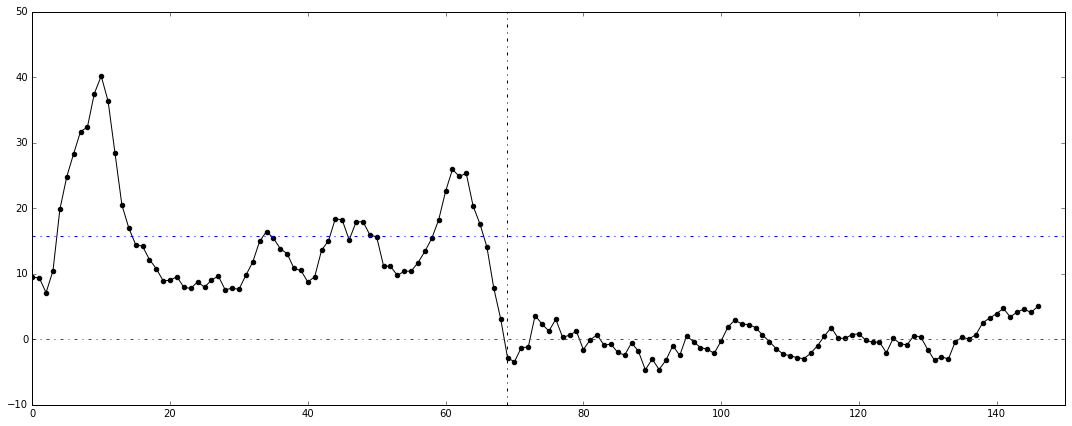

mean diff= 13.2320737258
sigma front = 6.94933259749
sigma end = 4.56158732135


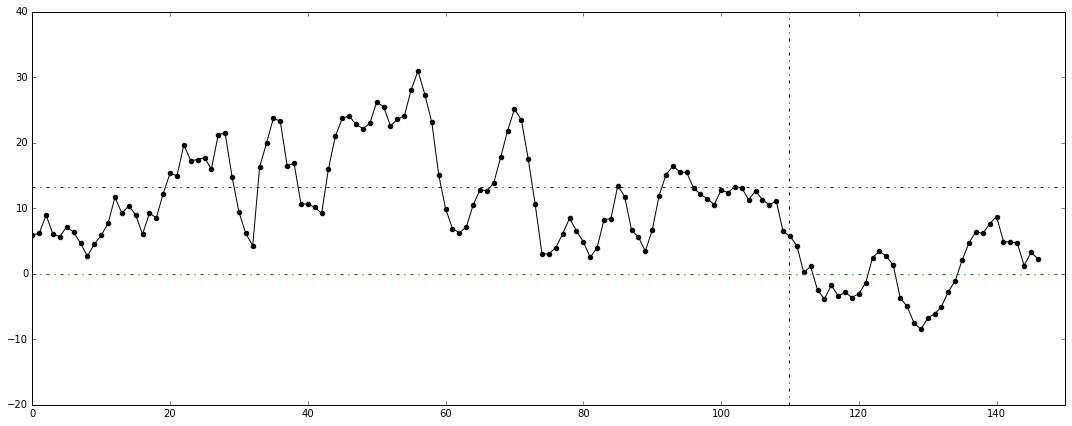

mean diff= 17.0257296593
sigma front = 5.47336190489
sigma end = 1.22656854585


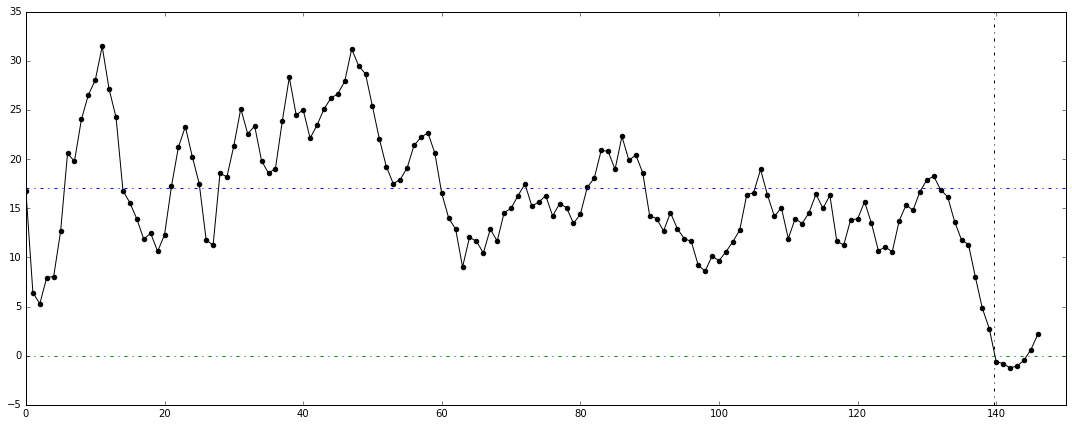

mean diff= 19.5088582985
sigma front = 12.5498057607
sigma end = 4.57572720249


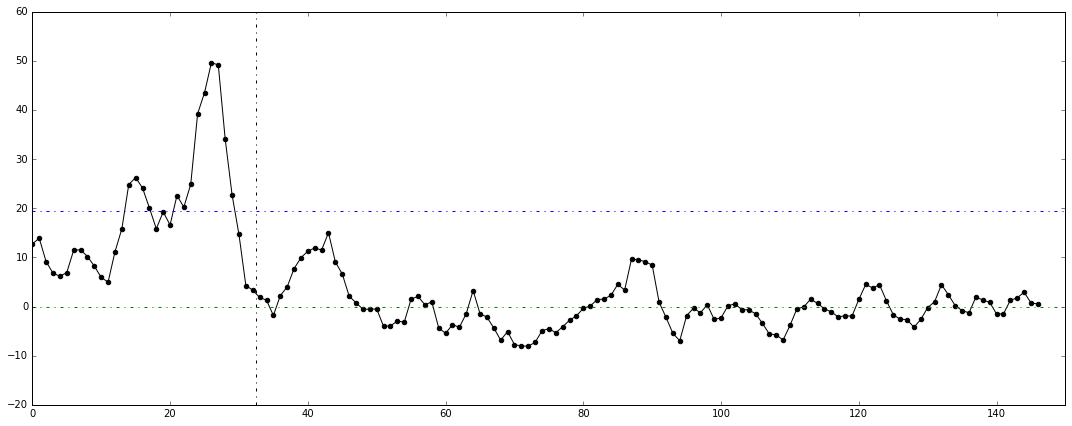

mean diff= 18.1571355292
sigma front = 9.3792819122
sigma end = 4.84120596314


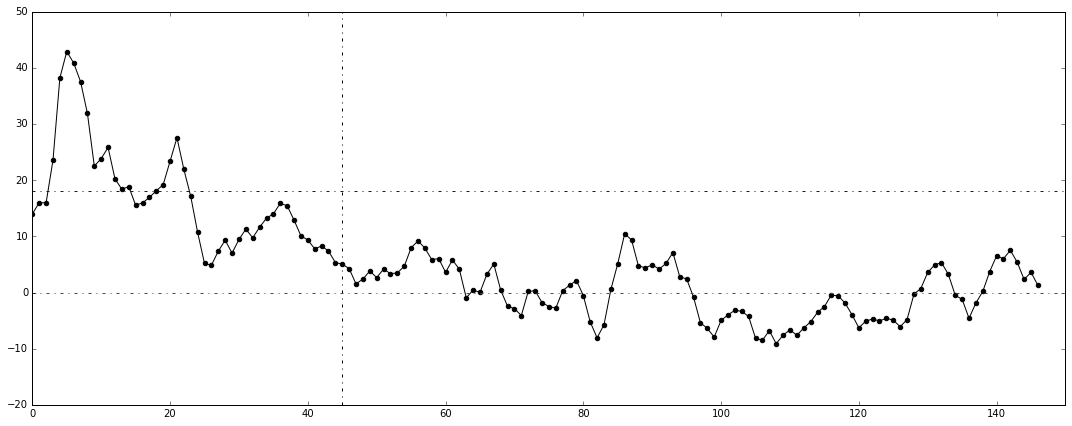

mean diff= 12.647779517
sigma front = 6.25153271634
sigma end = 0.691421544717


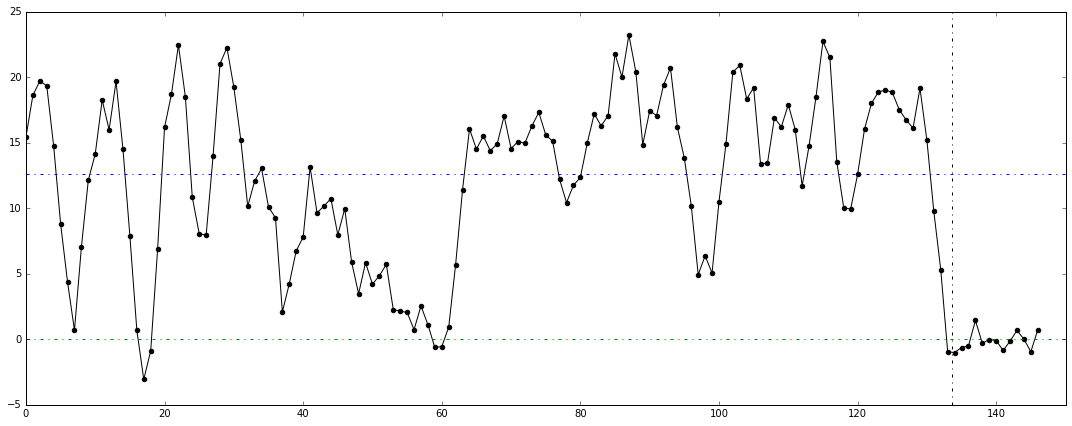

mean diff= 19.676925916
sigma front = 10.4469478626
sigma end = 4.97406313375


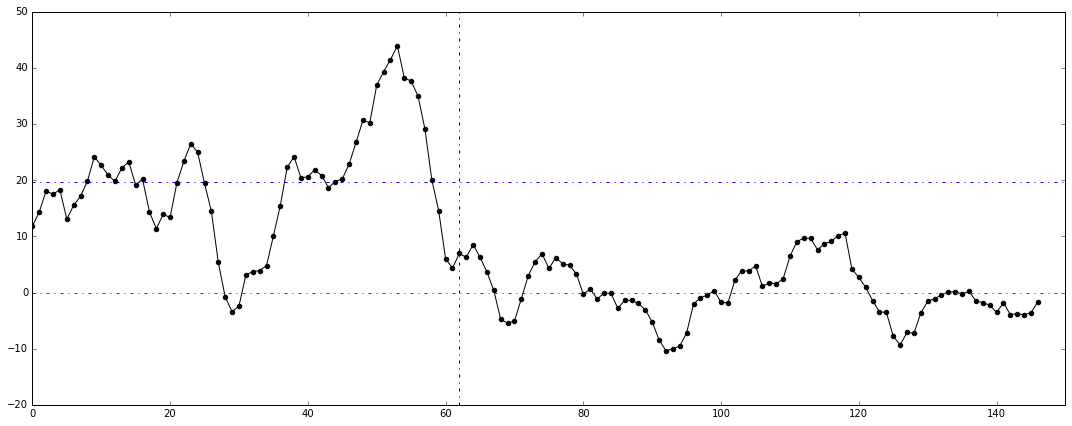

mean diff= 15.913360157
sigma front = 7.37804638351
sigma end = 3.24706687644


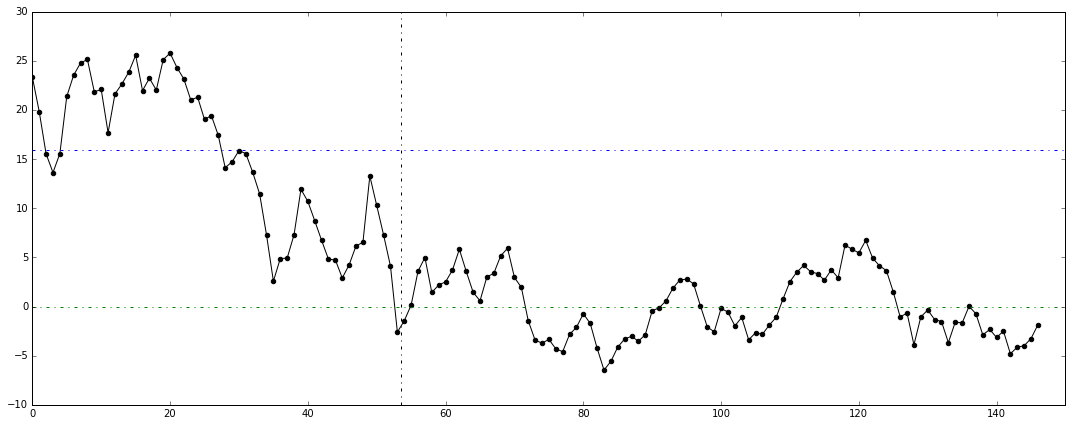

mean diff= 17.3648106505
sigma front = 7.05373273459
sigma end = 2.616264174


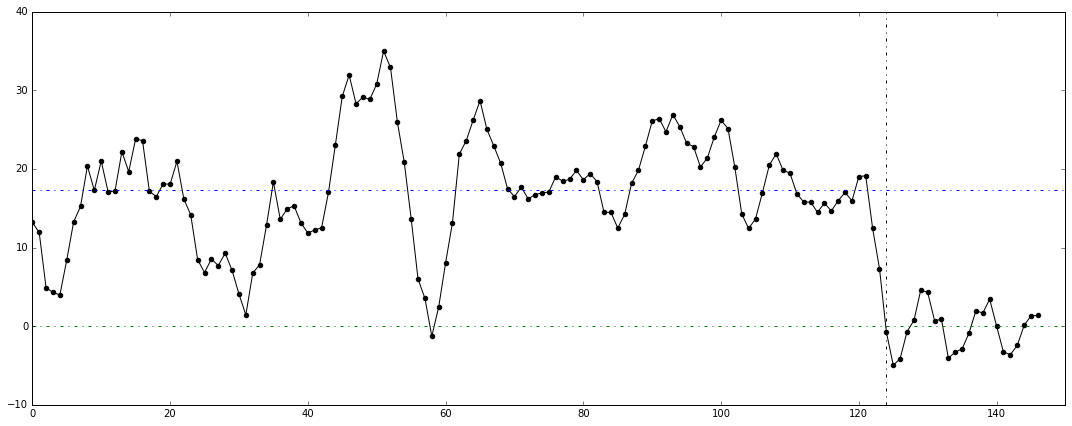

mean diff= 11.1874172409
sigma front = 3.95317091486
sigma end = 1.39077249607


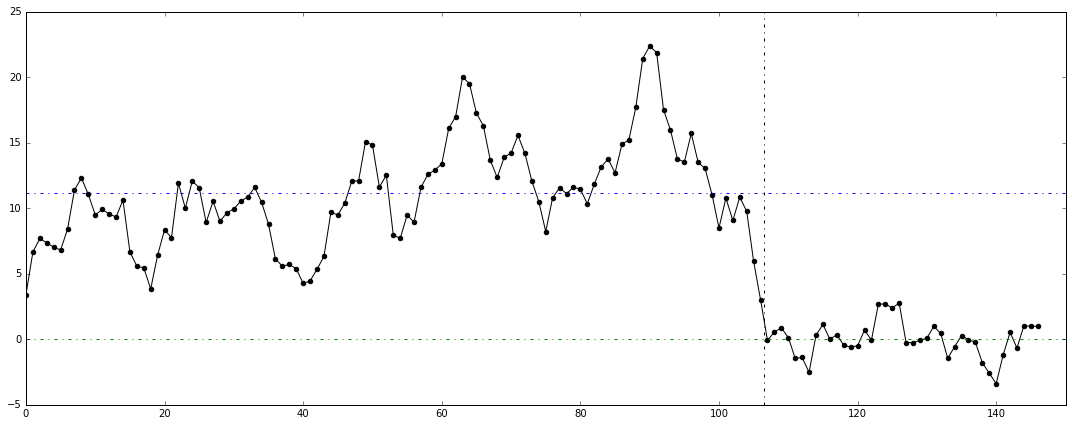

mean diff= 15.4636583424
sigma front = 6.96271406603
sigma end = 2.94546600176


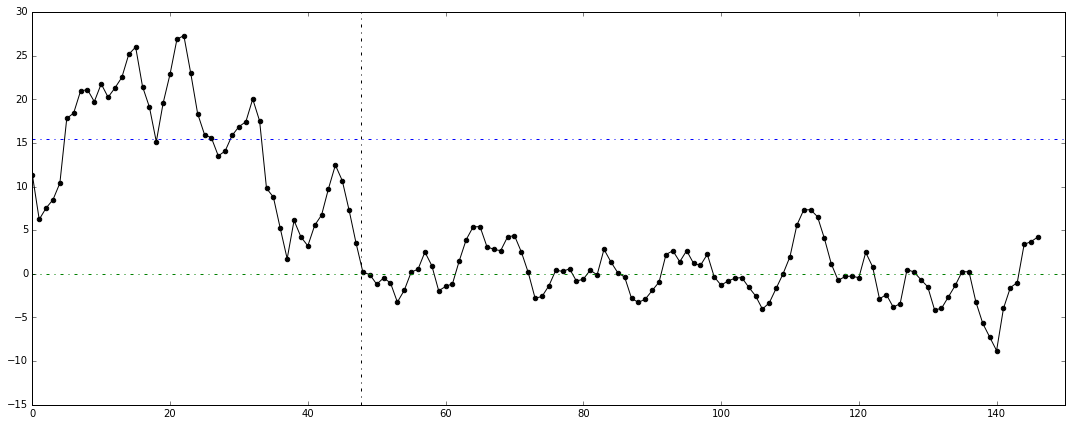

mean diff= 15.9057431047
sigma front = 5.71695815086
sigma end = 3.60659599921


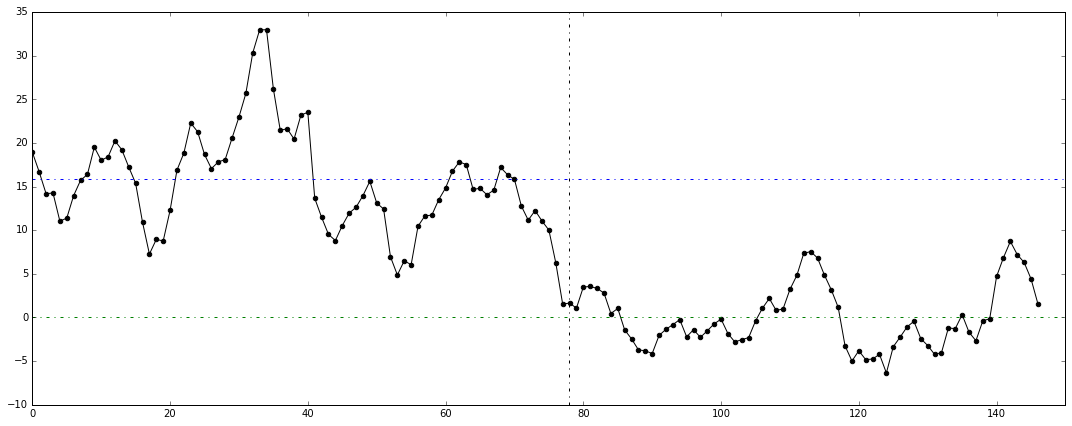

mean diff= 14.6483814995
sigma front = 5.93643911489
sigma end = 2.82792721406


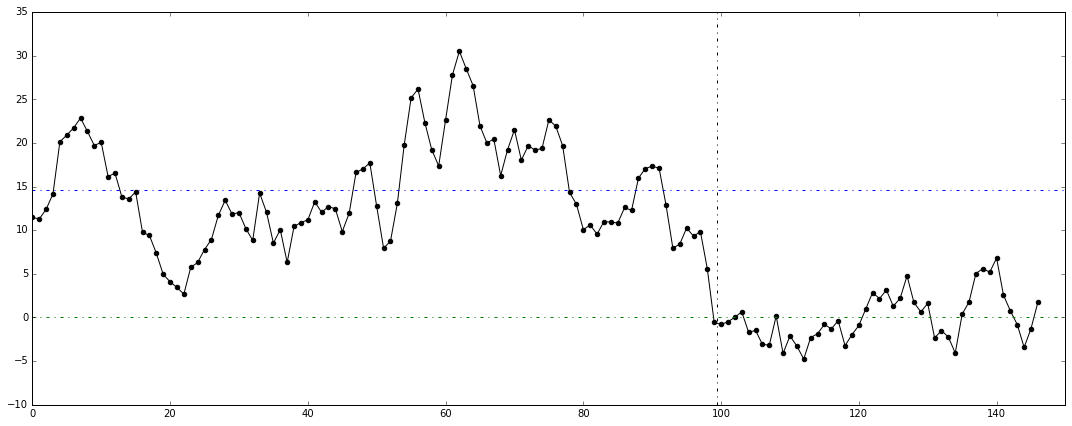

mean diff= 14.6610492397
sigma front = 3.80714130138
sigma end = 1.60413731969


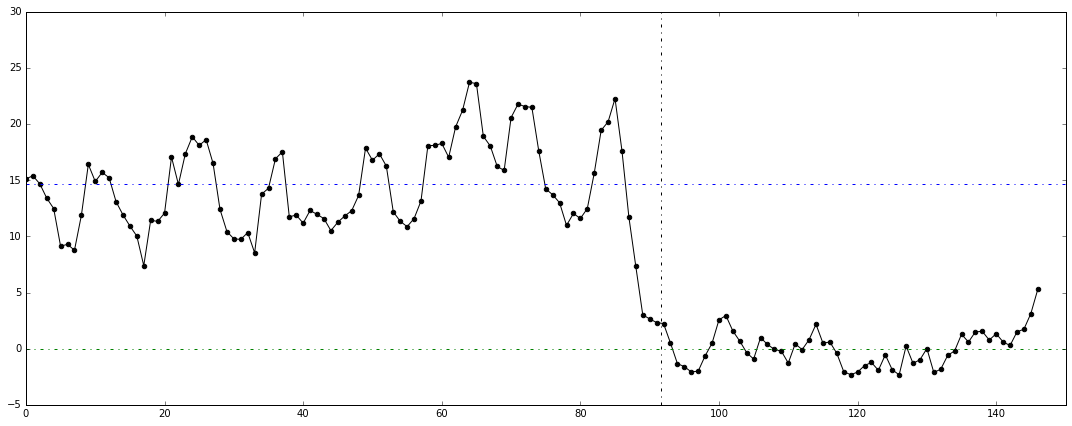

mean diff= 15.3953236607
sigma front = 1.64257500621
sigma end = 4.87285381739


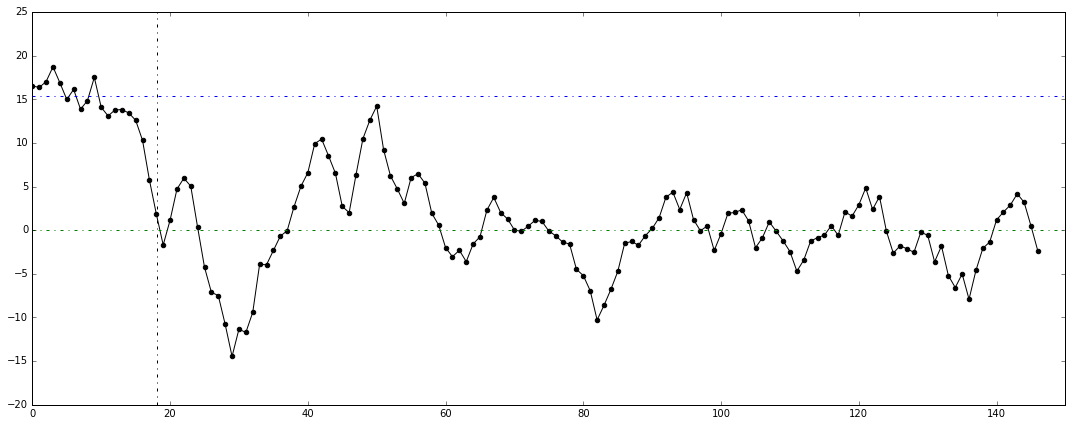

mean diff= 10.8485198798
sigma front = 2.83794992361
sigma end = 1.72268766631


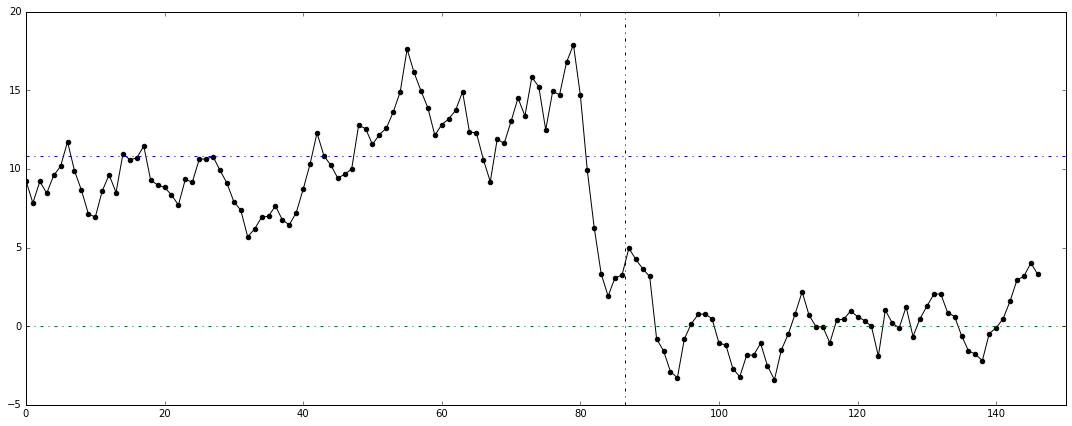

mean diff= 13.1405729245
sigma front = 7.32400664865
sigma end = 0.973140519735


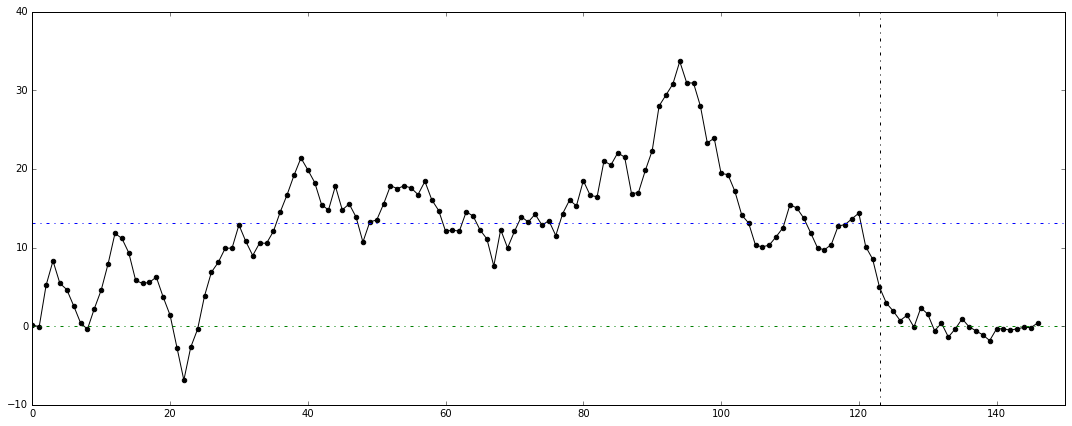

mean diff= 11.4433275706
sigma front = 8.33957061964
sigma end = 3.61524937461


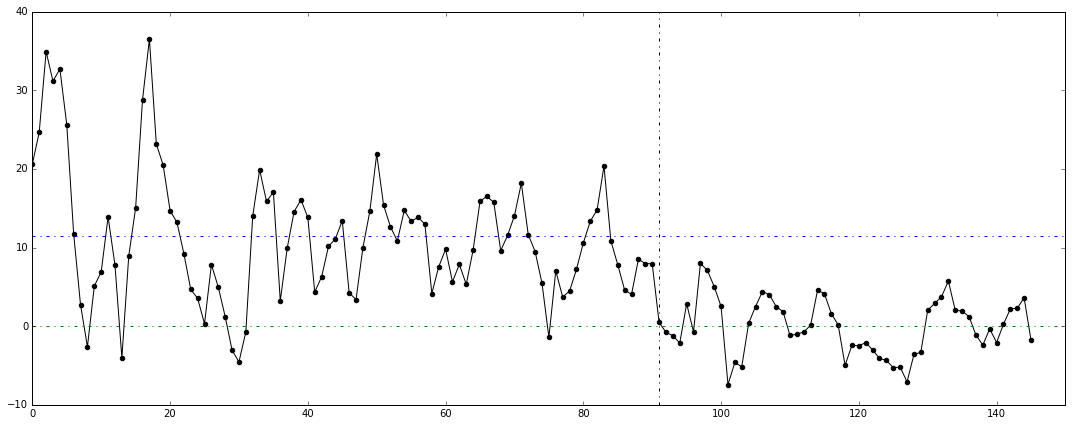

mean diff= 10.3020826873
sigma front = 8.89824095283
sigma end = 6.24928906845


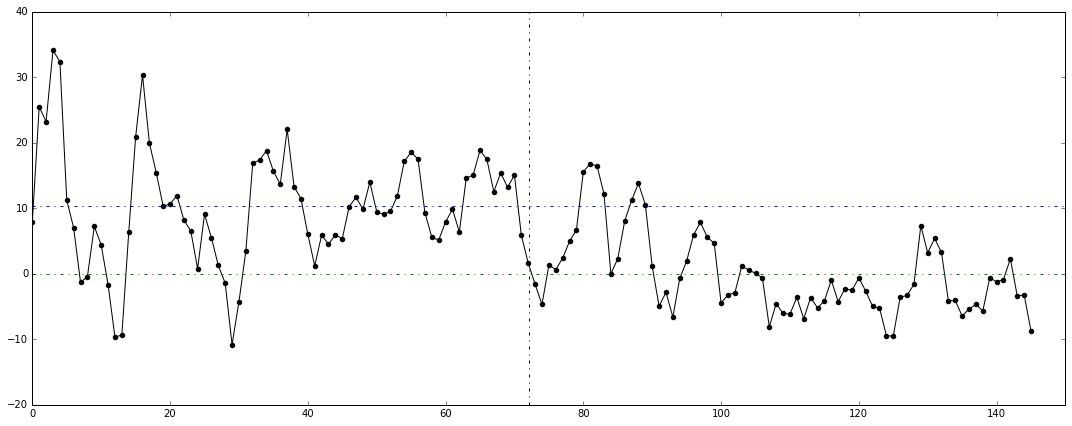

mean diff= 11.2960714124
sigma front = 8.93556510111
sigma end = 5.82002102686


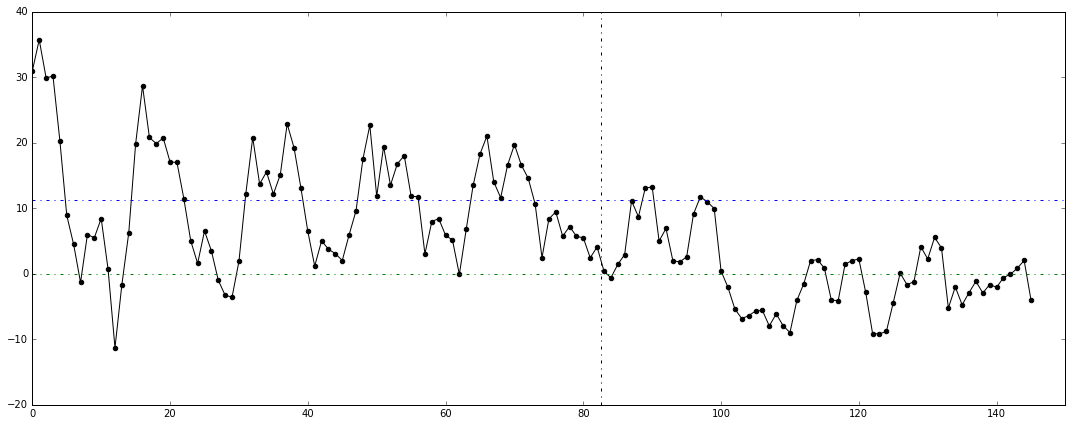

mean diff= 10.2502531955
sigma front = 8.39208545076
sigma end = 4.85800214485


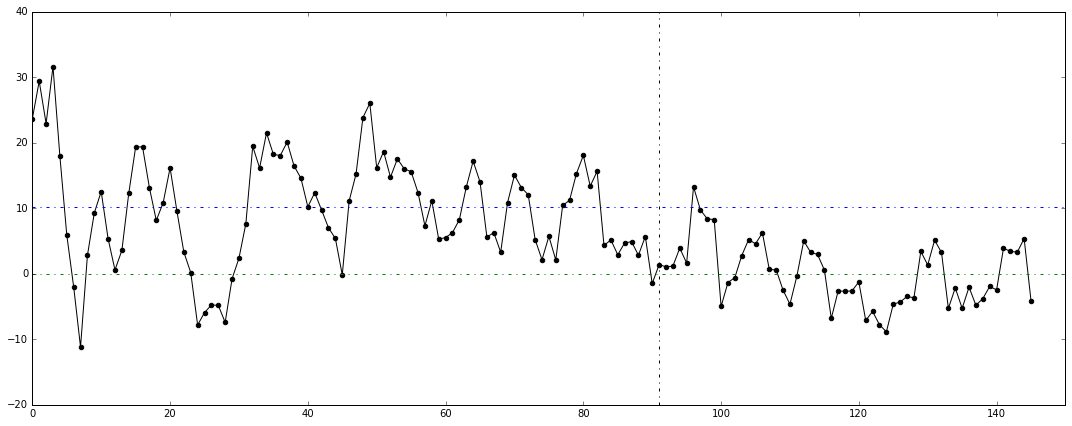

mean diff= 10.8732027464
sigma front = 8.1354507485
sigma end = 3.98133681139


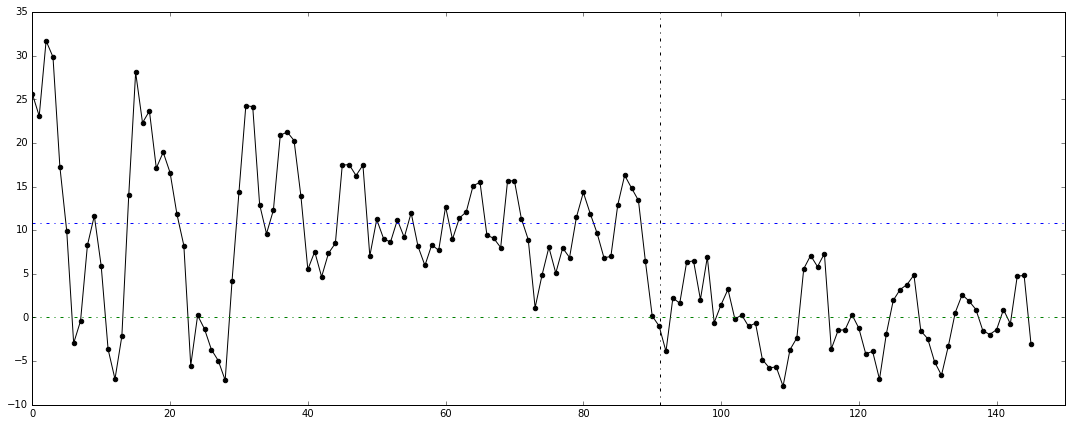

mean diff= 10.6605312459
sigma front = 8.36780959244
sigma end = 2.84197253859


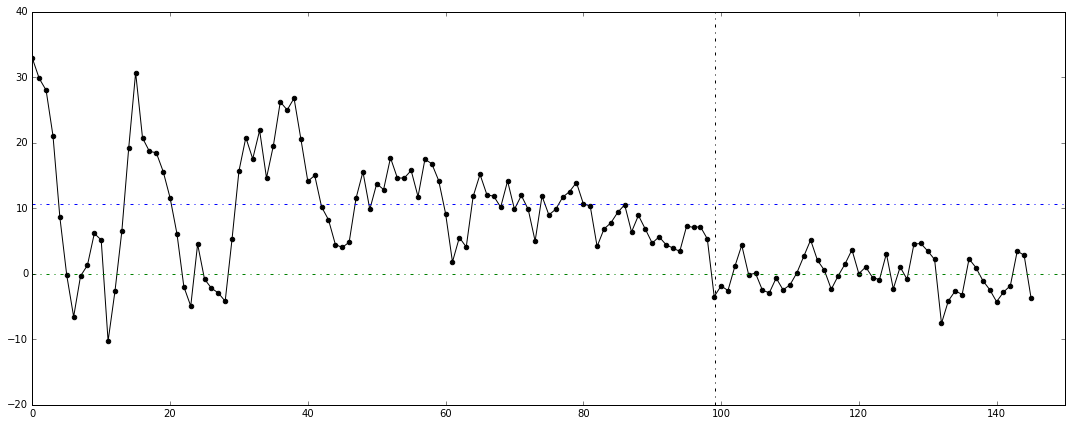

mean diff= 10.1269858586
sigma front = 7.55020529339
sigma end = 3.65390312862


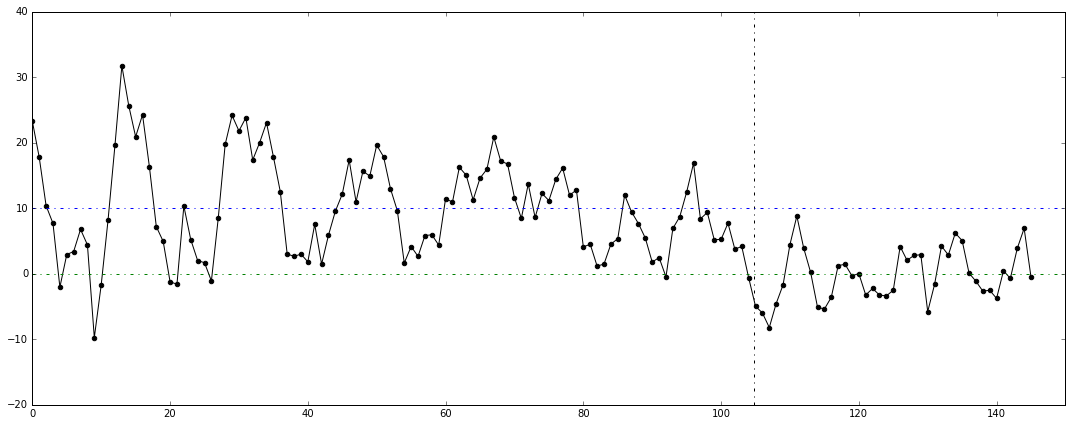

mean diff= 10.4523293012
sigma front = 8.70872223577
sigma end = 4.93876231838


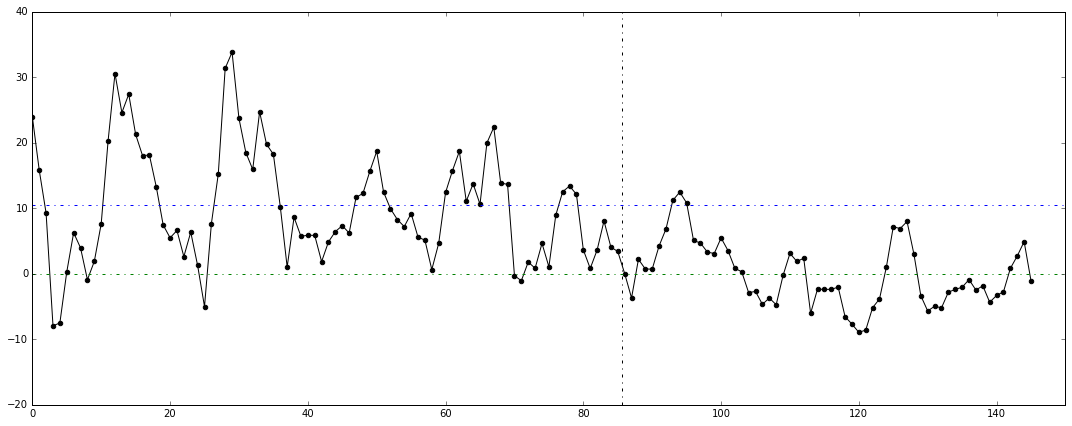

mean diff= 10.3368102315
sigma front = 8.34976429976
sigma end = 5.16577061524


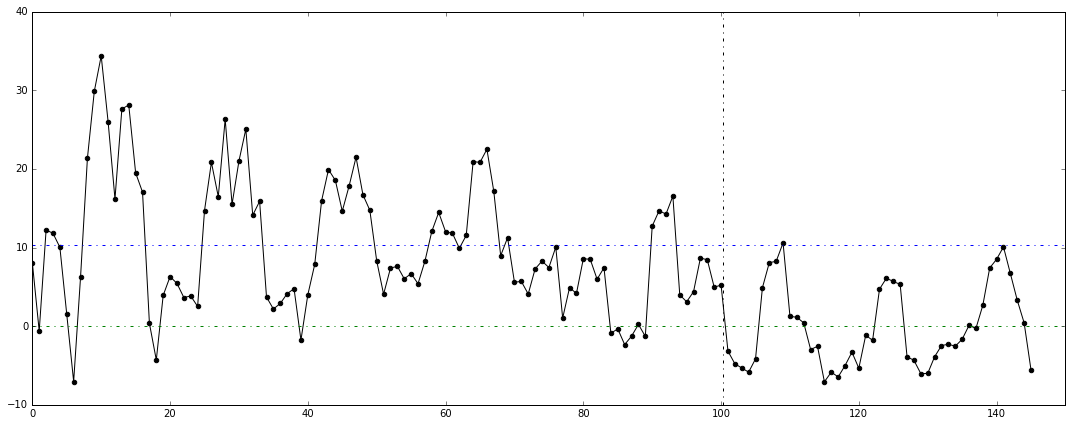

mean diff= 10.091946013
sigma front = 10.1573390843
sigma end = 4.64098967862


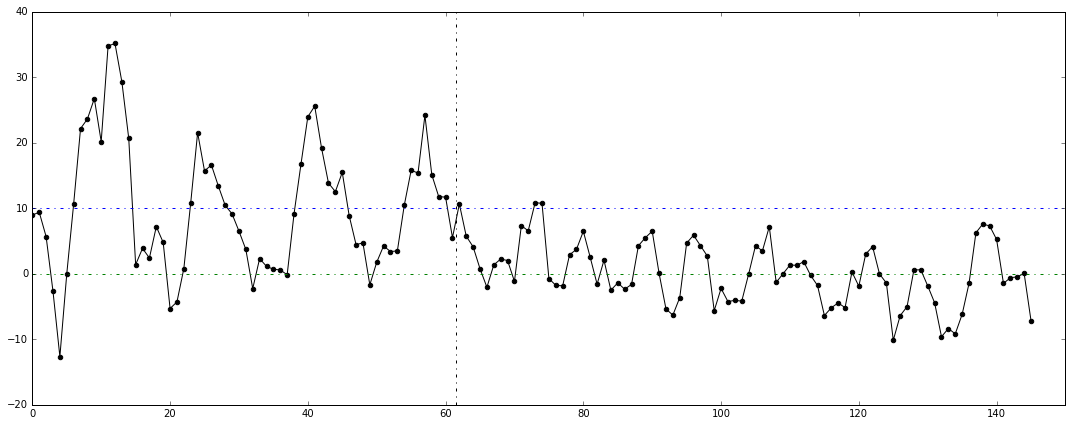

mean diff= 11.9443932773
sigma front = 9.18800210945
sigma end = 4.55526152392


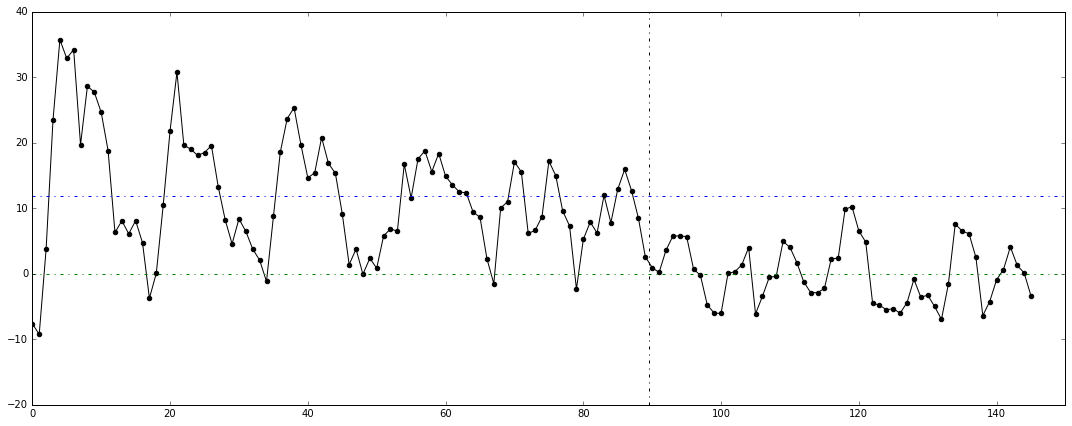

mean diff= 10.9752800285
sigma front = 3.05079980636
sigma end = 0.849319862062


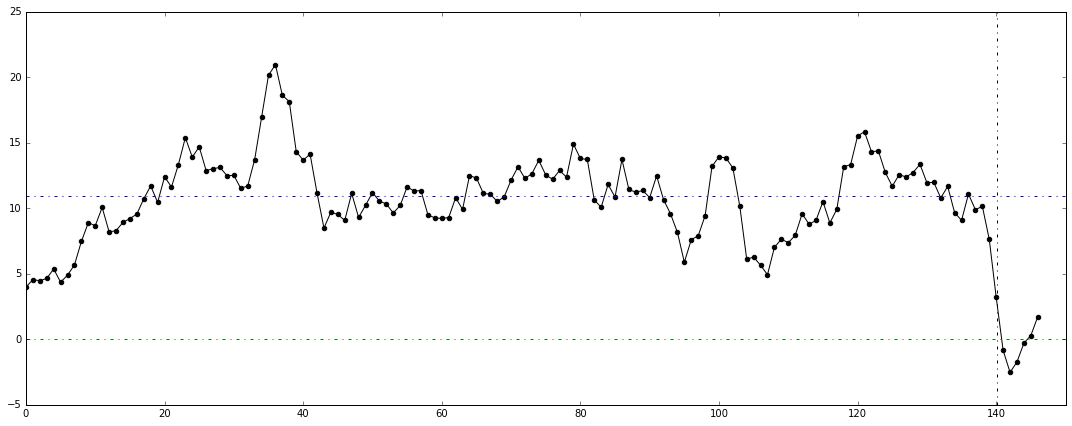

mean diff= 14.2334484936
sigma front = 6.39067920111
sigma end = 3.0749787466


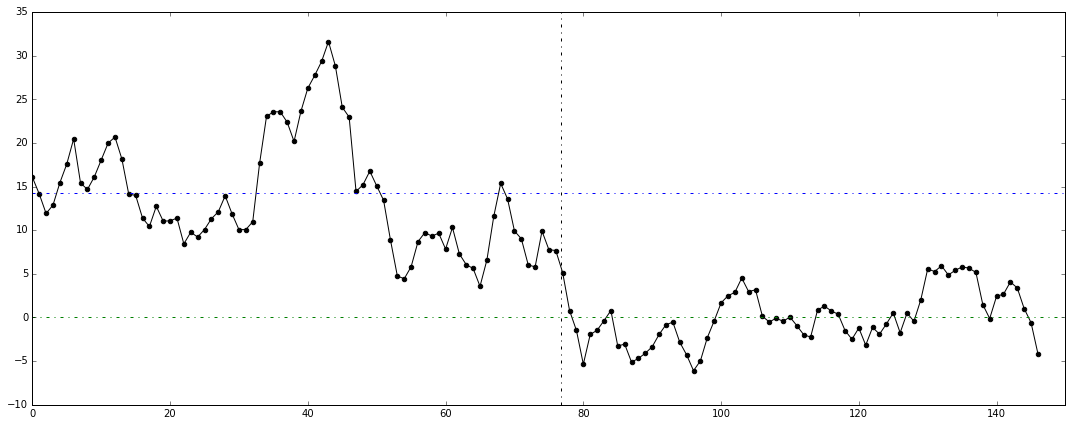

mean diff= 12.5440415382
sigma front = 3.45971823105
sigma end = 1.78142372569


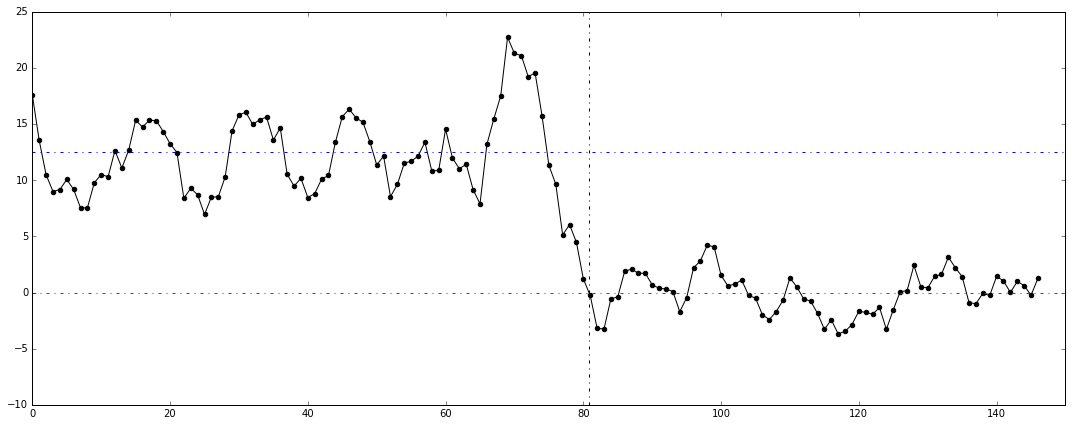

mean diff= 19.8681349048
sigma front = 5.88468129125
sigma end = 2.63831761468


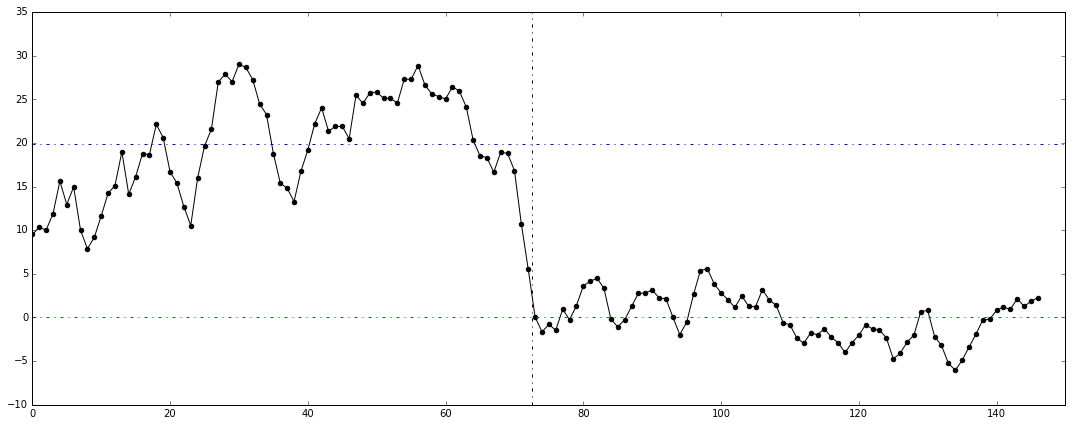

mean diff= 11.0715204384
sigma front = 3.49374409833
sigma end = 2.73644040907


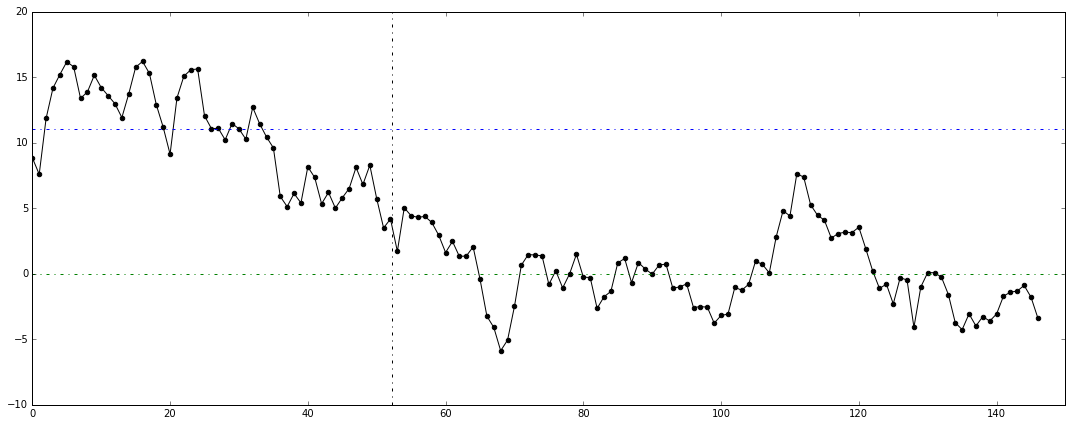

mean diff= 19.3818319905
sigma front = 14.0342129359
sigma end = 2.56760301952


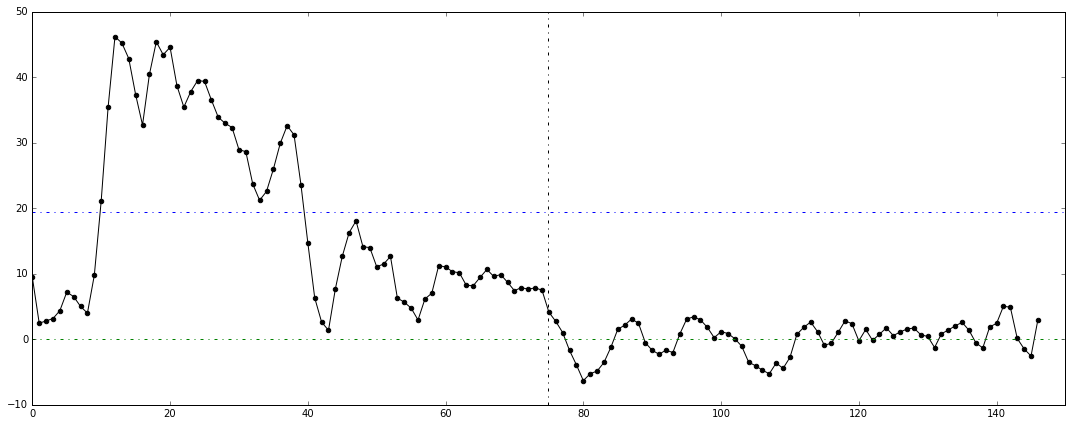

mean diff= 10.1485149802
sigma front = 7.79980385453
sigma end = 4.54385812811


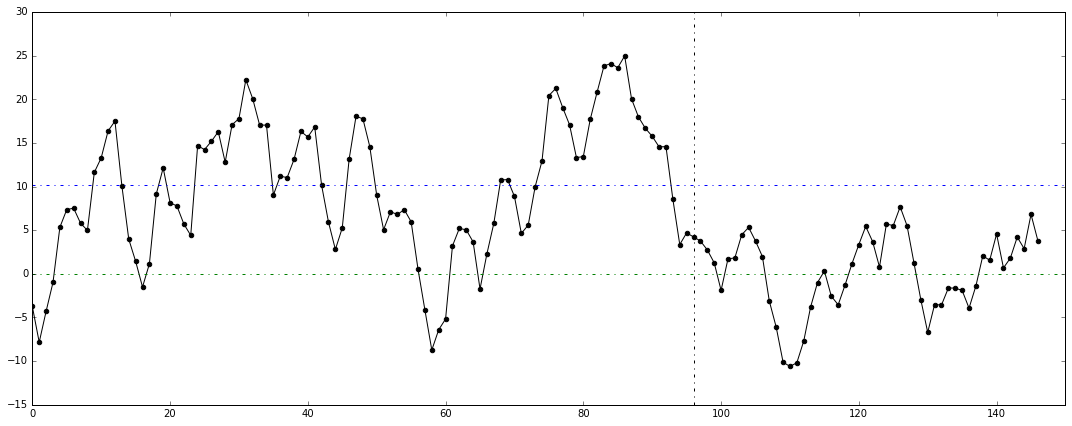

mean diff= 15.9156336539
sigma front = 7.95532275895
sigma end = 3.8948284046


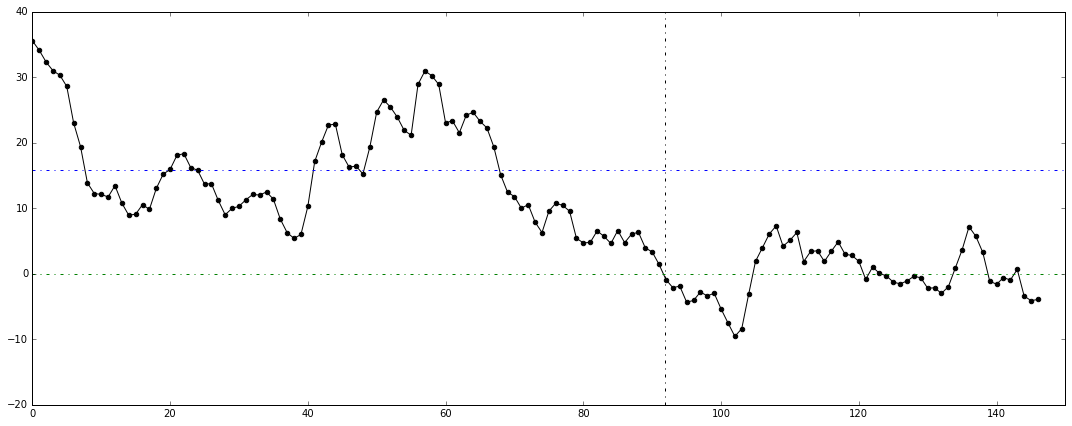

mean diff= 13.5378390595
sigma front = 2.94411206206
sigma end = 2.40403025288


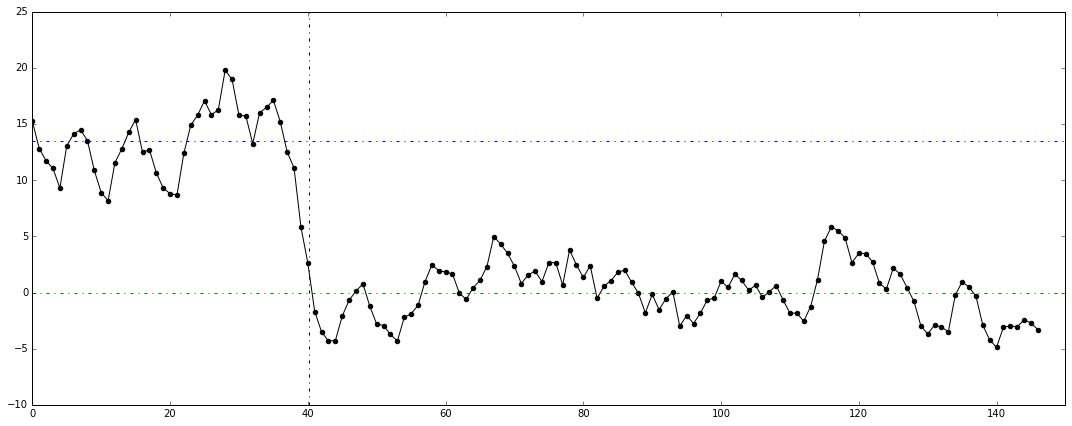

mean diff= 13.6385954779
sigma front = 4.04256450367
sigma end = 2.26173064163


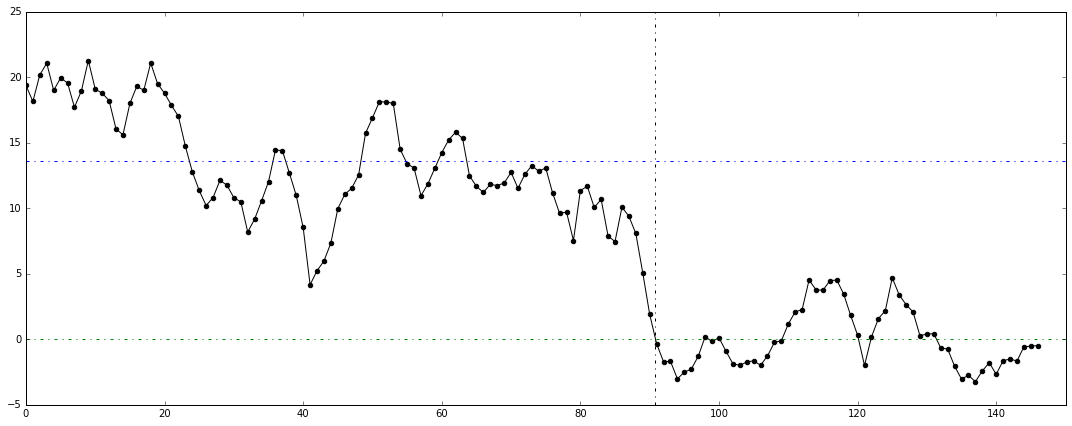

mean diff= 17.6297495198
sigma front = 6.07970591511
sigma end = 12.7642219359


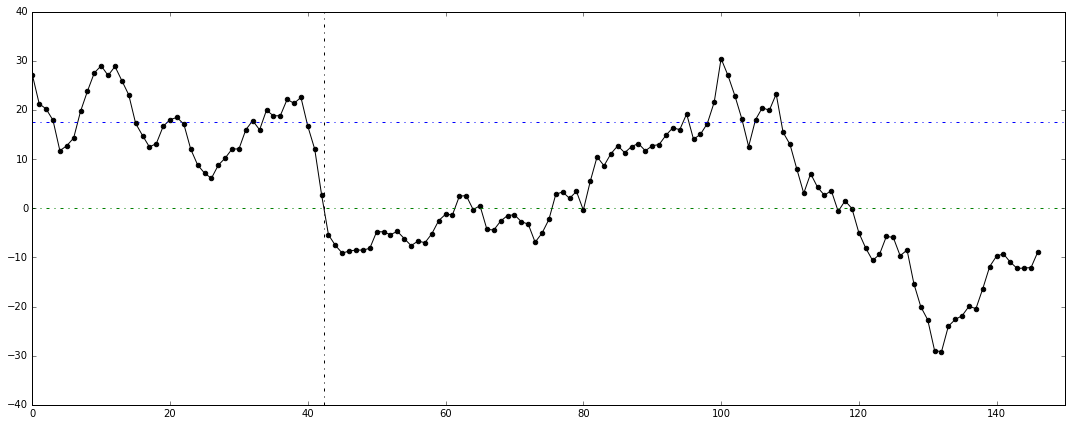

mean diff= 16.6722385015
sigma front = 9.29261224642
sigma end = 2.97944056921


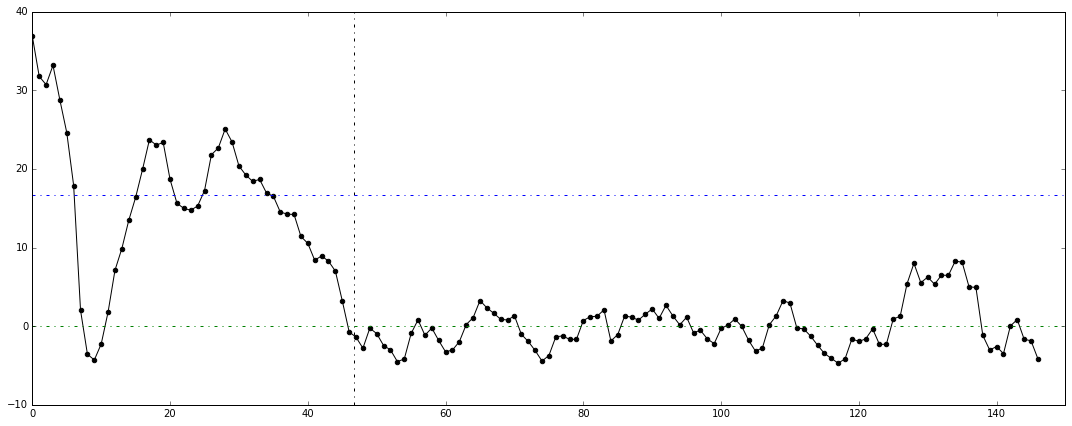

mean diff= 12.9486192168
sigma front = 10.3449561055
sigma end = 2.61916145401


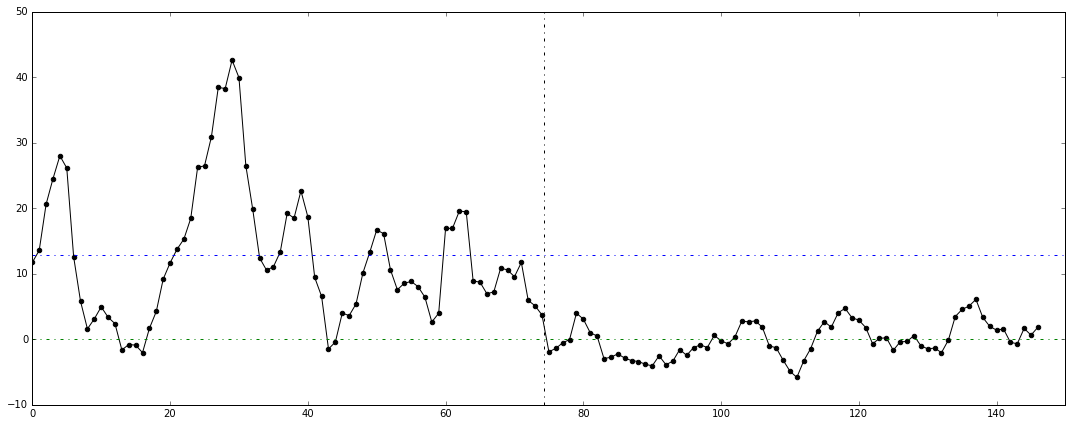

mean diff= 11.4114537559
sigma front = 6.26945755588
sigma end = 3.21757883669


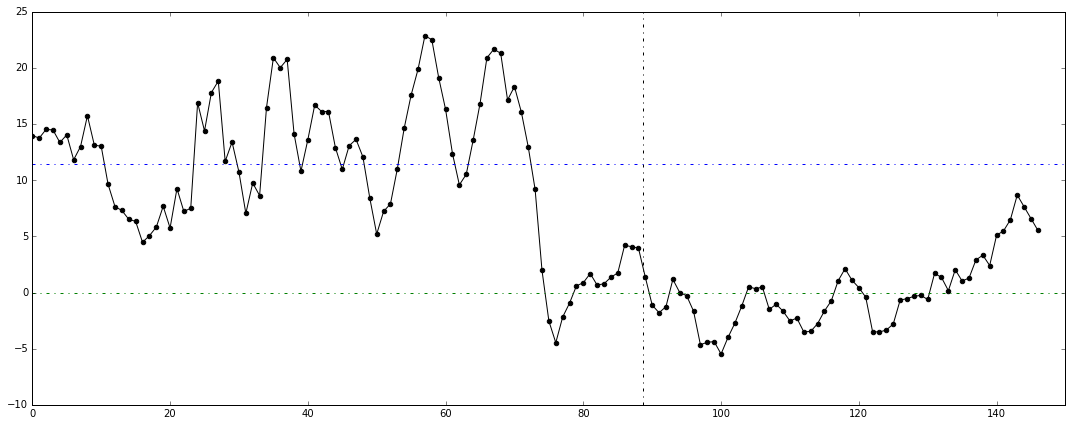

mean diff= 13.6619755185
sigma front = 5.68400496604
sigma end = 5.50169570735


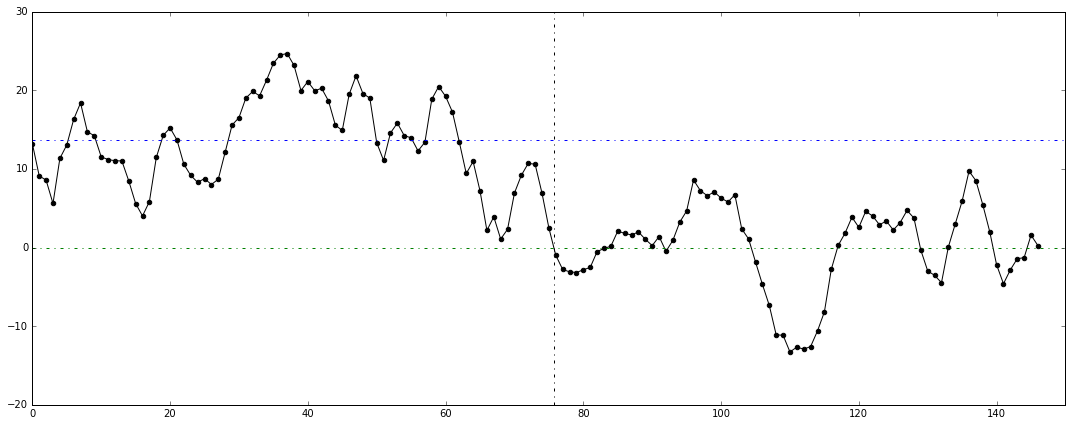

mean diff= 16.5233532061
sigma front = 4.00913430624
sigma end = 1.98971208111


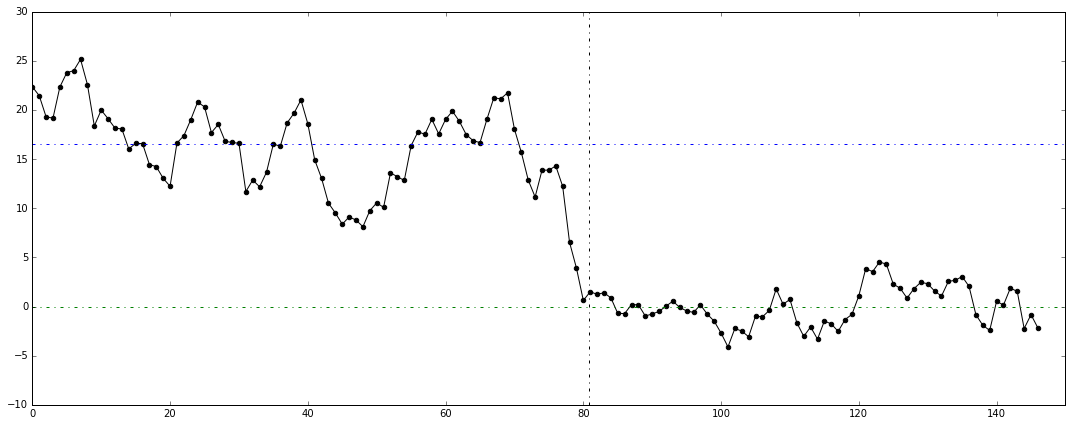

mean diff= 10.8989072379
sigma front = 5.62975855195
sigma end = 3.67975208664


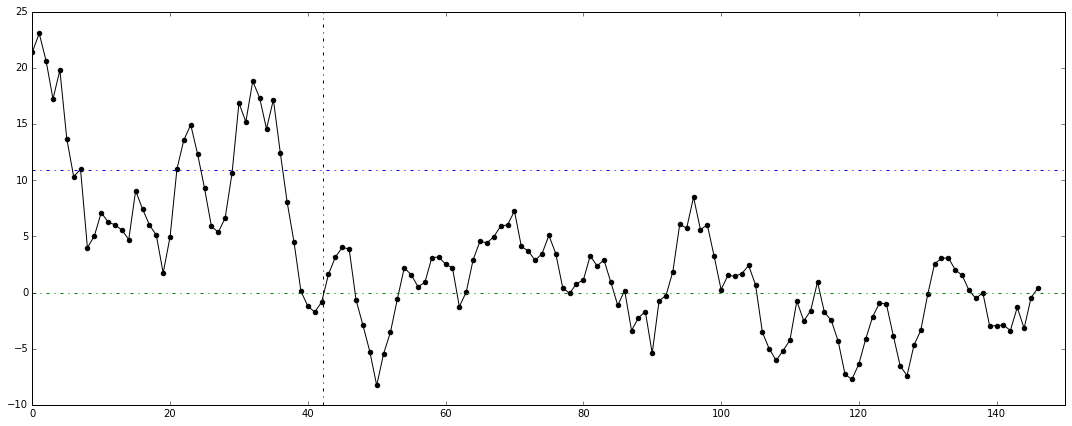

mean diff= 11.2569373706
sigma front = 1.16038329423
sigma end = 2.3188442326


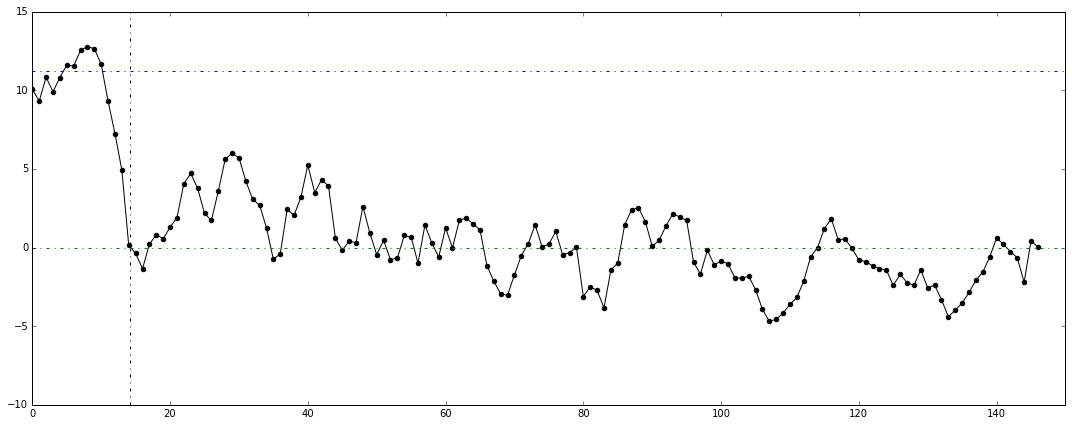

mean diff= 13.3498878432
sigma front = 1.99791206535
sigma end = 3.61105802505


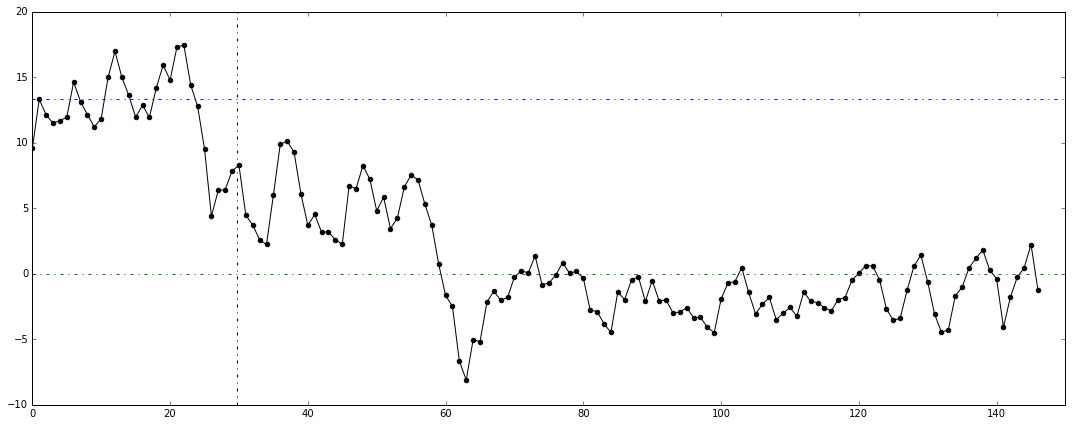

mean diff= 10.9365779934
sigma front = 2.47977219007
sigma end = 2.48850912688


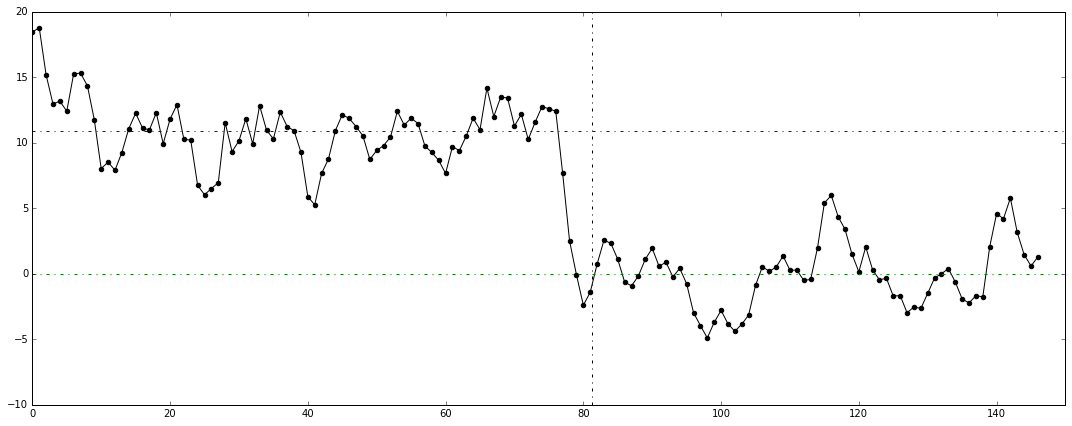

mean diff= 12.6169084046
sigma front = 3.43471586426
sigma end = 1.87825438289


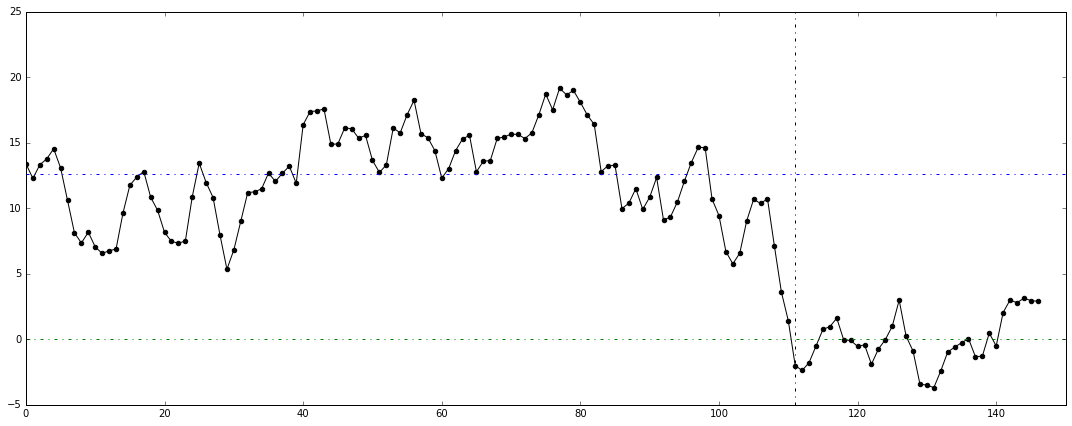

mean diff= 17.3384249103
sigma front = 6.02497223327
sigma end = 10.7176487761


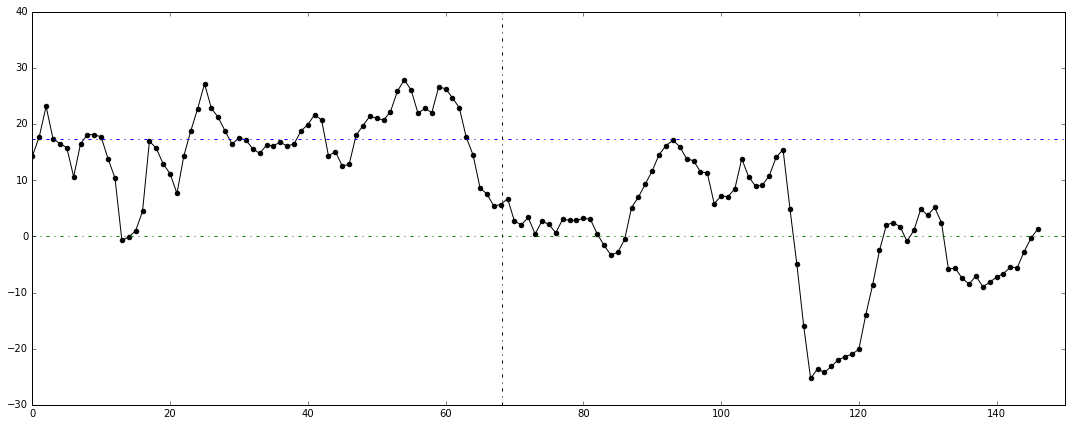

mean diff= 12.3525886346
sigma front = 2.0241312283
sigma end = 2.69052316029


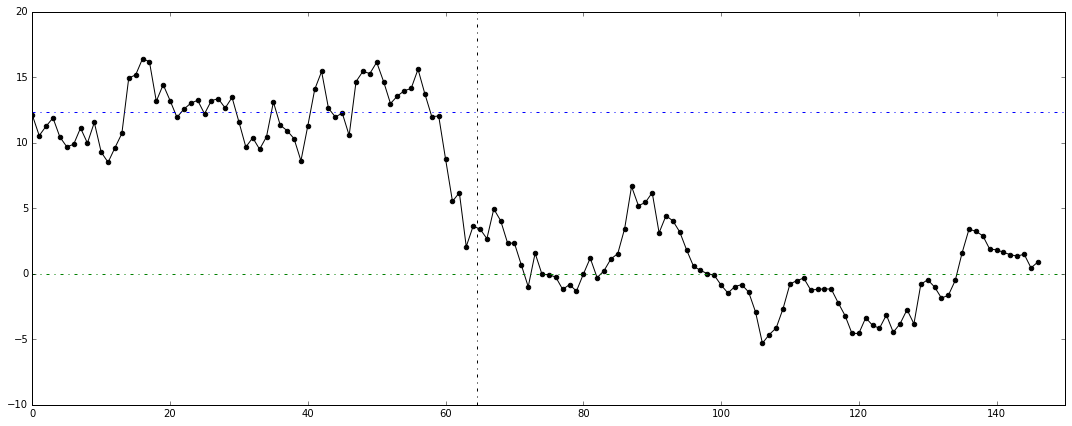

mean diff= 11.9156137644
sigma front = 7.59782096878
sigma end = 6.78292074409


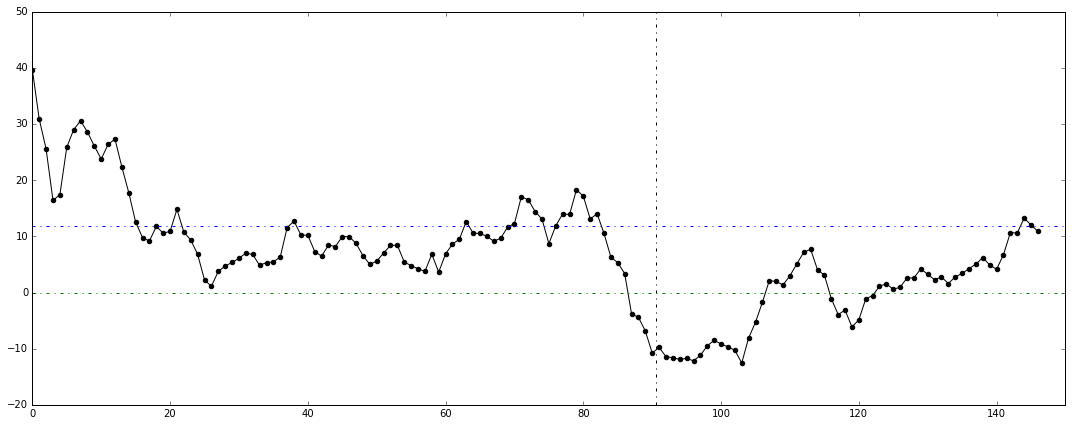

mean diff= 11.8071733101
sigma front = 5.8221476337
sigma end = 5.3591888582


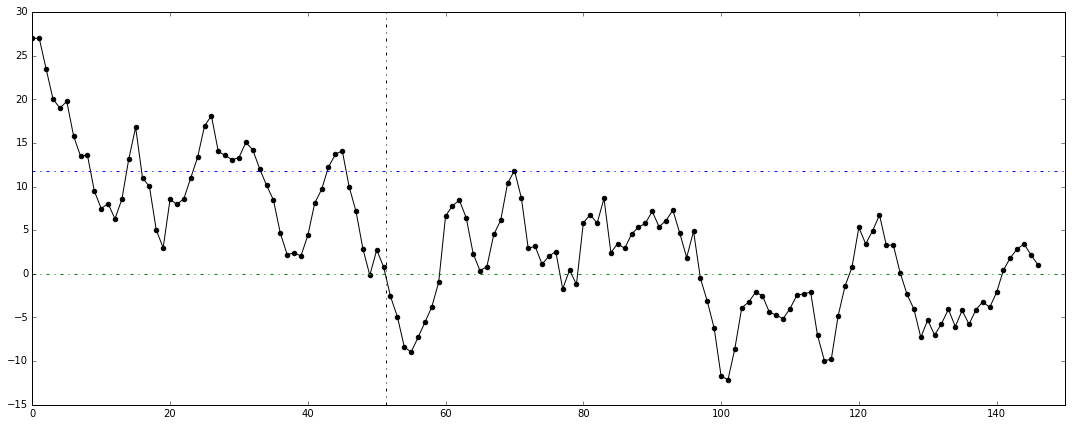

mean diff= 18.2756911075
sigma front = 4.34920255888
sigma end = 2.03769904515


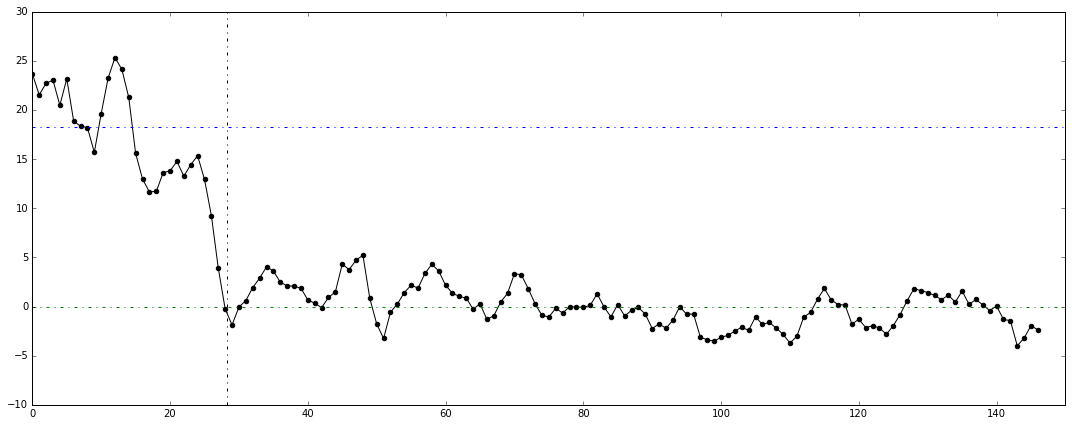

mean diff= 16.7746681028
sigma front = 7.63579213073
sigma end = 4.23685300717


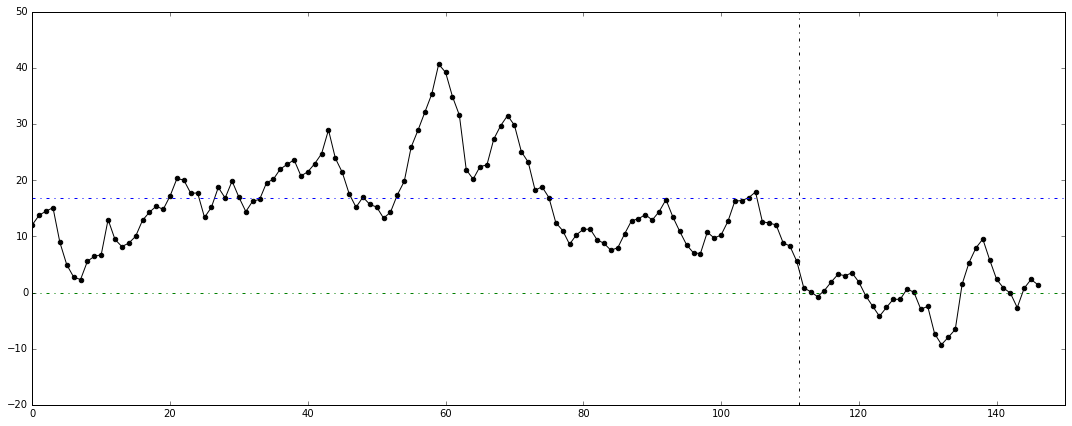

mean diff= 14.0269508278
sigma front = 9.08840219027
sigma end = 4.00785940145


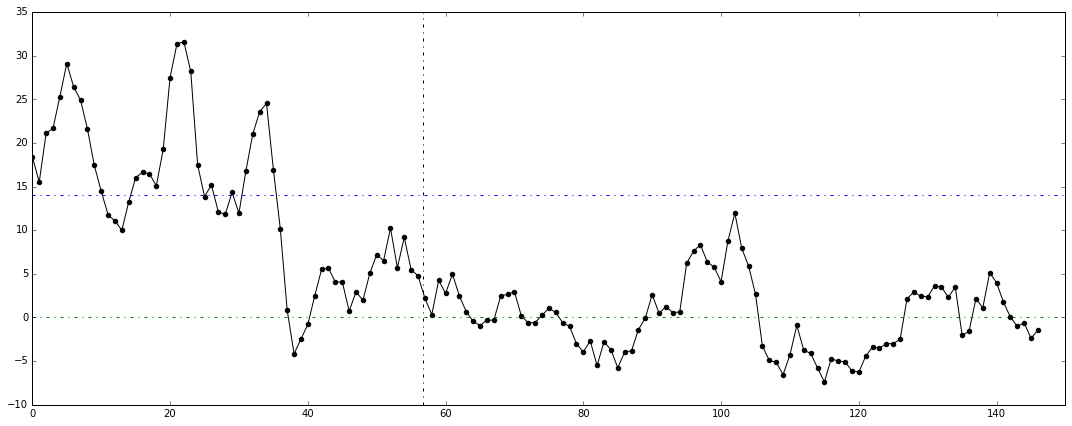

mean diff= 14.5621924228
sigma front = 4.42321944293
sigma end = 4.96815595886


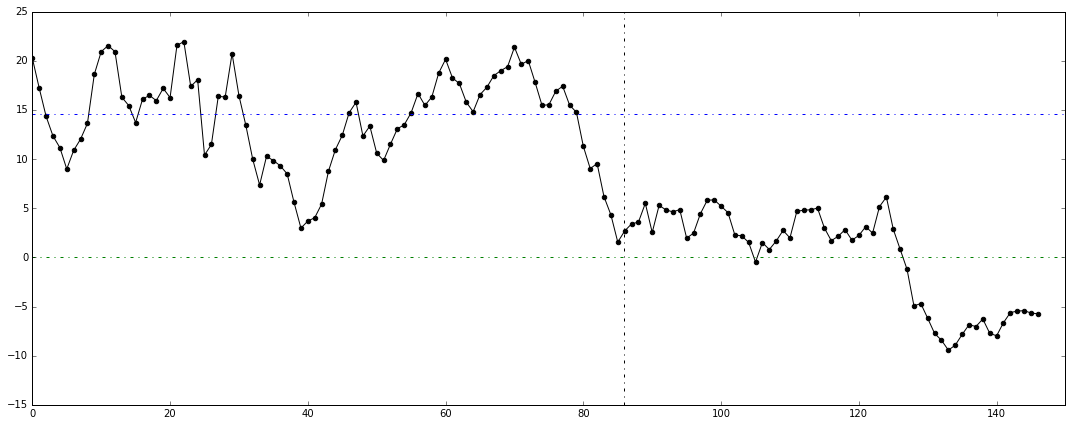

mean diff= 13.1563841771
sigma front = 1.9471438207
sigma end = 2.91825457584


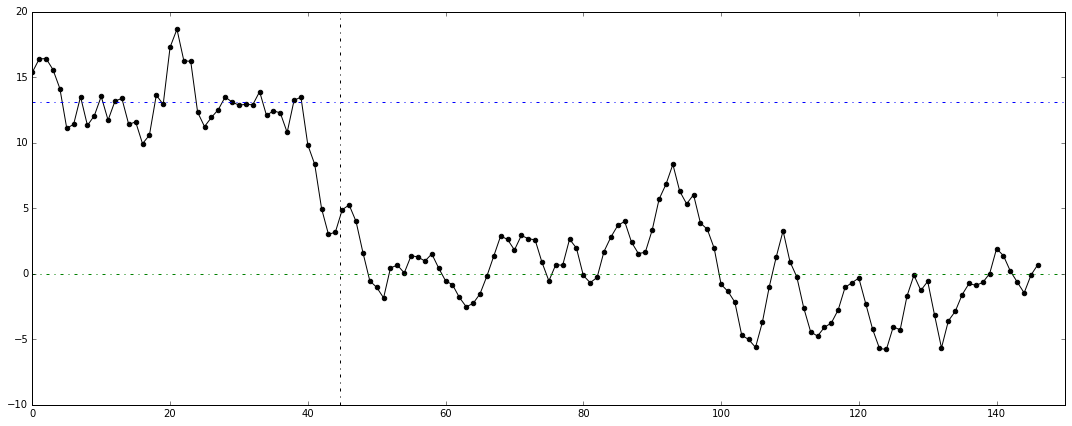

mean diff= 15.0678851636
sigma front = 5.86746402451
sigma end = 4.91374672171


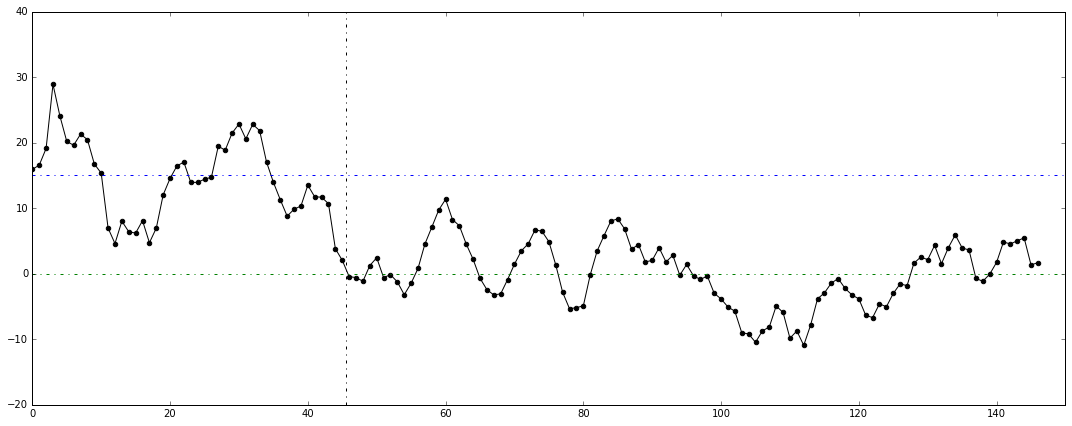

mean diff= 10.7451233085
sigma front = 5.15165586838
sigma end = 2.33557064517


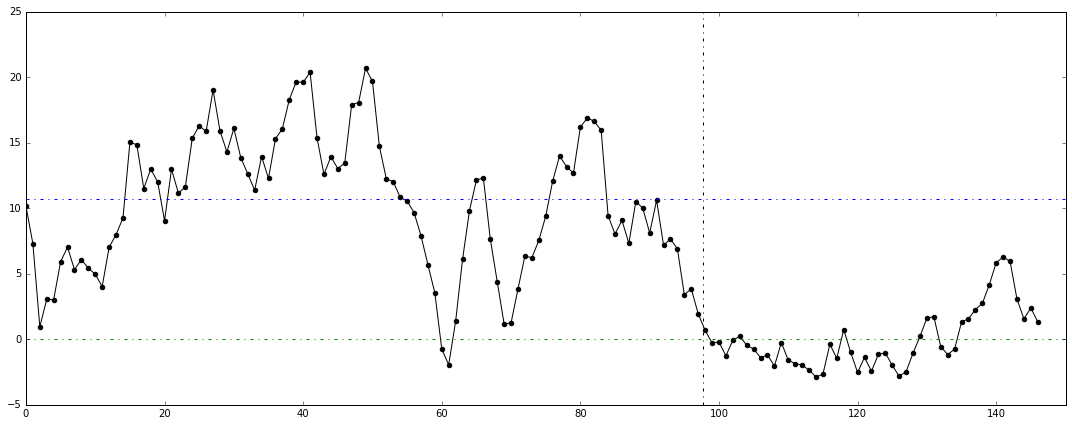

mean diff= 12.4545859184
sigma front = 3.81793957698
sigma end = 1.68375996066


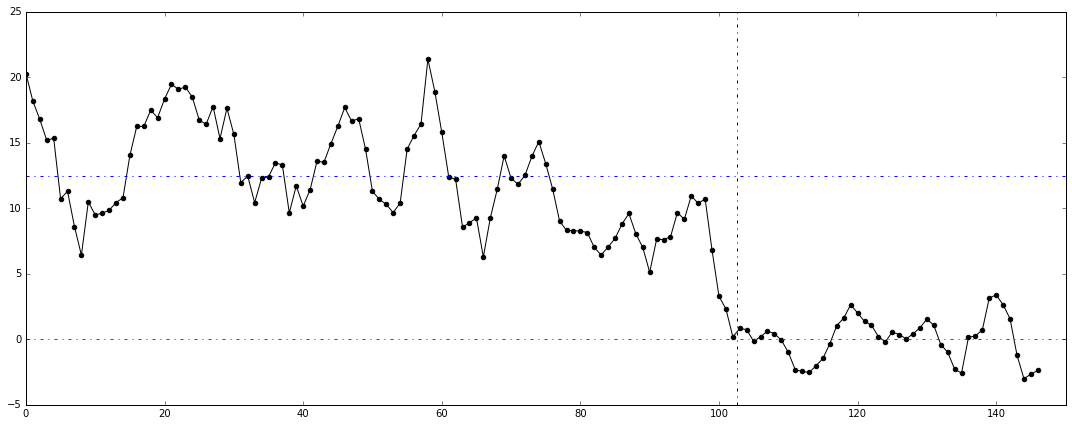

mean diff= 16.9370921118
sigma front = 7.06834243855
sigma end = 5.49820234587


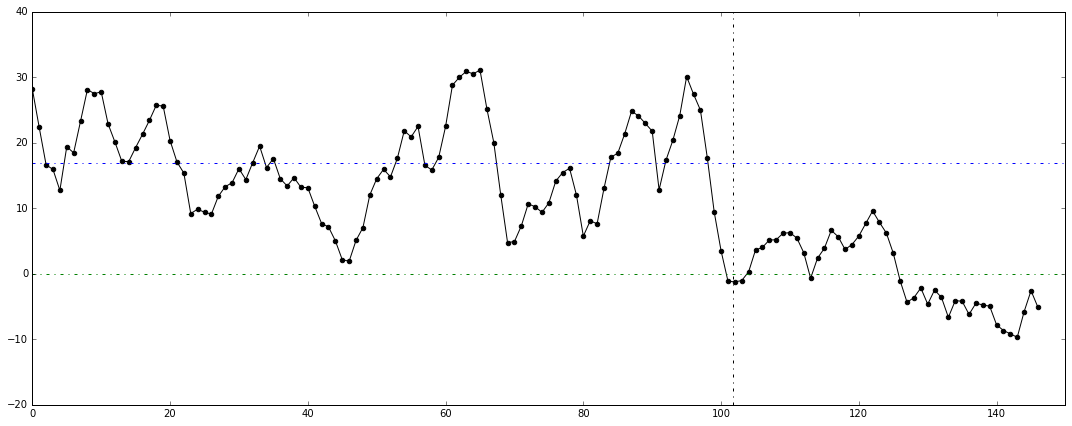

mean diff= 16.8682478714
sigma front = 3.80079482606
sigma end = 5.42167908601


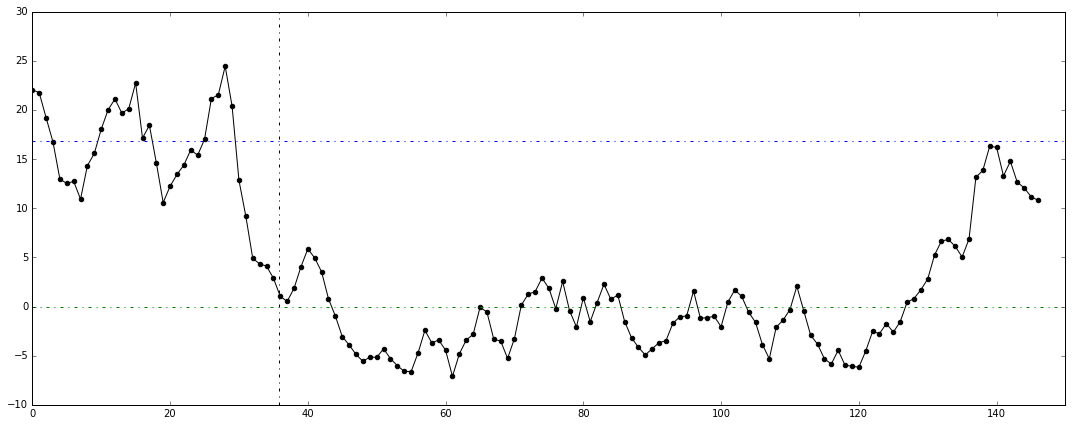

mean diff= 17.5575968804
sigma front = 5.77173171362
sigma end = 5.28590719795


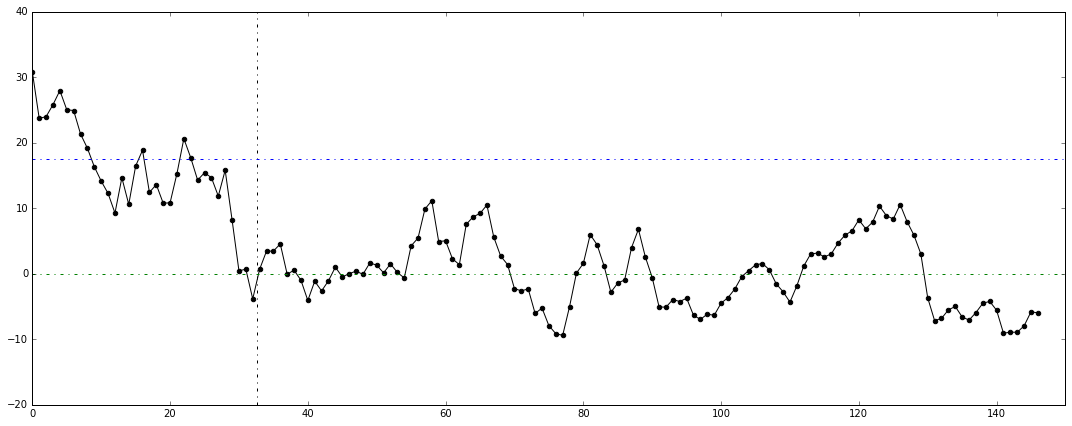

mean diff= 15.5820042035
sigma front = 2.74940195669
sigma end = 2.67037523719


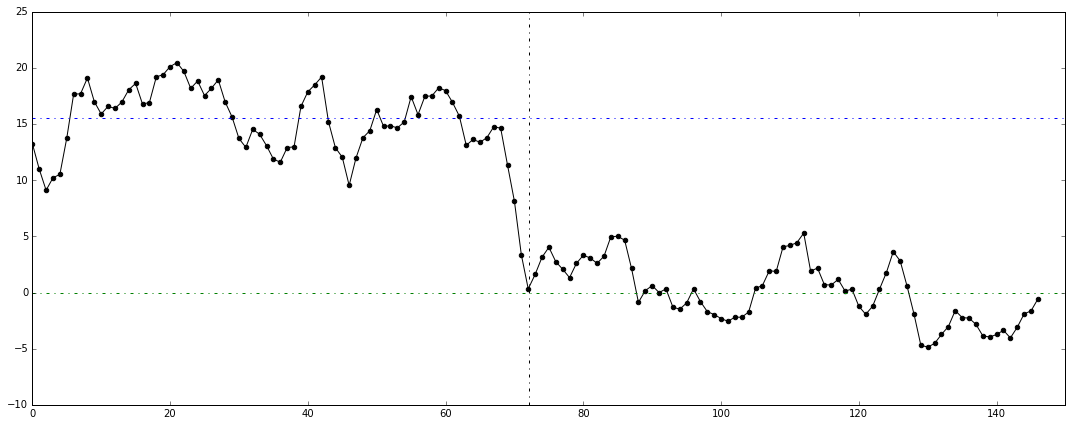

mean diff= 13.5754990991
sigma front = 4.63453204936
sigma end = 2.55195436455


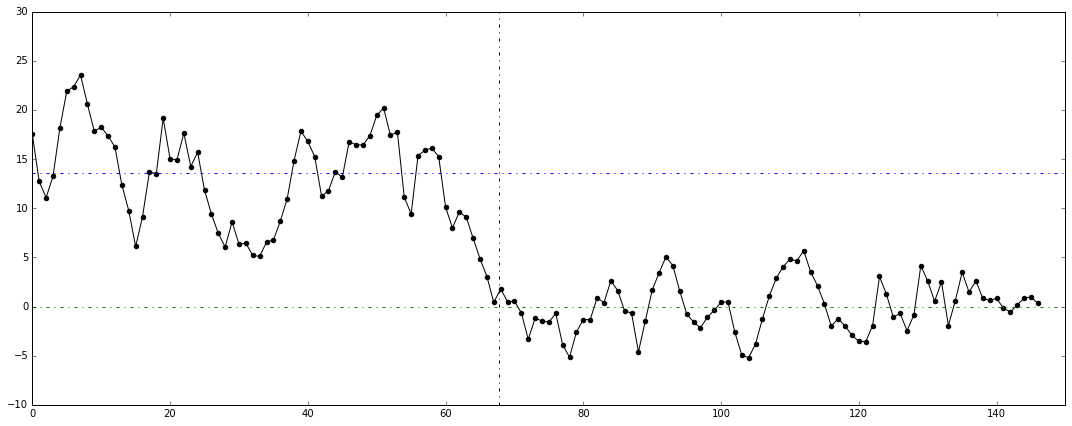

mean diff= 10.0397209667
sigma front = 4.39967581622
sigma end = 2.63983322486


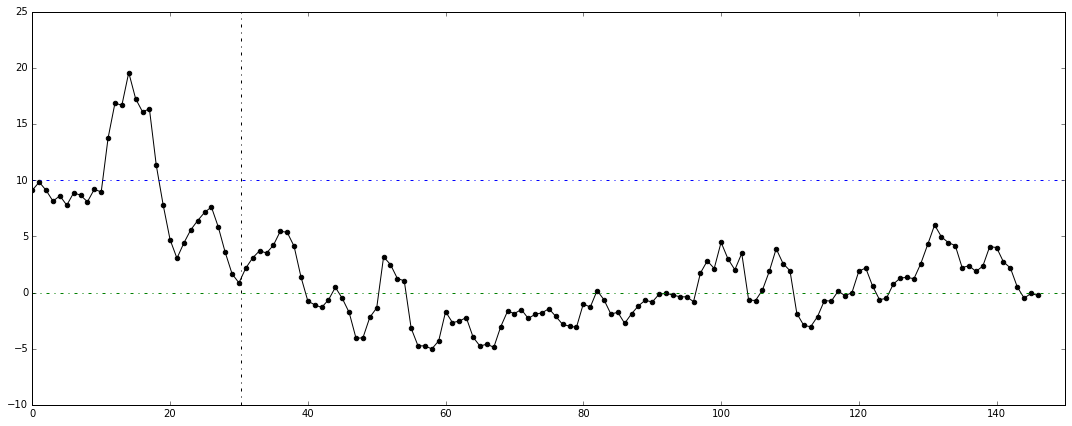

mean diff= 13.3282990925
sigma front = 7.0958702026
sigma end = 1.51004365089


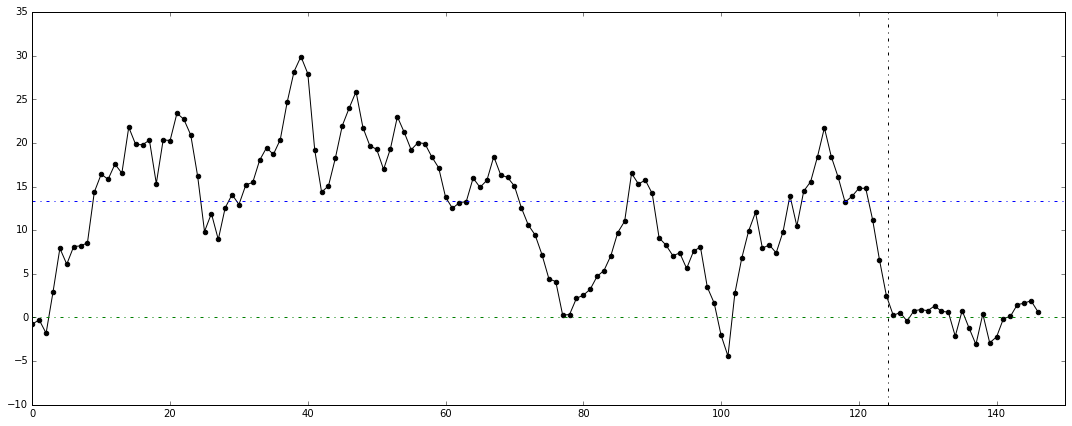

mean diff= 10.2959575365
sigma front = 3.23396034912
sigma end = 3.15921554006


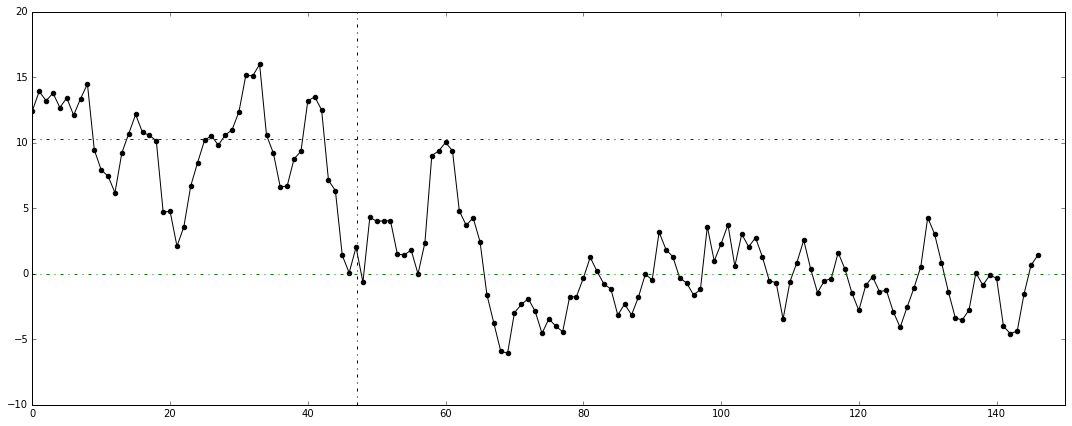

mean diff= 14.8071342606
sigma front = 7.85884341729
sigma end = 3.91792707777


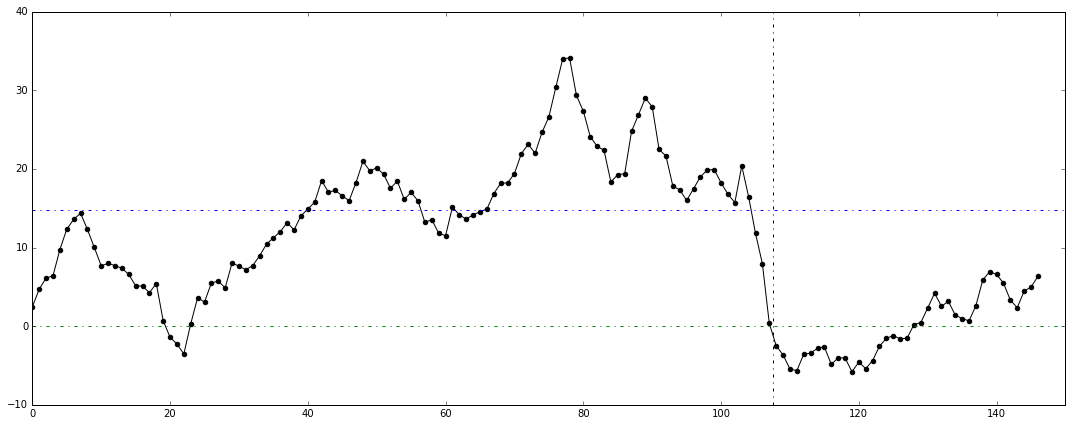

mean diff= 13.5417815825
sigma front = 6.39286934264
sigma end = 2.85967224802


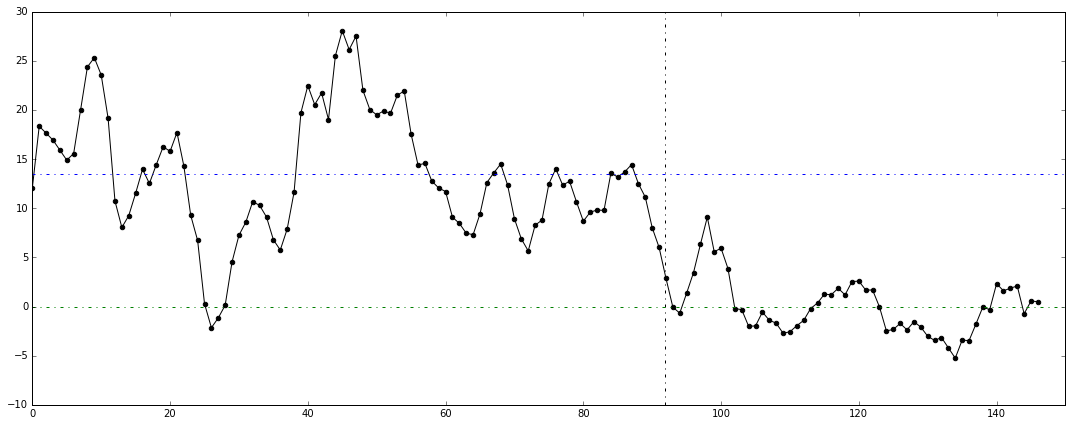

mean diff= 14.0604175715
sigma front = 4.61715240004
sigma end = 3.63607458972


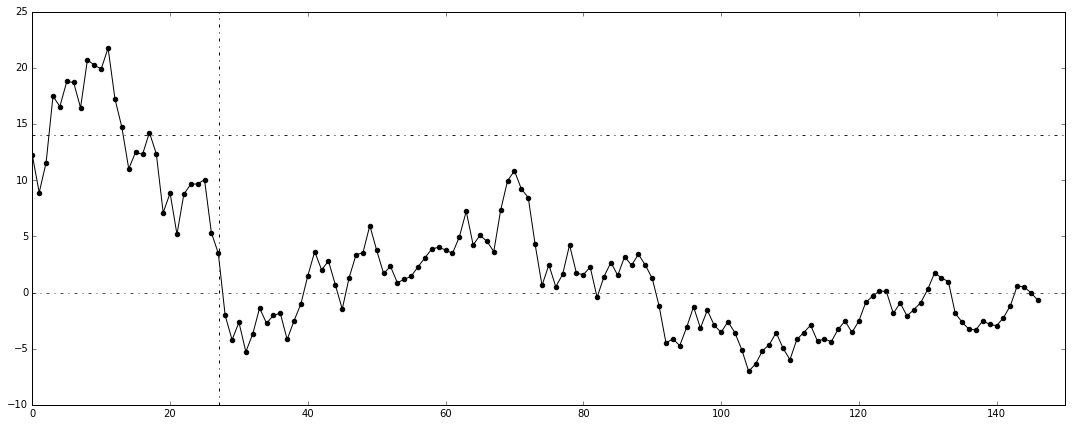

mean diff= 12.5622459833
sigma front = 5.36552674008
sigma end = 1.50860896199


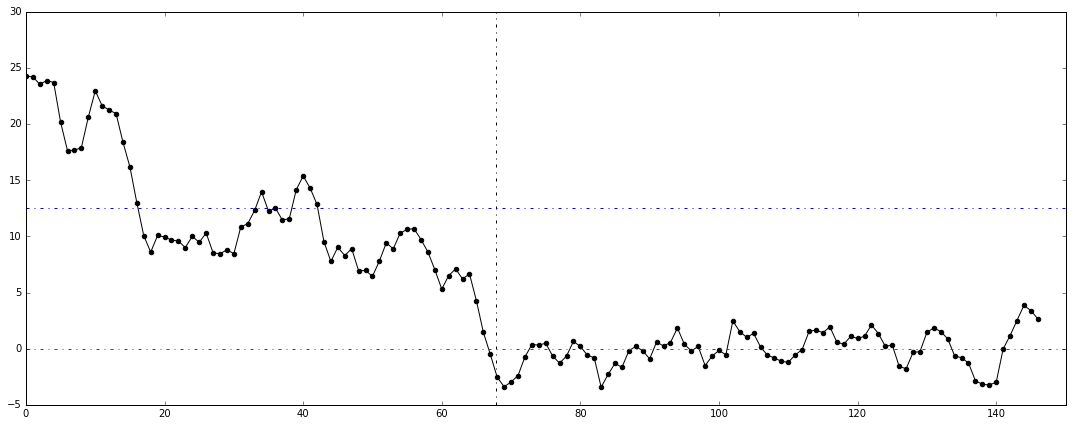

mean diff= 15.2349429273
sigma front = 5.21798803297
sigma end = 2.84996048894


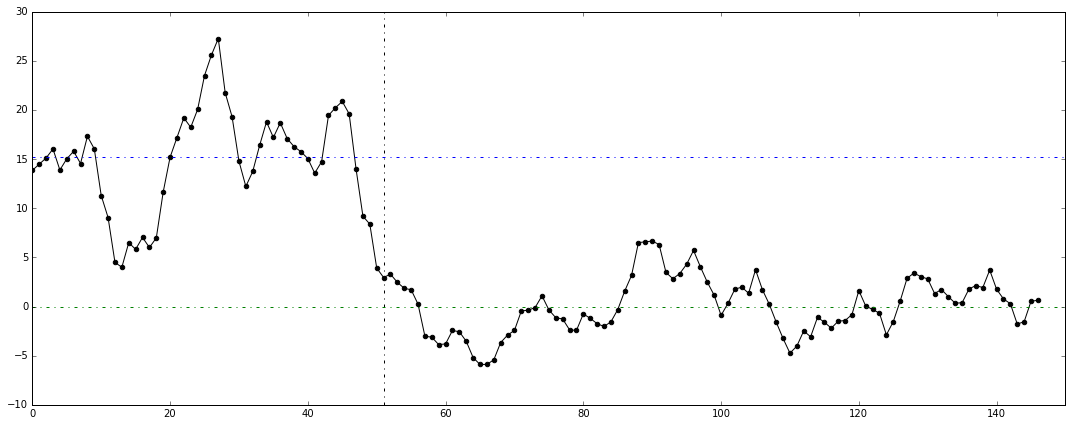

mean diff= 17.2449219993
sigma front = 4.6966819272
sigma end = 2.3226664249


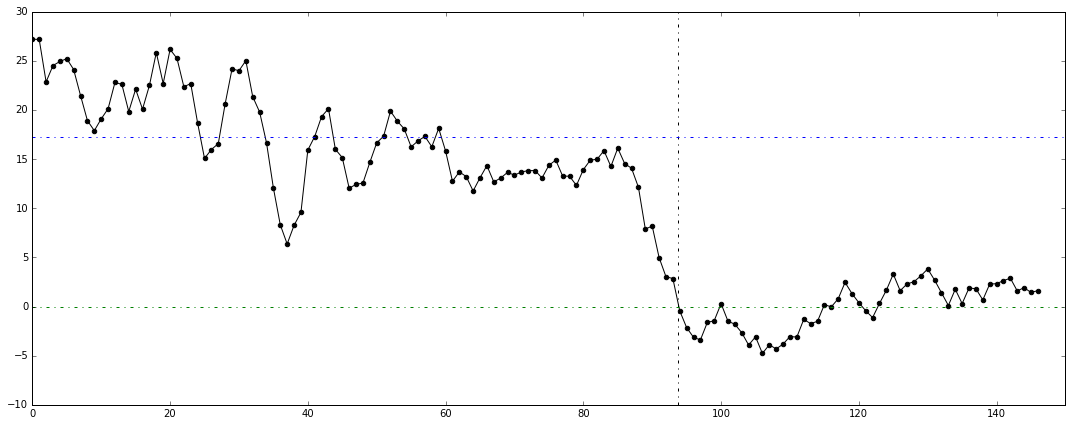

mean diff= 17.9179475445
sigma front = 5.00075424861
sigma end = 3.16259783561


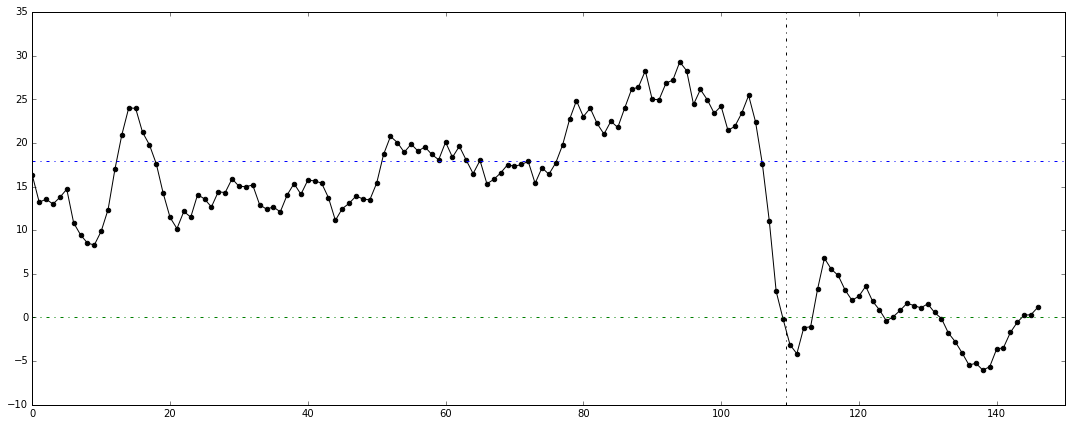

mean diff= 11.3615013952
sigma front = 5.97649884191
sigma end = 8.21685780858


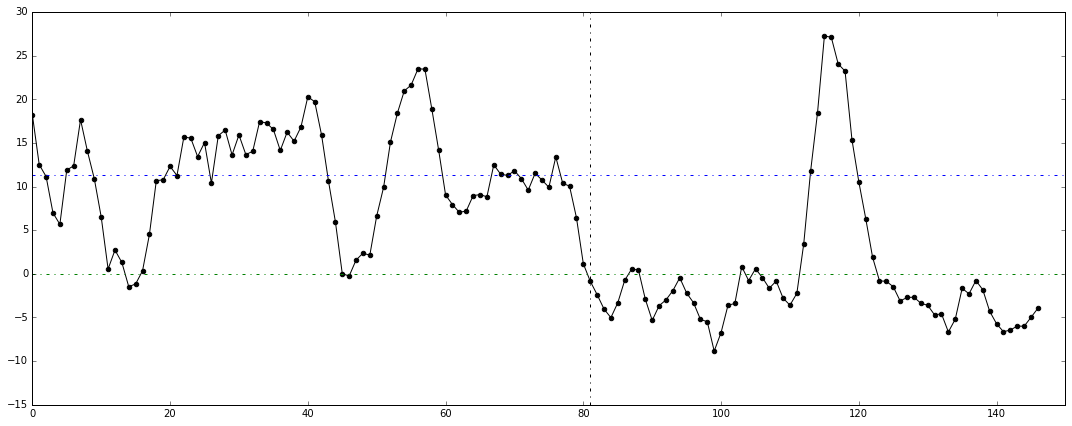

mean diff= 10.3376380944
sigma front = 4.05229481794
sigma end = 6.07149584241


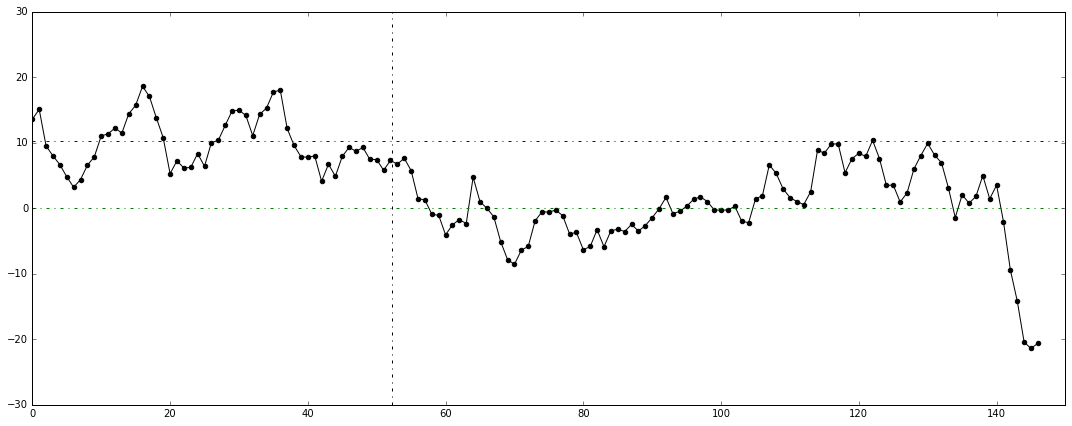

mean diff= 19.4399516822
sigma front = 3.55546574529
sigma end = 4.68057751255


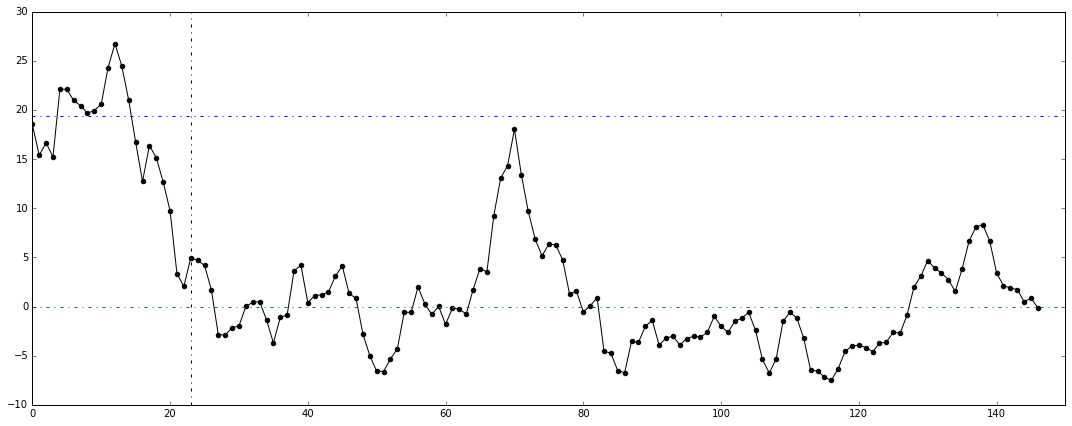

mean diff= 17.7621069586
sigma front = 13.0084922571
sigma end = 1.7471831924


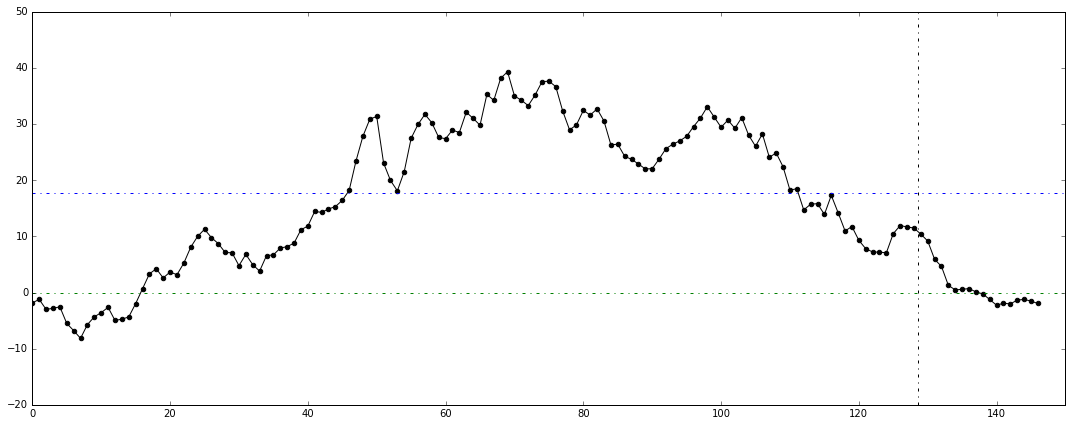

mean diff= 14.9508254486
sigma front = 7.15151527627
sigma end = 2.17459308457


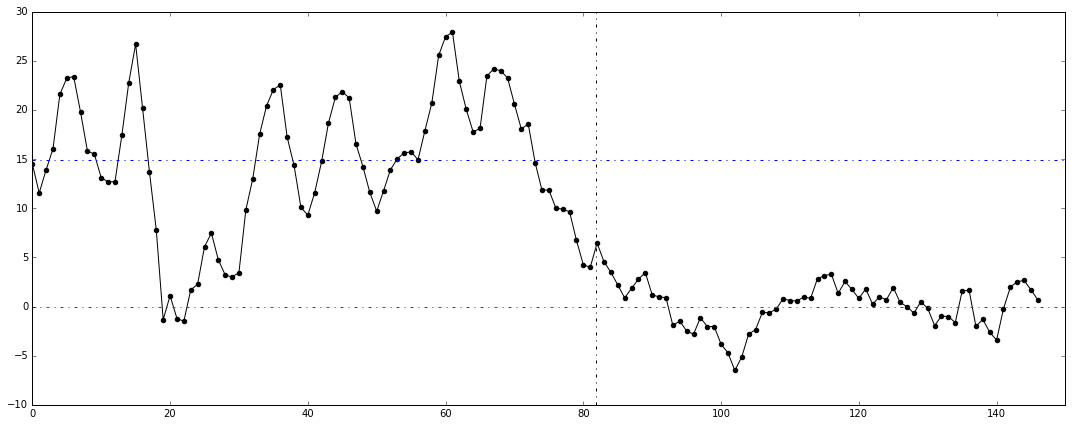

mean diff= 12.2920709508
sigma front = 3.35393572797
sigma end = 0.623141784353


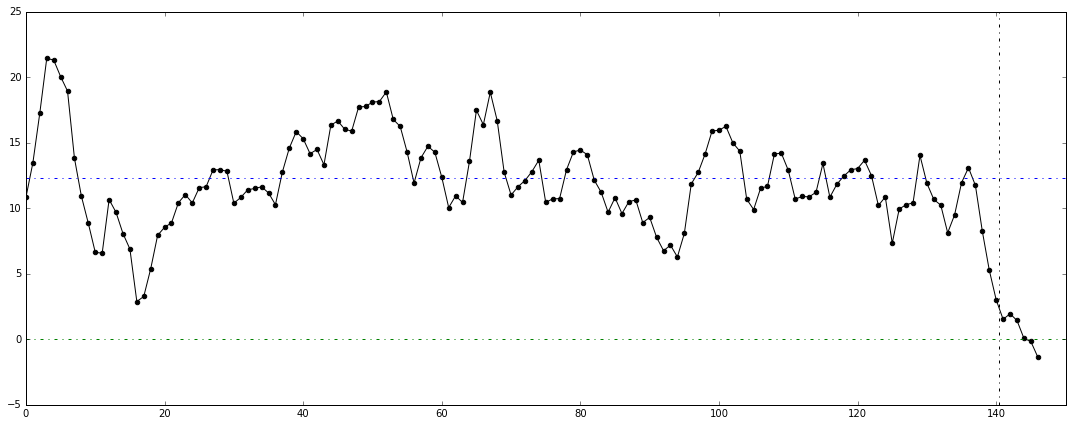

mean diff= 18.1394700085
sigma front = 5.42236520562
sigma end = 3.5007491523


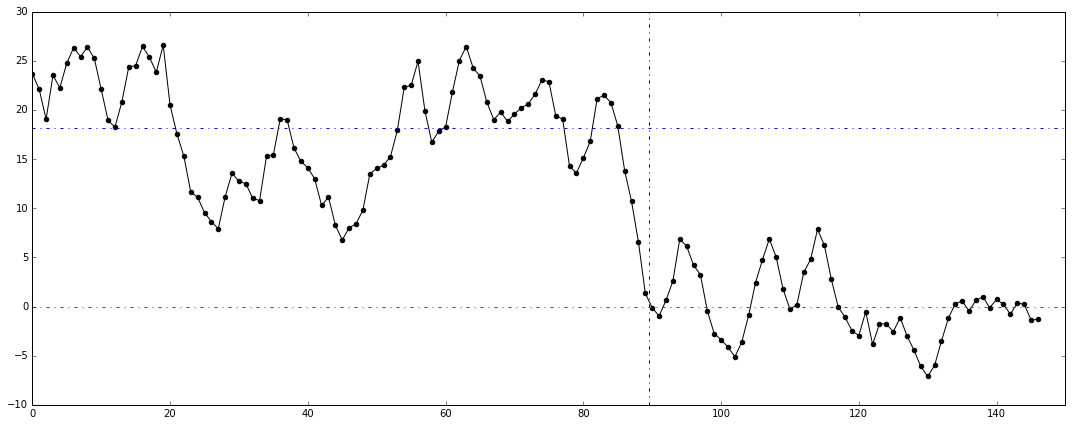

mean diff= 11.7050618343
sigma front = 5.10328137134
sigma end = 1.03539807571


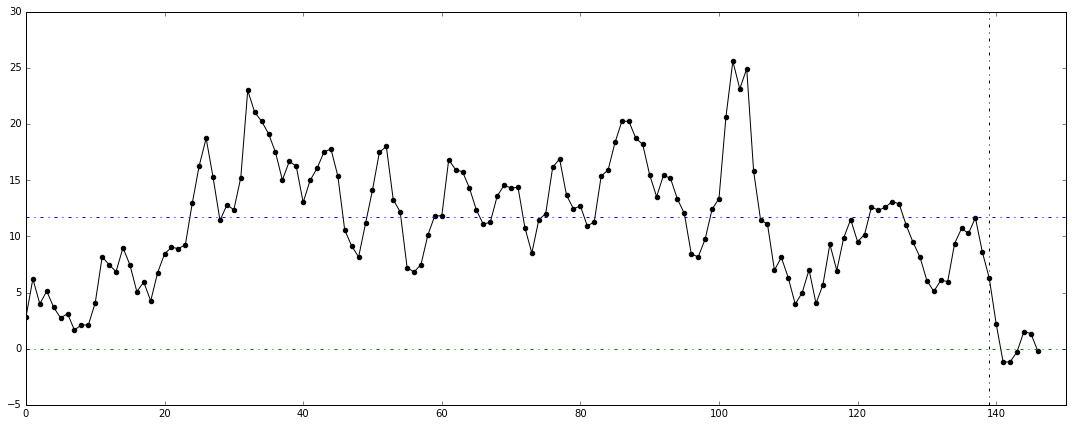

mean diff= 16.3801722506
sigma front = 6.60456180092
sigma end = 5.62686023647


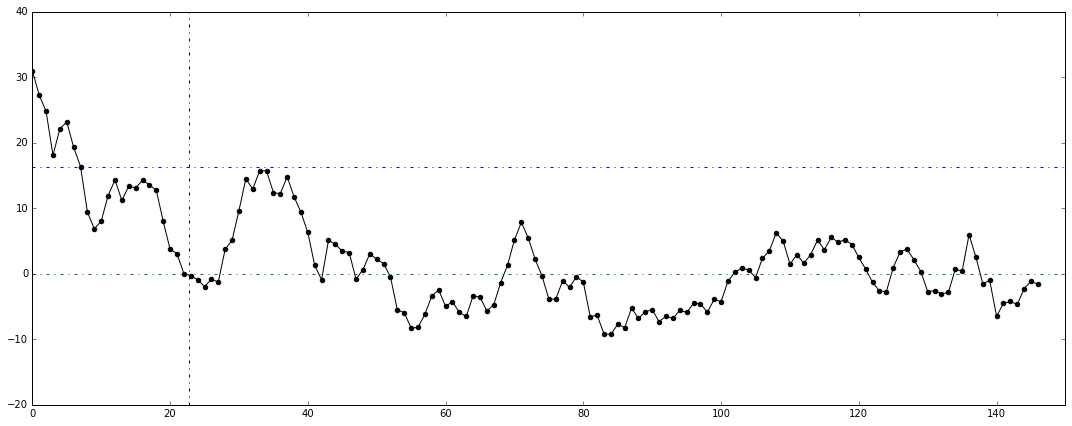

mean diff= 17.4940931075
sigma front = 3.39394897606
sigma end = 4.05267144842


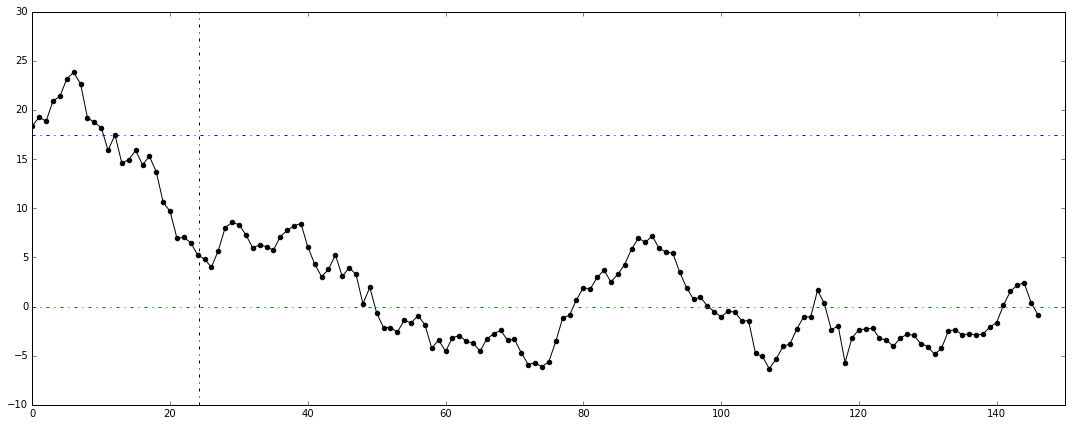

mean diff= 10.2714114844
sigma front = 3.05083055641
sigma end = 2.9729926216


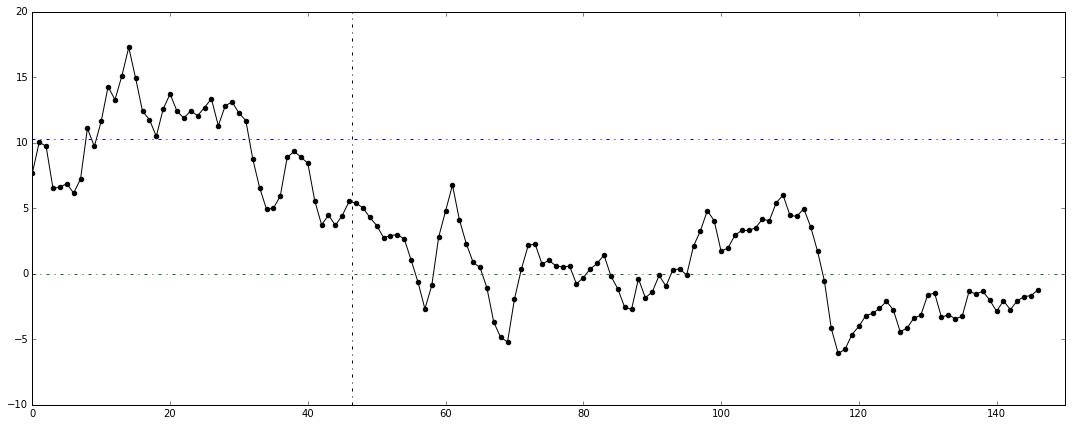

mean diff= 19.9018325726
sigma front = 6.57392511328
sigma end = 3.71055760176


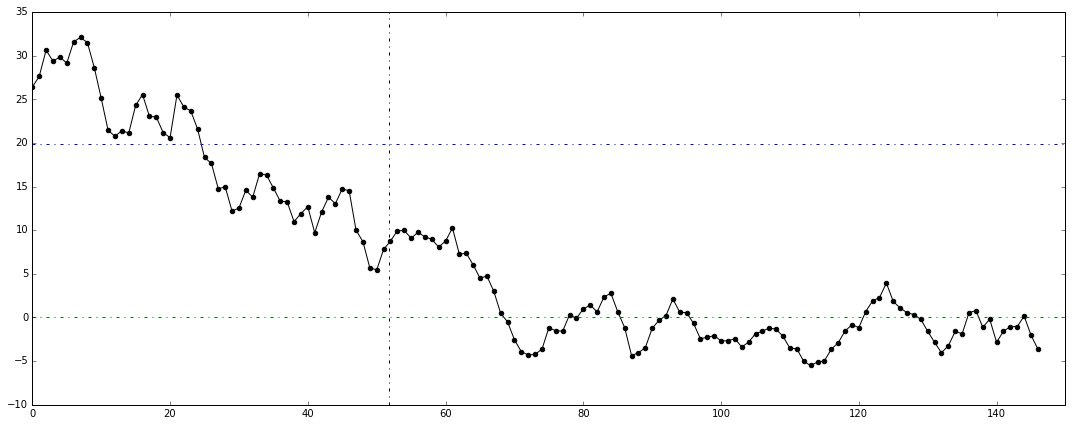

mean diff= 10.639815805
sigma front = 1.82659981821
sigma end = 2.23069871676


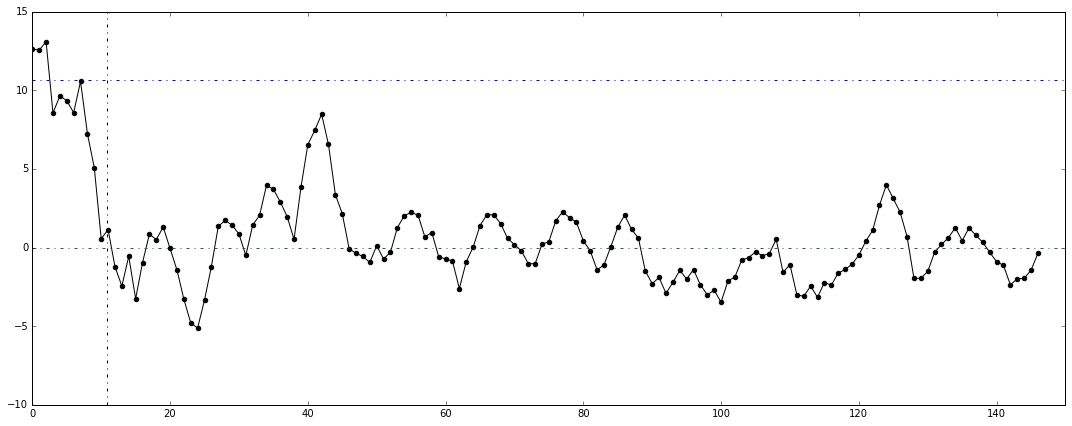

mean diff= 11.7911052752
sigma front = 4.14977565953
sigma end = 2.4333295546


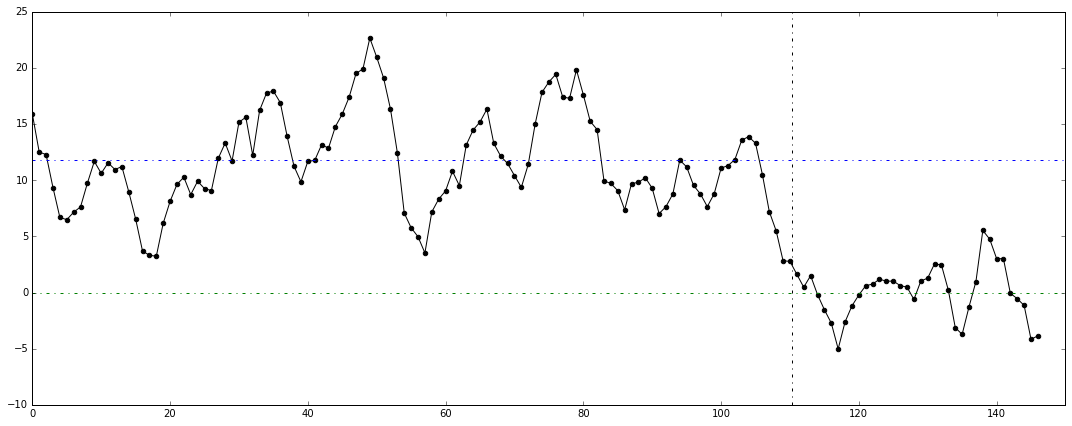

mean diff= 16.5144843082
sigma front = 6.56494157627
sigma end = 4.27906831361


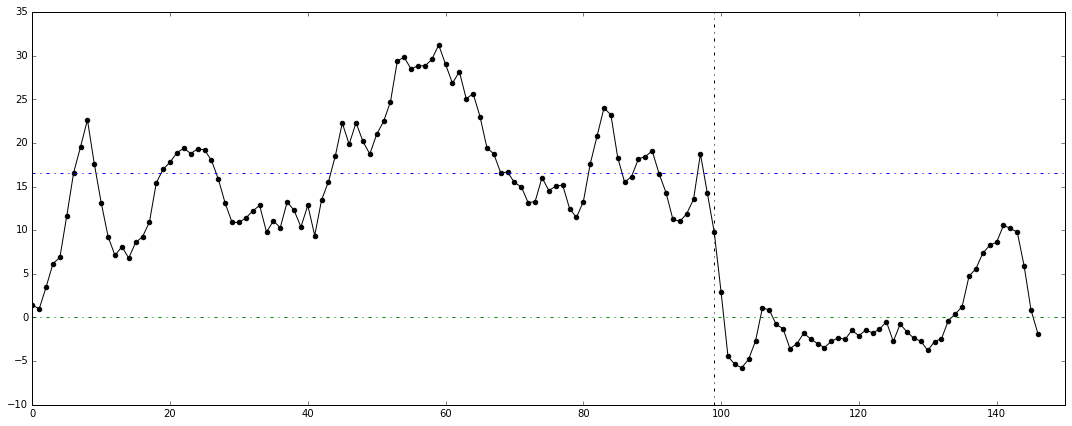

mean diff= 15.402958698
sigma front = 6.68819426672
sigma end = 3.95942276704


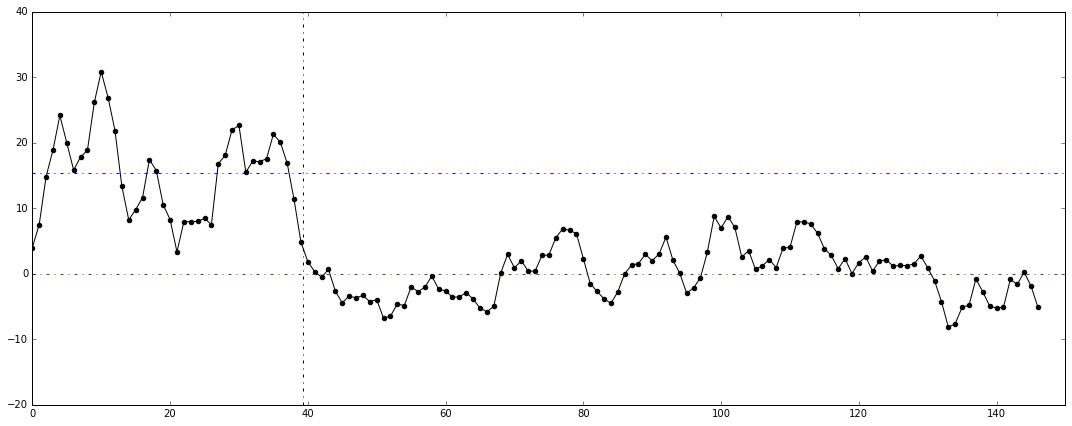

mean diff= 11.8441588465
sigma front = 3.79300403132
sigma end = 2.87291928351


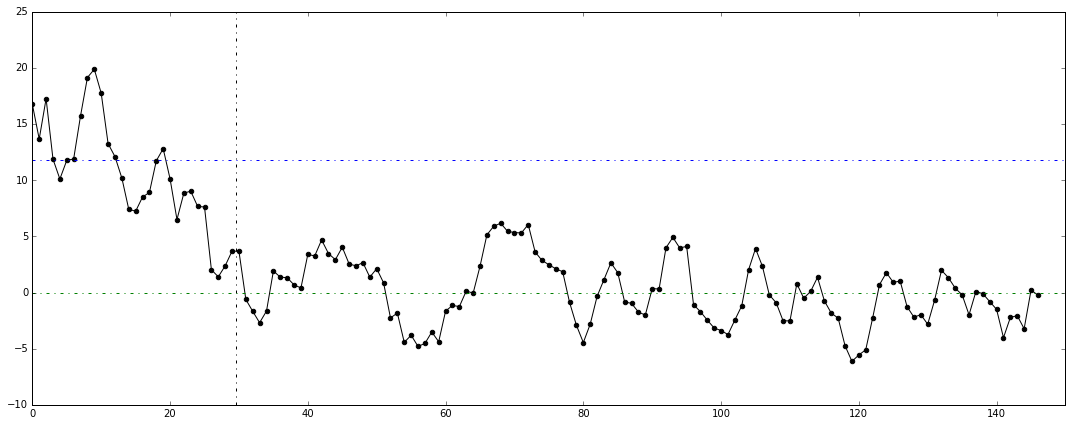

mean diff= 13.4395059292
sigma front = 6.74861471408
sigma end = 7.18973539383


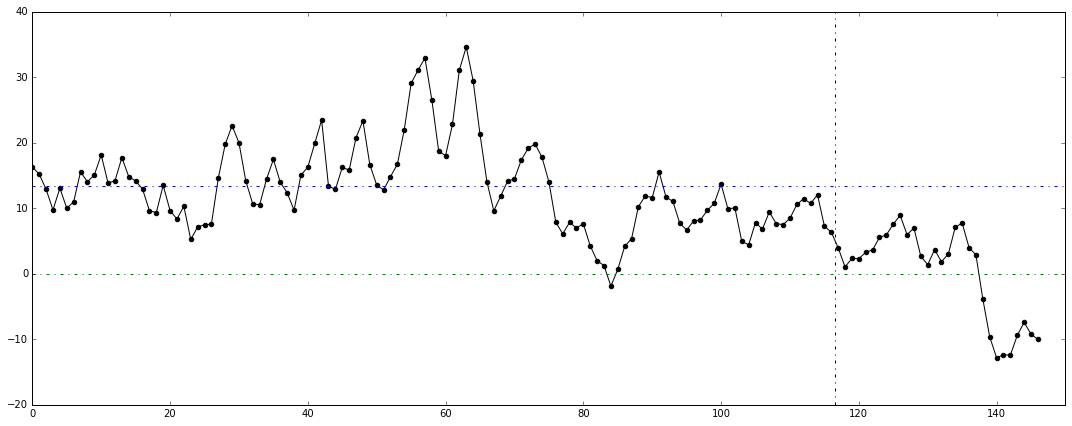

mean diff= 13.9046109235
sigma front = 4.60757862691
sigma end = 4.57681479074


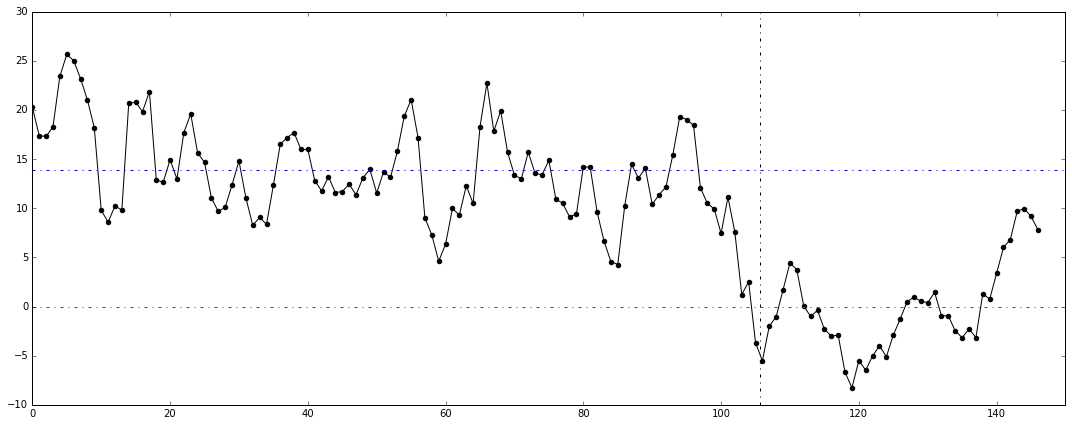

mean diff= 17.1036912462
sigma front = 15.9910791436
sigma end = 5.42322062257


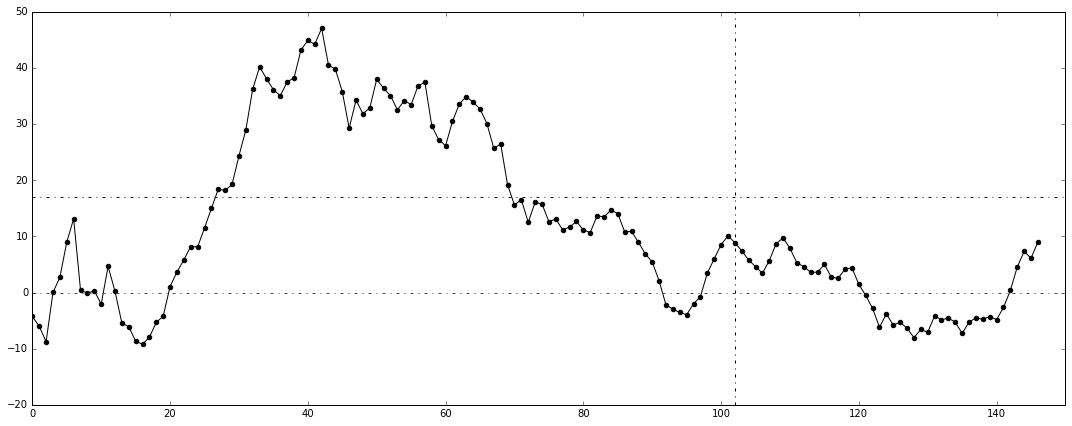

mean diff= 18.0453613174
sigma front = 8.80496357075
sigma end = 1.06877444107


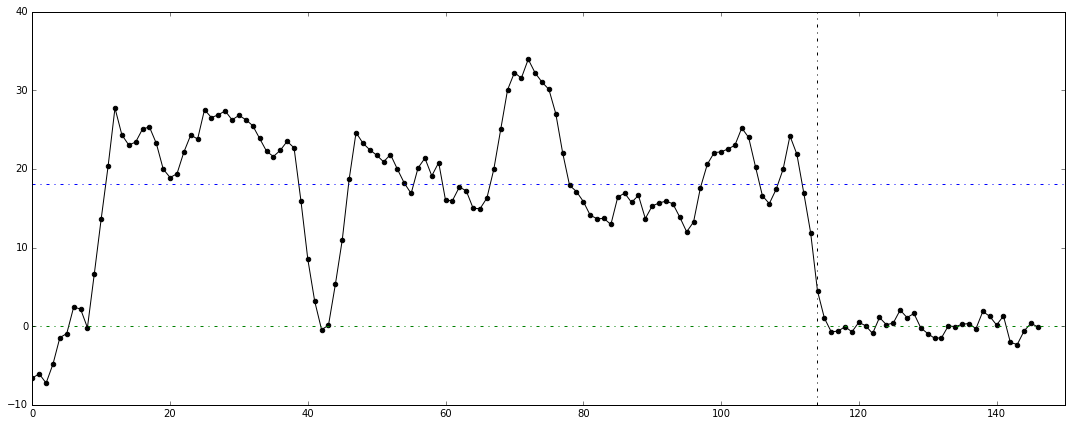

mean diff= 12.135237961
sigma front = 32.5606792231
sigma end = 2.42350258278


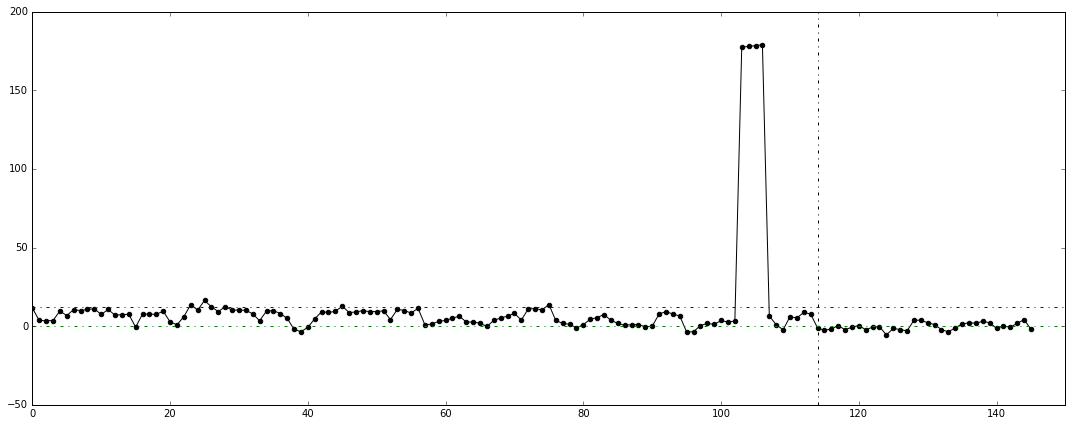

mean diff= 10.2280671876
sigma front = 6.53873085502
sigma end = 2.17644736066


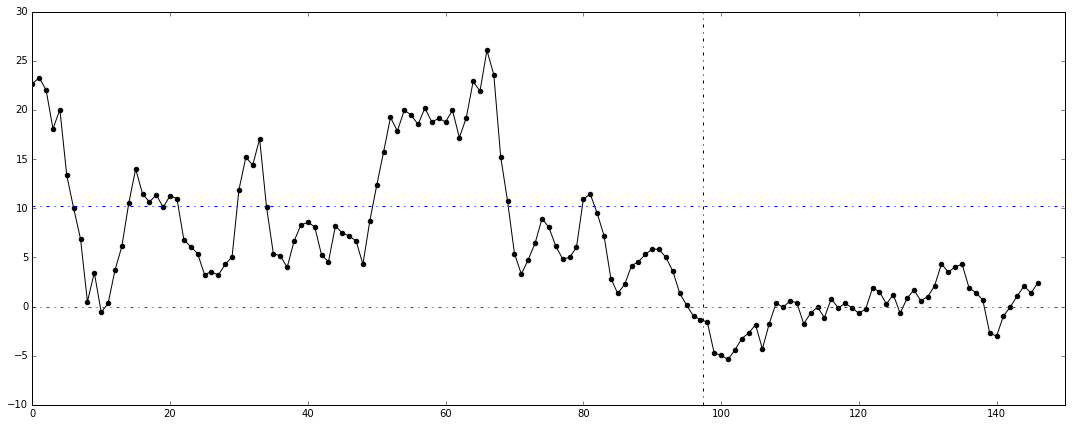

mean diff= 18.6548682719
sigma front = 12.058891306
sigma end = 4.97593344909


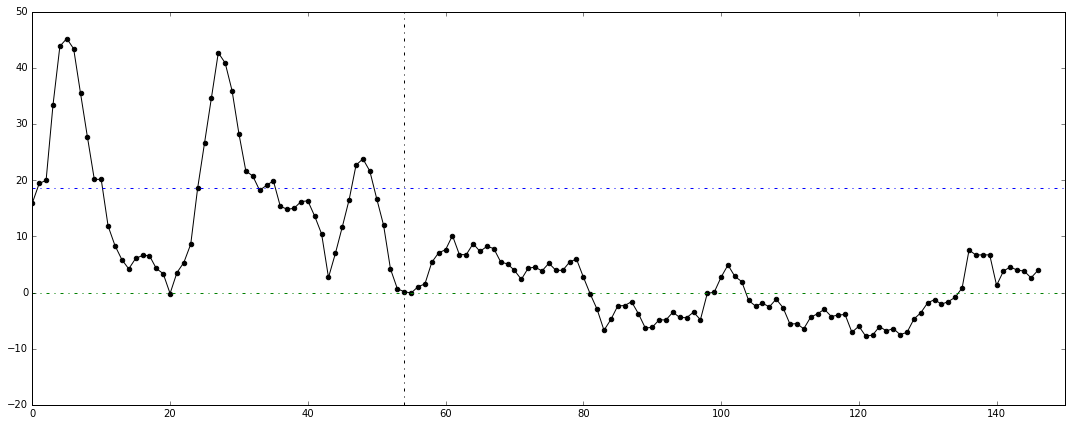

mean diff= 14.3939042138
sigma front = 11.2083246153
sigma end = 0.684616567341


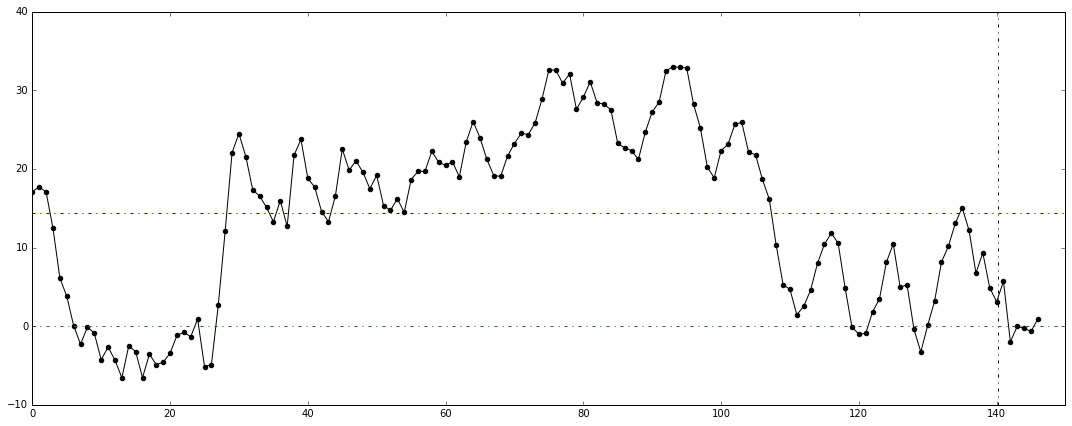

mean diff= 10.9608921446
sigma front = 5.01564585921
sigma end = 3.08357523586


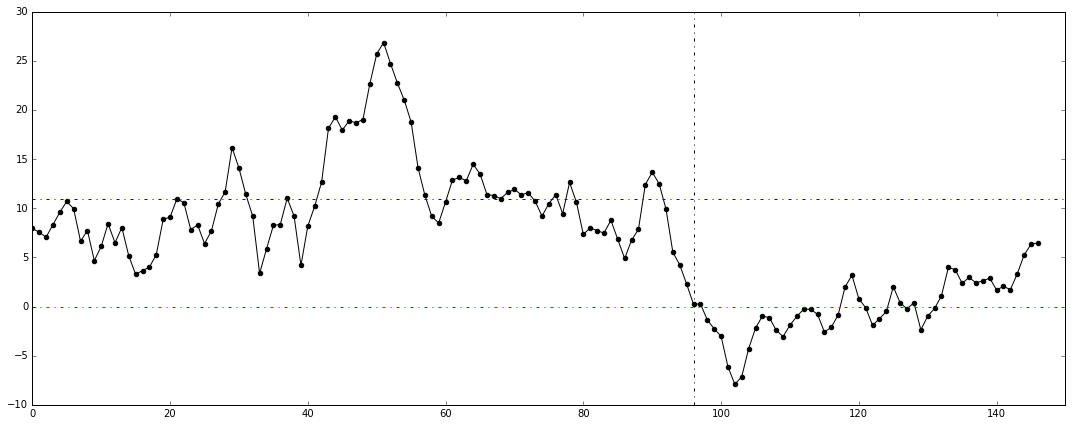

mean diff= 15.719408733
sigma front = 4.01799093102
sigma end = 3.29910680511


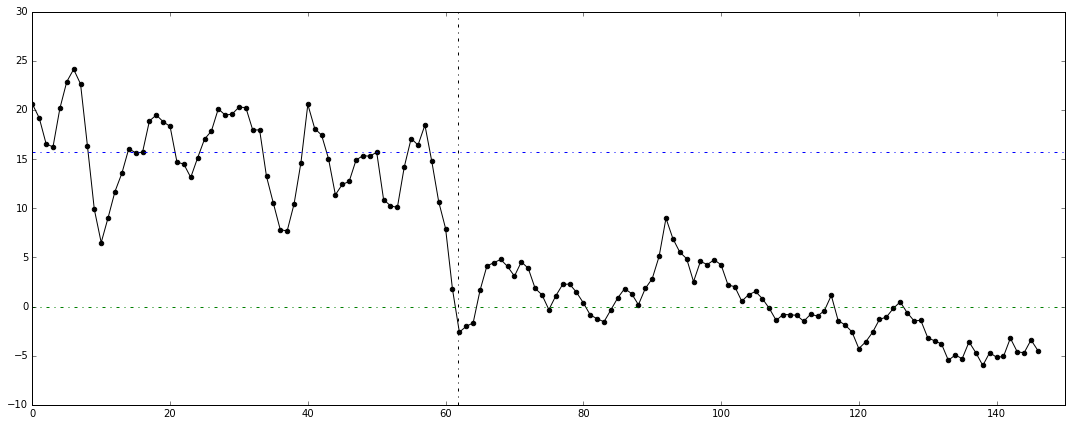

mean diff= 10.5748078067
sigma front = 2.81941177509
sigma end = 7.23030544532


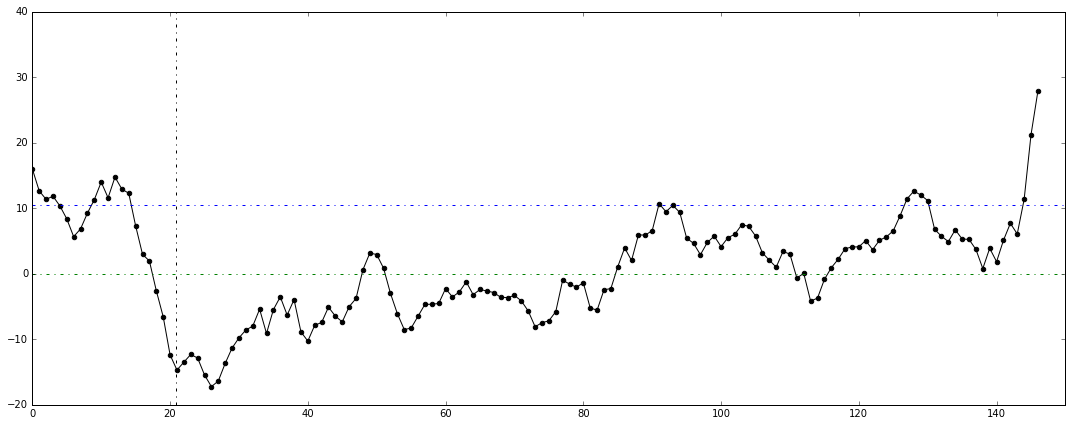

mean diff= 11.9524404023
sigma front = 6.58003532133
sigma end = 3.04687282432


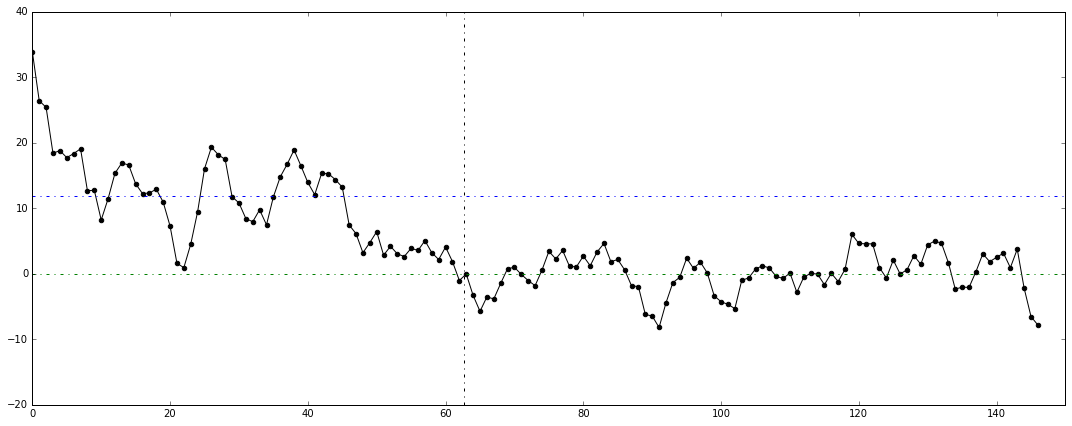

mean diff= 17.1512475492
sigma front = 4.59244880093
sigma end = 3.4058582314


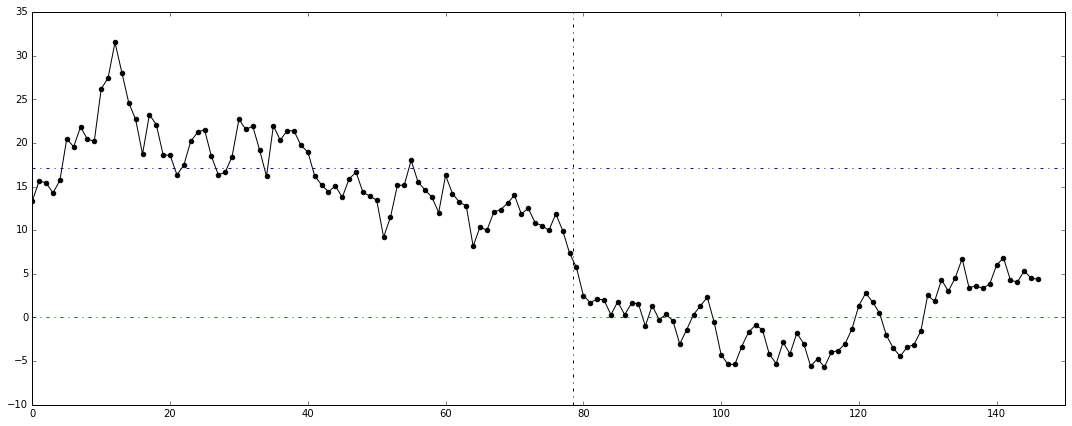

mean diff= 10.0165571846
sigma front = 8.10731462189
sigma end = 5.93097771476


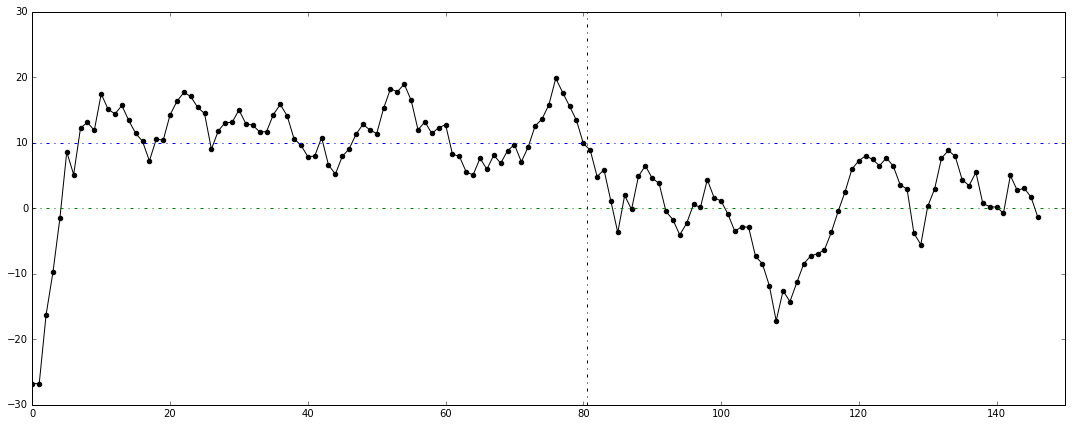

mean diff= 18.329245037
sigma front = 3.69877207627
sigma end = 1.67809470915


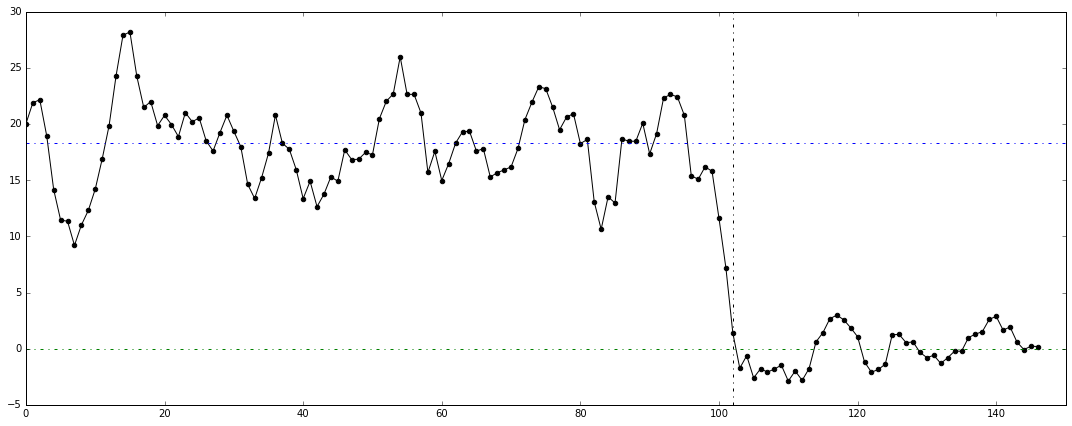

mean diff= 10.4245514221
sigma front = 7.34832252989
sigma end = 4.42681334842


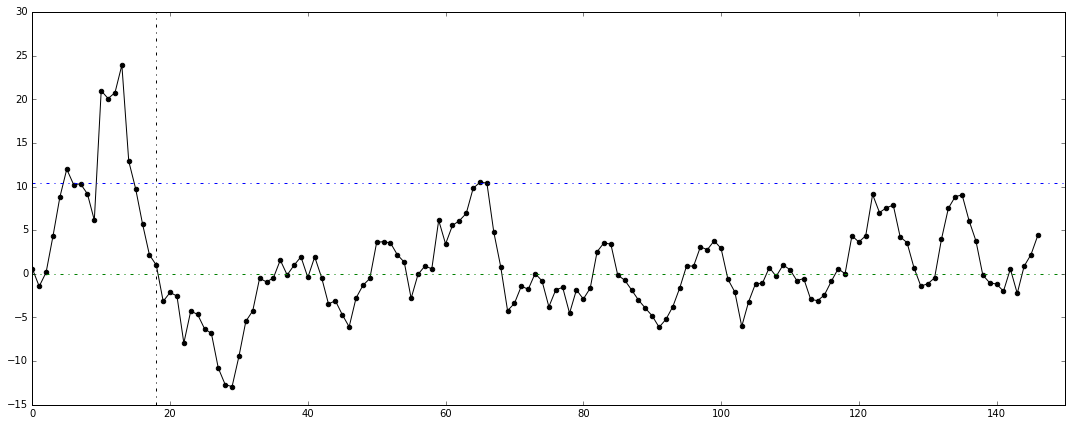

mean diff= 13.6403859669
sigma front = 5.46024148438
sigma end = 3.91246509477


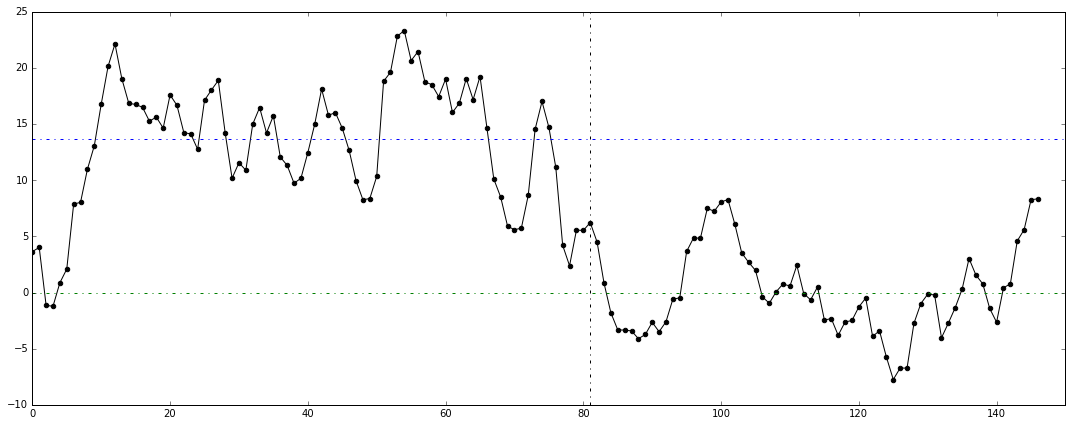

mean diff= 19.600350427
sigma front = 5.34041012998
sigma end = 3.44629327062


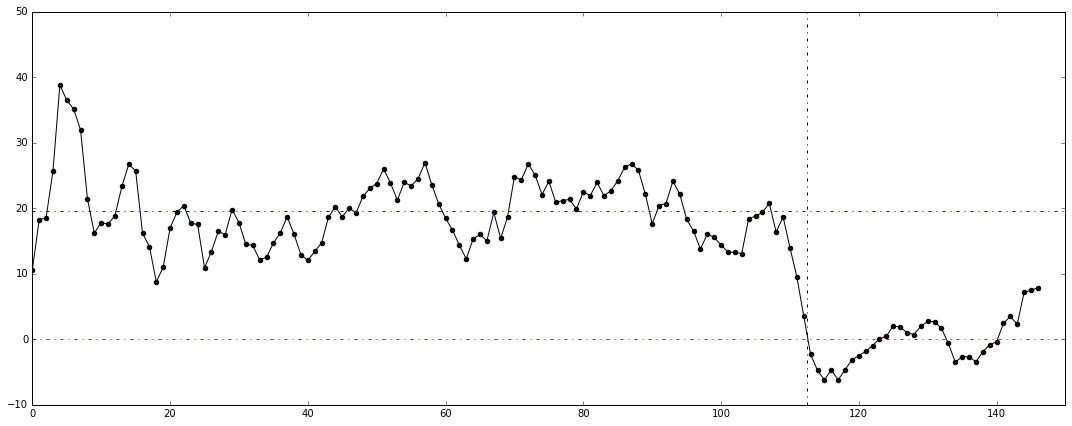

mean diff= 15.5983858307
sigma front = 3.92285124332
sigma end = 2.4464195364


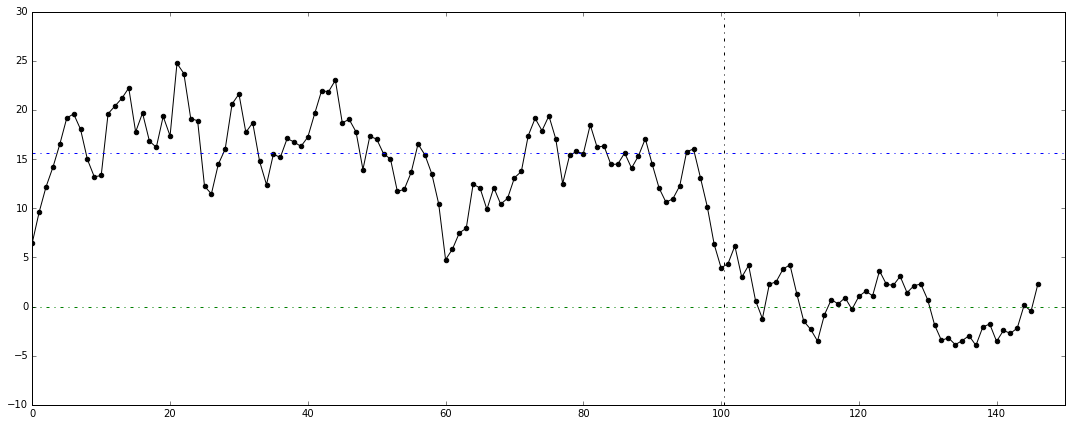

mean diff= 12.5640032329
sigma front = 3.67049172406
sigma end = 2.46492685391


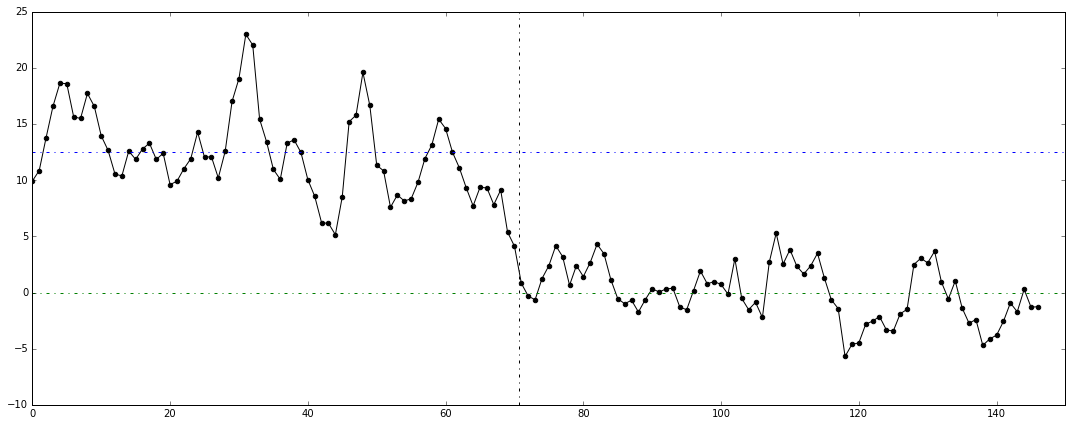

mean diff= 19.7706604126
sigma front = 7.19224744057
sigma end = 2.61112239783


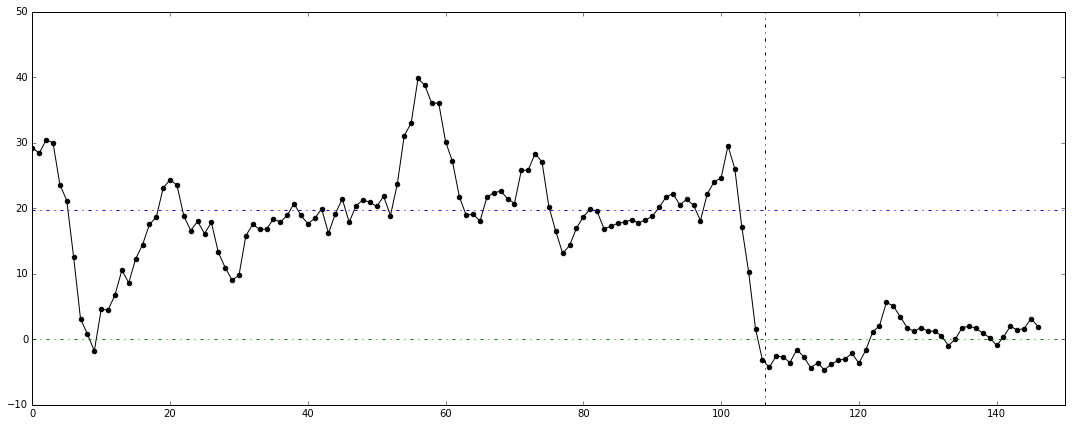

mean diff= 14.995370775
sigma front = 3.46754839242
sigma end = 1.95622827507


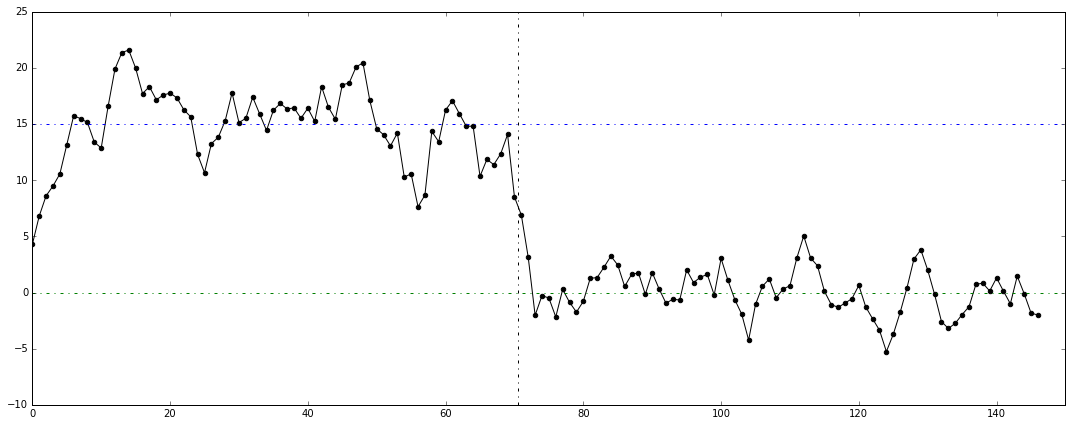

mean diff= 12.9239883694
sigma front = 3.96362774076
sigma end = 2.29868879958


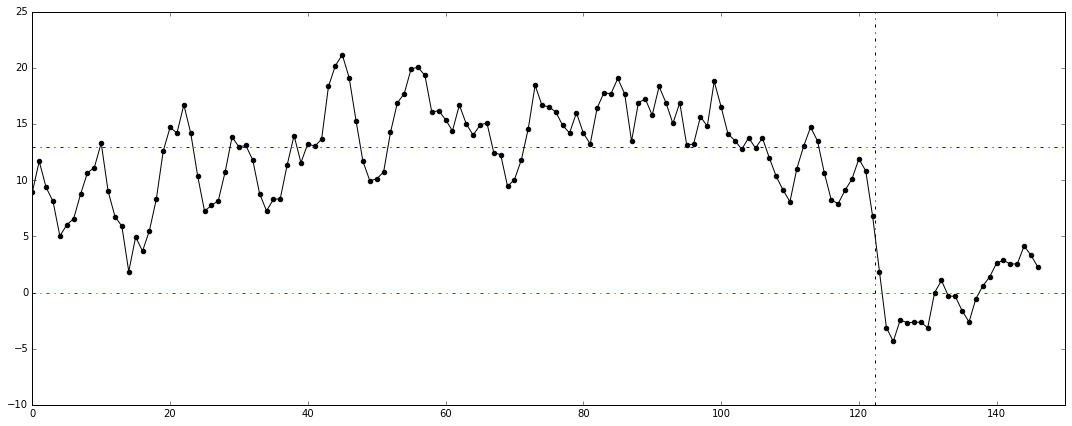

mean diff= 15.5344828646
sigma front = 3.417133189
sigma end = 5.65626875824


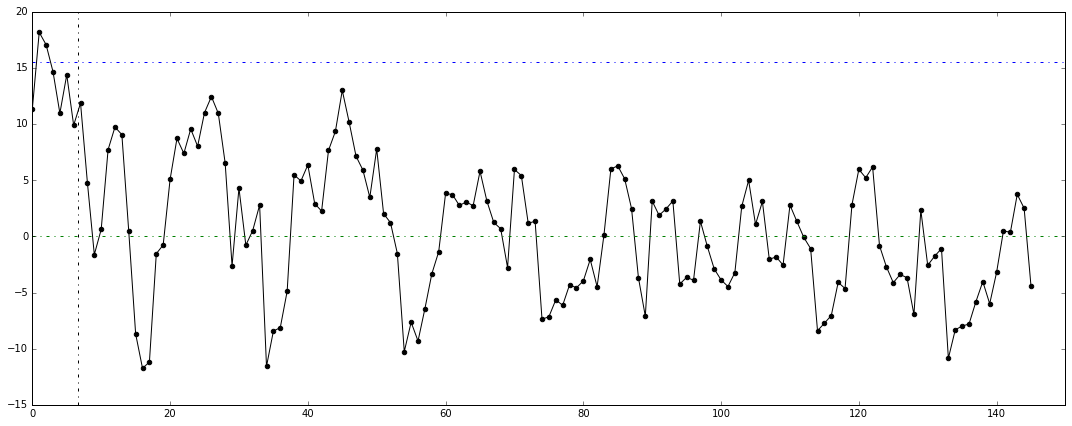

mean diff= 18.113712803
sigma front = 2.38951409375
sigma end = 6.01797468103


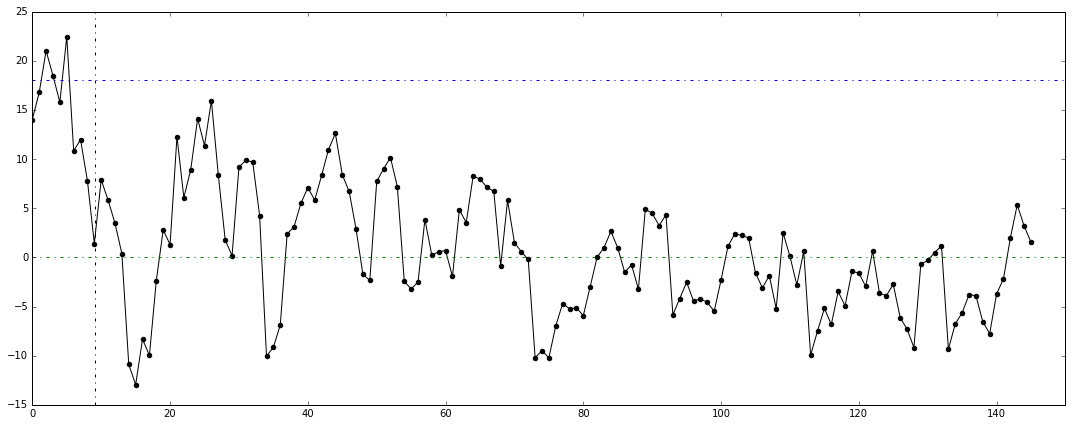

mean diff= 19.5540475569
sigma front = 2.71538486858
sigma end = 5.62080235888


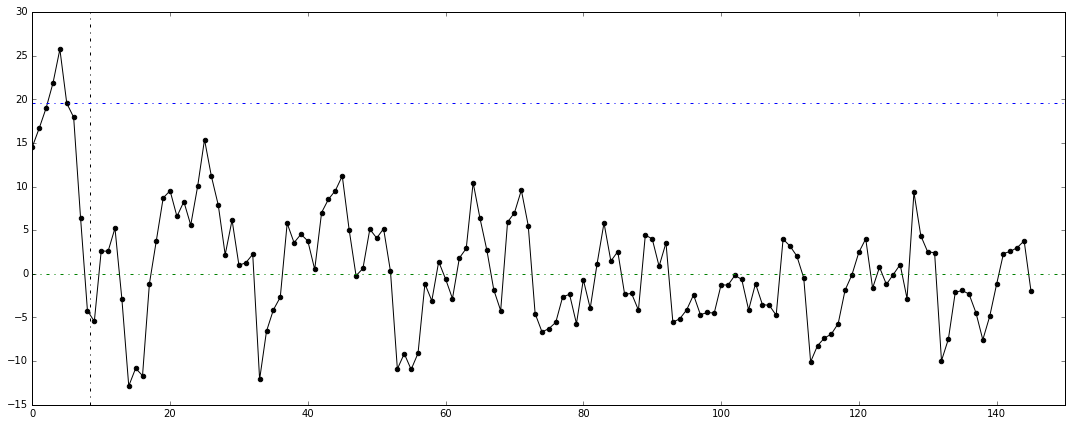

mean diff= 10.0461764832
sigma front = 5.21974792754
sigma end = 4.52688735345


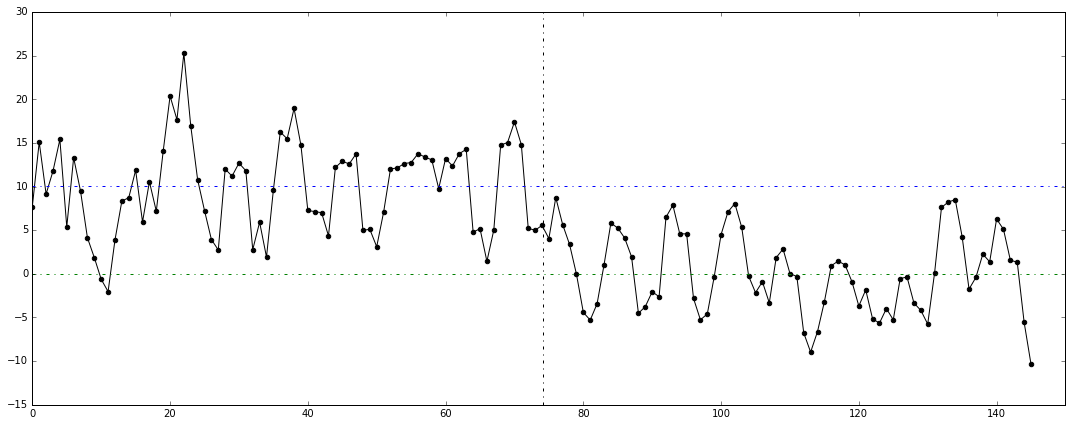

mean diff= 10.3620059797
sigma front = 5.31890010111
sigma end = 2.91768719262


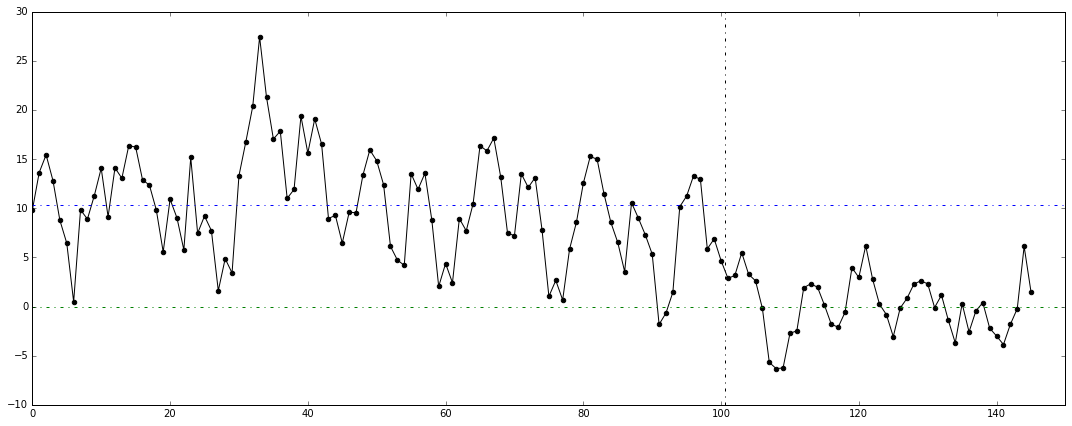

mean diff= 12.4900360715
sigma front = 4.11685276868
sigma end = 4.00137474722


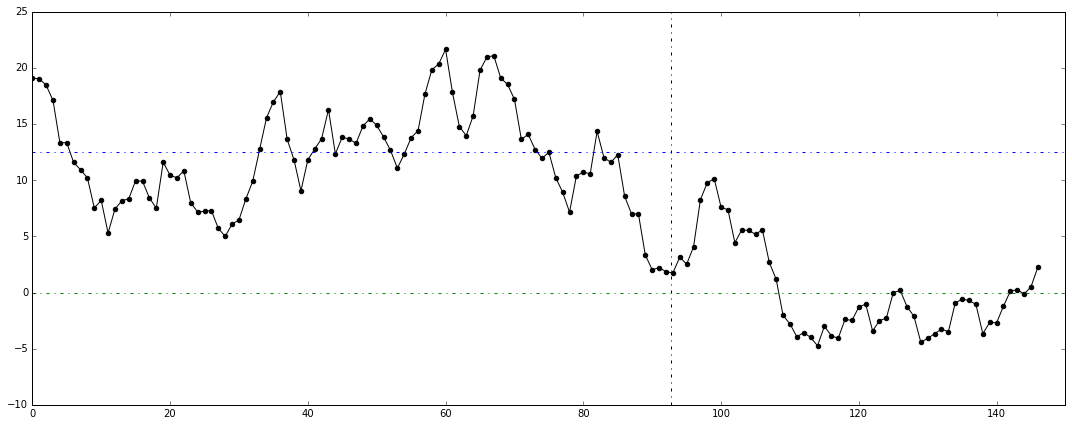

mean diff= 15.4483272487
sigma front = 3.88425648638
sigma end = 1.41250803743


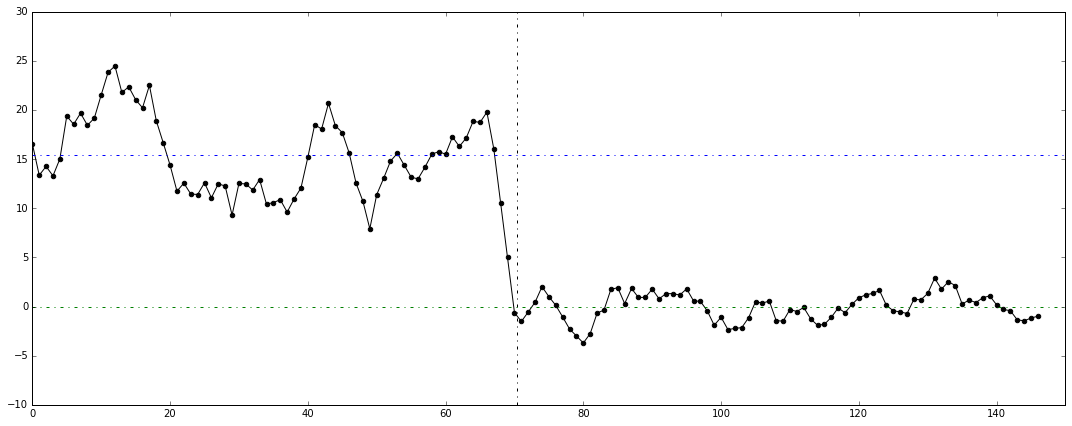

mean diff= 11.2660958287
sigma front = 6.81208658767
sigma end = 3.12415014855


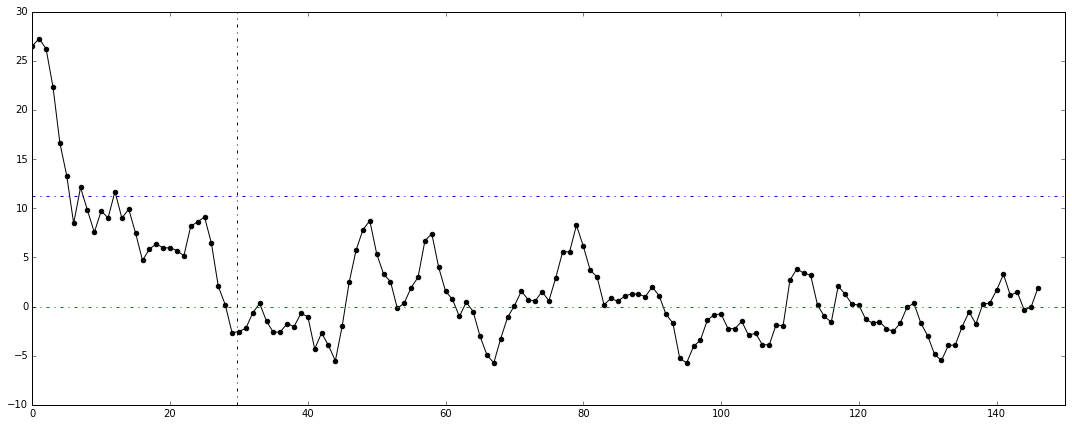

mean diff= 11.1522677153
sigma front = 5.92560271753
sigma end = 1.51418663678


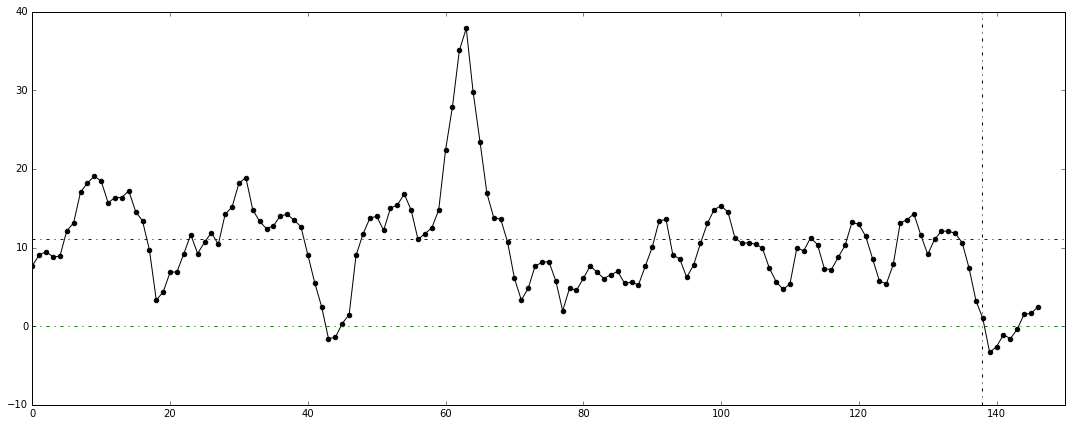

mean diff= 12.8218078178
sigma front = 5.78472784827
sigma end = 3.02950386889


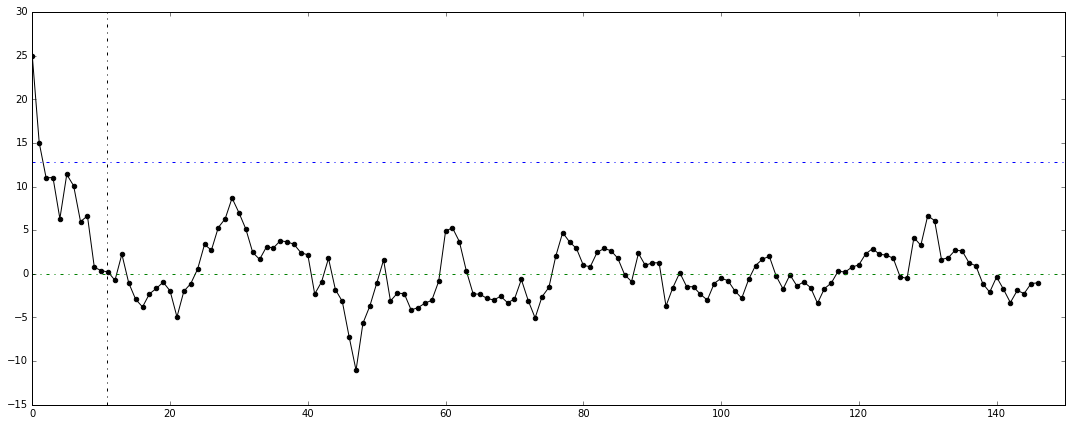

mean diff= 12.6320864976
sigma front = 6.38088033406
sigma end = 3.89224575805


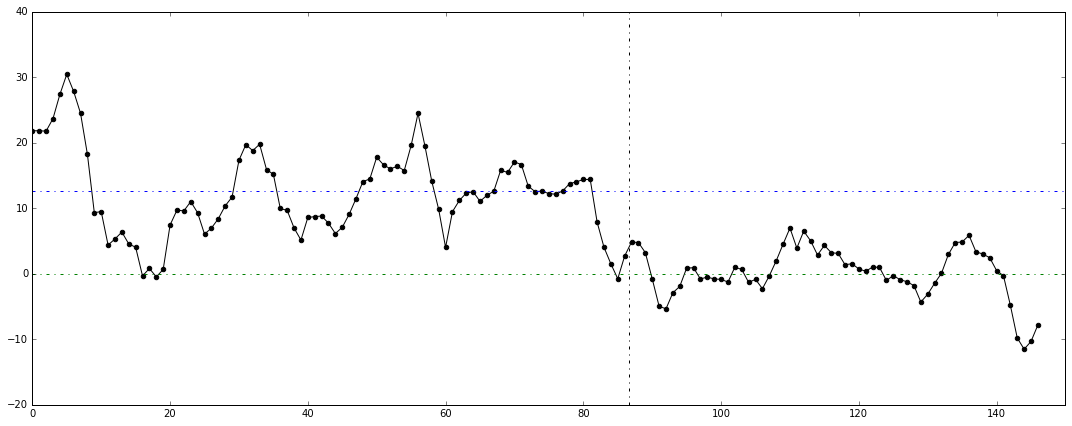

mean diff= 12.5994599987
sigma front = 2.57907211277
sigma end = 1.99058295607


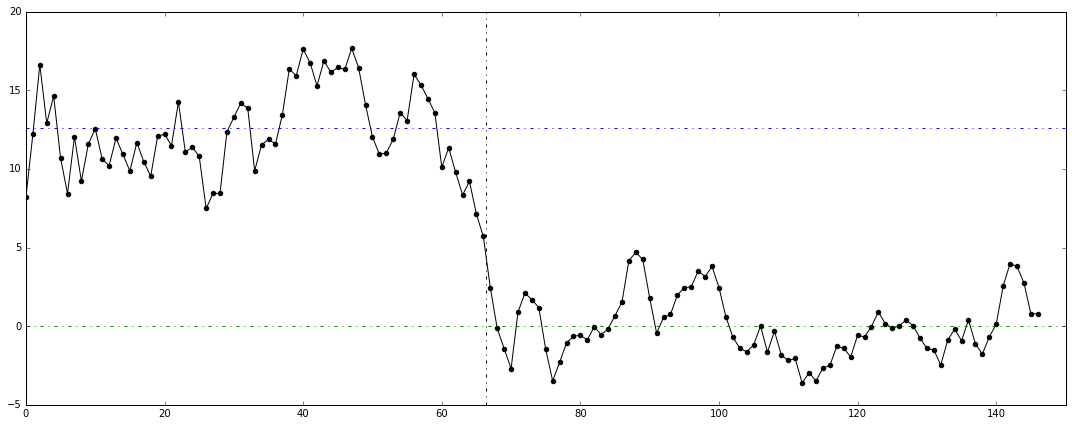

mean diff= 15.9020996955
sigma front = 8.80760013758
sigma end = 3.95319272644


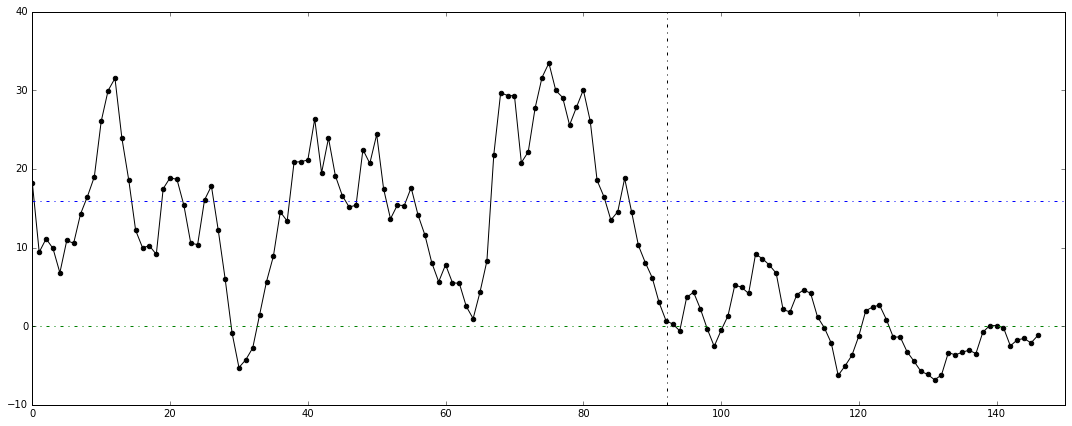

mean diff= 14.4968870684
sigma front = 5.24557058673
sigma end = 2.03365387849


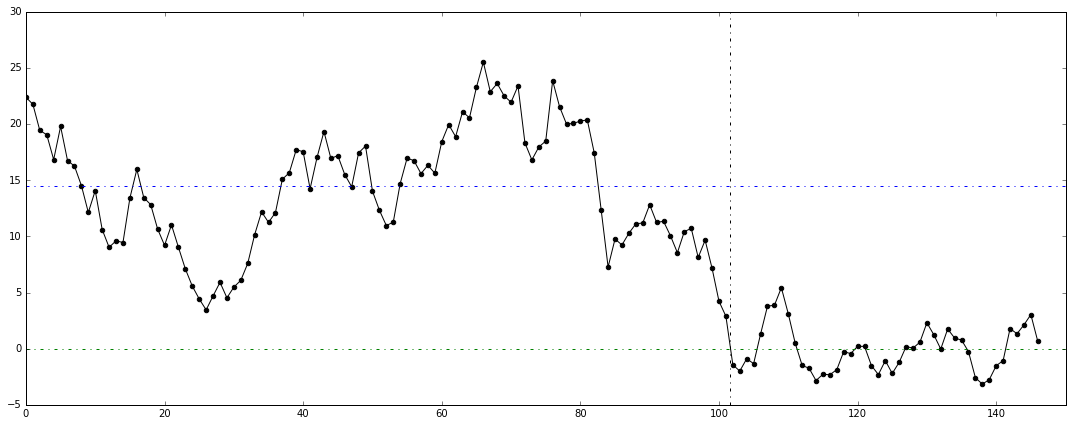

mean diff= 12.8322311014
sigma front = 3.85474457009
sigma end = 1.64725577017


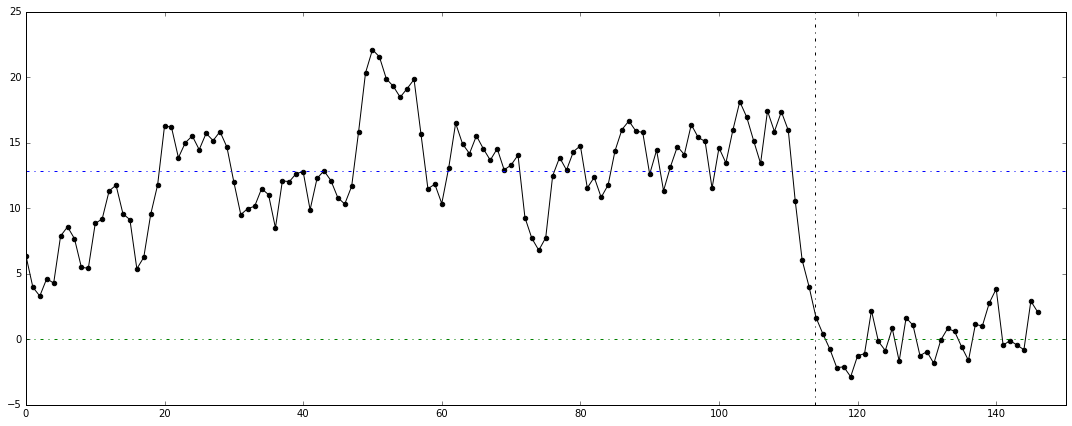

mean diff= 17.2130281064
sigma front = 4.94157619289
sigma end = 3.19783616756


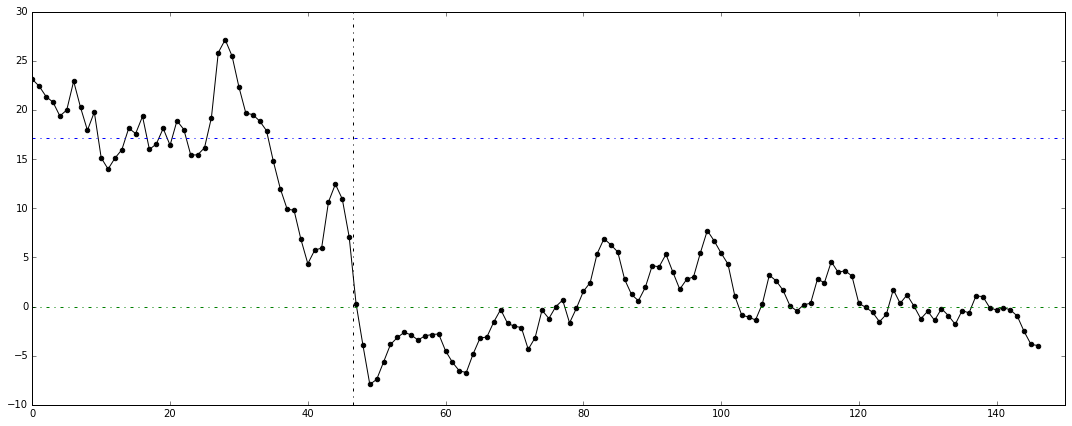

mean diff= 14.0668992816
sigma front = 4.8580075038
sigma end = 2.99302610864


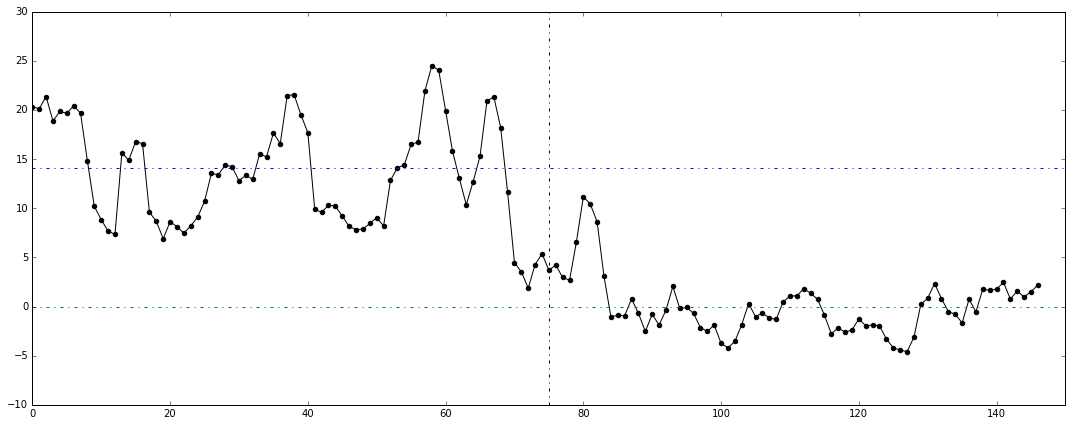

In [52]:
vals =np.arange(0,len(AREASS[0][0]))
#vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))
Q=0
Offset=4
for x in range(0,len(AREASS[Q])):
    if MEAND[Q][x]<20 and MEAND[Q][x]>10 and CHIR[Q][x]<1:
        plt.figure(figsize=(15,6))
        vals =np.arange(0,len(AREASS[Q][x]))

        #plt.title(x,fontsize=20)
        #print('Chi ratio = ',chiRa[x])
        #print('tau =', str(data[x][1])+' '+"+/-"+' '+str(Dtau[x]/7.75))
        TauH   = LIFETIME[Q][x]
        #Data = running_mean(Signal[x],4)
        DataLeft  = AREASS[Q][x][:int(TauH)-Offset]
        DataRight = AREASS[Q][x][int(TauH)+Offset:]
        #meanI  = np.mean(DataLeft)
        #meanE  = np.mean(DataRight)
        #print('mean front=',meanI)
        #print('mean back=',meanE)
        print('mean diff=',MEAND[Q][x])
        print('sigma front =',np.std(DataLeft))
        print('sigma end =',np.std(DataRight))
        #plt.title(str(x) +'\n'+str(PairsMade[x]),fontsize=20)
        if MEANE[Q][x]<0:
            Correct = abs(MEANE[Q][x])
        else:
            Correct = -abs(MEANE[Q][x])

        plt.scatter(vals,AREASS[Q][x]+Correct,color='k')
        plt.plot(vals,AREASS[Q][x]+Correct,color='k')
        #plt.axhline(0,linestyle ='-.',color='k')
        plt.axvline(LIFETIME[Q][x],linestyle ='-.',color='k')
        
        plt.axhline(MEANI[Q][x]+Correct,linestyle ='-.',color='b')
        plt.axhline(MEANE[Q][x]+Correct,linestyle ='-.',color='g')
        #plt.axvline(LIFETIME[Q][x],linestyle ='-.',color='k')

        #plt.plot(running_mean(vals,K),running_mean(data[x][0],K),color='grey')
        #plt.scatter(running_mean(vals,K),running_mean(data[x][0],K),color='grey')

        #val = np.arange(0,len(running_mean(data[x][0],4)) ,1)
        ##fit=np.polyfit(val,running_mean(data[x][0],4),1)  
        #plt.plot(val,fit[1]+val*fit[0],color='b')
        #plt.plot(val,(np.polyval(fit, val) - running_mean(data[x][0],4)))

        #plt.axhline(np.mean(data[x][0]),linestyle ='-',color='r')

        #plt.axvline(data[x][1],linestyle ='-.',color='k')
        plt.xlim(0,150)
        #plt.ylim(0,50)
        plt.tight_layout()
        plt.show()